<div align=center>

<font size=5>
    In the Name of God
<font/>
<br/>
<br/>
<font>
    Sharif University of Technology - Departmenet of Electrical Engineering
</font>
<br/>
<font>
    Introducing with Machine Learing - Dr. S. Amini
</font>
<br/>
<br/>
Spring 2023

</div>

<hr/>
<div align=center>
<font size=6>
    Neural Networks Practical Assignment
    
    Question 1
</font>
<br/>		
<font size=4>
<br/>
</div>

# Personal Data

In [18]:
# Set your student number
student_number = 99109166
Name = 'َArman'
Last_Name = 'Lotflalikhani'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch. 

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install torchvision
!pip install torch

## Importing Libraries

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [3]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

In [4]:
image_shape = train_set[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(FashionMNIST.classes)

In [5]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class

- **Hint**:  You can use `plt.subplots` for visualization

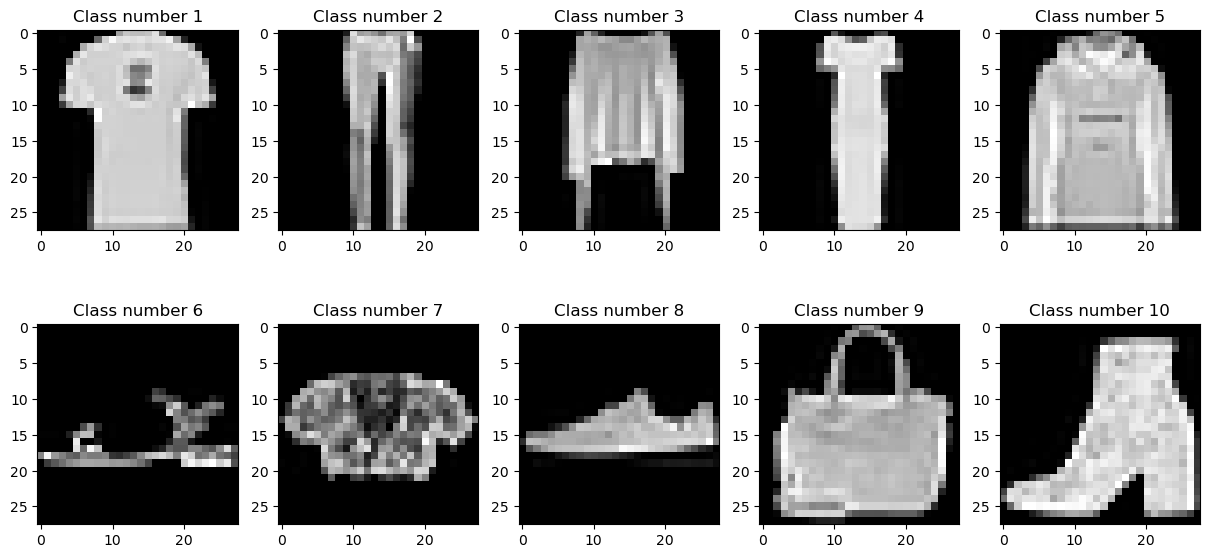

In [6]:
fig1,axs1=plt.subplots(2,5,figsize=(15,7))
rng=np.random.default_rng()
for i in range(10):
    index = rng.integers(len(train_set))
    image, label = train_set[index]
    while (label!=i):
        index = rng.integers(len(train_set))
        image, label = train_set[index]
    axs1[i//5][i%5].title.set_text("Class number %i" %(i+1))
    axs1[i//5][i%5].imshow(image[0], cmap="gray")
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [7]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [8]:
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [9]:
def affine_forward(x, w, b):
    ## FILL HERE
    return torch.matmul(x,w)+b #evaluates w.T @x+b

def relu(x):
    ## FILL HERE
    return torch.maximum(x,torch.Tensor([0]).to(device))

Function `model` returns output of the whole model for the input `x` using the parameters:

In [10]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    # number of batches
    B = x.shape[0]
    x = x.view(B, -1)
    
    ## FILL HERE
    output=torch.clone(x)
    for i in range(num_layers-1):
        output=affine_forward(output,parameters[f'w{i}'],parameters[f'b{i}'])
        output=relu(output)
    output=affine_forward(output,parameters[f'w{num_layers-1}'],parameters[f'b{num_layers-1}'])
    ##note: the last layer output goes to a cross entropy loss (with softmax) so does not need relu function
    return output

Implementing cross entropy loss:

In [11]:
def cross_entropy_loss(scores, y):
    log_sum_exp=torch.log(torch.sum(torch.exp(scores),1))
    z=torch.arange(len(y),device=device)#.to(device)
    return torch.sum(log_sum_exp)-torch.sum(scores[z,y])

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [12]:
def sgd_optimizer(parameters: Dict[str, torch.Tensor], learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient (parameter.grad). Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    ## FILL HERE
    for i in range(num_layers):
        w=parameters[f'w{i}']
        b=parameters[f'b{i}']
        with torch.no_grad():#temporarily sets requires_grad to false
            w-=learning_rate*w.grad
            b-=learning_rate*b.grad
        w.grad.zero_()
        b.grad.zero_()
        parameters.update({f'w{i}': w, f'b{i}': b})

Training functions:

In [13]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    ## FILL HERE
    acc=np.sum(np.equal(y_pred,y_true))/len(y_pred)
    return acc

def train(train_loader, learning_rate=0.001, epoch=None):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using loss.backward() method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''
    train_loss = 0
    N_train = len(train_loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    
    
    for i, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)#p is not a vector of probabilites. its softmax will be.
        
        ## FILL HERE
        loss=cross_entropy_loss(p, y)
        loss.retain_grad()
        if (torch.isinf(loss)==False):
            loss.backward()
            train_loss+=loss.item()/N_train
            sgd_optimizer(parameters, learning_rate)
        else:
            train_loss=5 #our normalized loss is usually between 0 and 1, so this represents infinity
        print('Epoch: %i Batch: %i  Loss: %f'%(epoch,i,loss.item()))
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
        #break

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of train set: {acc}')
    return train_loss, acc


def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch
    
    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)
    
    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(loader):#it was train-loader before
        x = x.to(device)
        y = y.to(device)
        p = model(x, parameters)

        '''As we only need the loss function in the end, and the softmax is implemented there,
        it does not matter that p itself is not a probability vector. Softmax also has no effect on the argmax function
        used later in this function'''
        loss=cross_entropy_loss(p, y)
        if (torch.isinf(loss)==False):
            total_loss=total_loss+loss.item()
            print('Epoch: %i Batch: %i  Loss: %f'%(epoch,i,loss.item())) 
        else:
            total_loss=total_loss+10000 #10000 is used in place of inf
            print('Epoch: %i Batch: %i  Loss: inf'%(epoch,i))
        
        y_pred = p.argmax(dim=-1)
        Y.append(y.cpu().numpy())
        Y_pred.append(y_pred.cpu().numpy())
        #break
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    total_loss /= N
    acc = accuracy(Y_pred, Y)
    print(f'Accuracy of {set_name} set: {acc}')

    return total_loss, acc

In [14]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [15]:
def train_model(dataloaders, num_epochs, learning_rate=0.001, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):#num_epochs
        ## FILL HERE
        ## You should calculate the train and test loss and accuracies for each epoch and add them to
        ## the lists `train_losses`, `test_losses`, `train_accuracies` and `test_accuracies`
        train_loss,train_acc=train(train_loader, learning_rate, epoch)
        test_loss,test_acc=validate(test_loader, epoch, set_name='test')
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    '''This loop is out of the provided space, but "printing the train and test losses and accuracies" 
    is requsted so there is no other choice. there is also no logic in the mentioned part'''
    # print all vals
    for epoch in range(num_epochs):
        train_loss=train_losses[i]
        train_acc=train_accuracies[i]
        test_loss=test_losses[i]
        test_acc=test_accuracies[i]
        print('Epoch :%i Train_loss: %f Test_loss: %f Train_accuracy: %f Test accuracy: %f'%(epoch,train_loss,
                                                                                             test_loss,train_acc, test_acc))
    #
    ## plot the loss history of training and test sets 
    ## FILL HERE
    plt.title('Normalized loss on train and test set')
    plt.plot(train_losses,label='Loss on train set')
    plt.plot(test_losses,label='Loss on test set')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    ## plot the accuracy history of training and test sets
    ## FILL HERE
    plt.title('Accuracy on train and test set')
    plt.plot(train_accuracies,label='Accuracy of train set',color='#d62728')
    plt.plot(test_accuracies,label='Accuracy of test set',color='c')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

Epoch: 0 Batch: 0  Loss: 147.316818
Epoch: 0 Batch: 1  Loss: 147.179565
Epoch: 0 Batch: 2  Loss: 147.469177
Epoch: 0 Batch: 3  Loss: 147.153427
Epoch: 0 Batch: 4  Loss: 147.641296
Epoch: 0 Batch: 5  Loss: 146.753510
Epoch: 0 Batch: 6  Loss: 146.909317
Epoch: 0 Batch: 7  Loss: 146.505341
Epoch: 0 Batch: 8  Loss: 146.501938
Epoch: 0 Batch: 9  Loss: 145.994141
Epoch: 0 Batch: 10  Loss: 146.803574
Epoch: 0 Batch: 11  Loss: 146.060623
Epoch: 0 Batch: 12  Loss: 147.302628
Epoch: 0 Batch: 13  Loss: 146.309143
Epoch: 0 Batch: 14  Loss: 146.481674
Epoch: 0 Batch: 15  Loss: 145.076904
Epoch: 0 Batch: 16  Loss: 145.779648
Epoch: 0 Batch: 17  Loss: 145.533157
Epoch: 0 Batch: 18  Loss: 145.038544
Epoch: 0 Batch: 19  Loss: 144.367783
Epoch: 0 Batch: 20  Loss: 145.014206
Epoch: 0 Batch: 21  Loss: 143.424805
Epoch: 0 Batch: 22  Loss: 142.549881
Epoch: 0 Batch: 23  Loss: 143.647156
Epoch: 0 Batch: 24  Loss: 141.771881
Epoch: 0 Batch: 25  Loss: 138.718002
Epoch: 0 Batch: 26  Loss: 137.637238
Epoch: 0 Ba

Epoch: 0 Batch: 227  Loss: 75.312988
Epoch: 0 Batch: 228  Loss: 57.622498
Epoch: 0 Batch: 229  Loss: 40.406952
Epoch: 0 Batch: 230  Loss: 43.192383
Epoch: 0 Batch: 231  Loss: 49.267517
Epoch: 0 Batch: 232  Loss: 34.743469
Epoch: 0 Batch: 233  Loss: 39.162720
Epoch: 0 Batch: 234  Loss: 58.486969
Epoch: 0 Batch: 235  Loss: 47.557922
Epoch: 0 Batch: 236  Loss: 58.164825
Epoch: 0 Batch: 237  Loss: 41.507904
Epoch: 0 Batch: 238  Loss: 56.348541
Epoch: 0 Batch: 239  Loss: 51.227661
Epoch: 0 Batch: 240  Loss: 64.203186
Epoch: 0 Batch: 241  Loss: 57.276428
Epoch: 0 Batch: 242  Loss: 54.885010
Epoch: 0 Batch: 243  Loss: 48.267151
Epoch: 0 Batch: 244  Loss: 43.245422
Epoch: 0 Batch: 245  Loss: 46.034637
Epoch: 0 Batch: 246  Loss: 43.069672
Epoch: 0 Batch: 247  Loss: 48.735260
Epoch: 0 Batch: 248  Loss: 38.690979
Epoch: 0 Batch: 249  Loss: 57.931976
Epoch: 0 Batch: 250  Loss: 31.928650
Epoch: 0 Batch: 251  Loss: 65.588013
Epoch: 0 Batch: 252  Loss: 41.853424
Epoch: 0 Batch: 253  Loss: 52.274475
E

Epoch: 0 Batch: 449  Loss: 48.544586
Epoch: 0 Batch: 450  Loss: 46.408264
Epoch: 0 Batch: 451  Loss: 33.538635
Epoch: 0 Batch: 452  Loss: 43.439545
Epoch: 0 Batch: 453  Loss: 38.747375
Epoch: 0 Batch: 454  Loss: 37.823456
Epoch: 0 Batch: 455  Loss: 34.261017
Epoch: 0 Batch: 456  Loss: 28.543884
Epoch: 0 Batch: 457  Loss: 41.937927
Epoch: 0 Batch: 458  Loss: 43.273773
Epoch: 0 Batch: 459  Loss: 39.929138
Epoch: 0 Batch: 460  Loss: 45.927216
Epoch: 0 Batch: 461  Loss: 40.450378
Epoch: 0 Batch: 462  Loss: 60.114929
Epoch: 0 Batch: 463  Loss: 30.942535
Epoch: 0 Batch: 464  Loss: 32.023834
Epoch: 0 Batch: 465  Loss: 52.848724
Epoch: 0 Batch: 466  Loss: 50.601013
Epoch: 0 Batch: 467  Loss: 47.576813
Epoch: 0 Batch: 468  Loss: 48.679077
Epoch: 0 Batch: 469  Loss: 56.583008
Epoch: 0 Batch: 470  Loss: 50.758087
Epoch: 0 Batch: 471  Loss: 33.732178
Epoch: 0 Batch: 472  Loss: 48.637604
Epoch: 0 Batch: 473  Loss: 39.499207
Epoch: 0 Batch: 474  Loss: 32.675079
Epoch: 0 Batch: 475  Loss: 38.713379
E

Epoch: 0 Batch: 673  Loss: 29.968628
Epoch: 0 Batch: 674  Loss: 46.690369
Epoch: 0 Batch: 675  Loss: 28.349426
Epoch: 0 Batch: 676  Loss: 40.325073
Epoch: 0 Batch: 677  Loss: 42.684692
Epoch: 0 Batch: 678  Loss: 32.753052
Epoch: 0 Batch: 679  Loss: 34.819214
Epoch: 0 Batch: 680  Loss: 43.355225
Epoch: 0 Batch: 681  Loss: 44.171997
Epoch: 0 Batch: 682  Loss: 57.344666
Epoch: 0 Batch: 683  Loss: 25.776672
Epoch: 0 Batch: 684  Loss: 35.432922
Epoch: 0 Batch: 685  Loss: 39.677155
Epoch: 0 Batch: 686  Loss: 35.738159
Epoch: 0 Batch: 687  Loss: 42.324432
Epoch: 0 Batch: 688  Loss: 40.898376
Epoch: 0 Batch: 689  Loss: 30.238251
Epoch: 0 Batch: 690  Loss: 41.811371
Epoch: 0 Batch: 691  Loss: 38.841095
Epoch: 0 Batch: 692  Loss: 37.565979
Epoch: 0 Batch: 693  Loss: 32.120697
Epoch: 0 Batch: 694  Loss: 37.988220
Epoch: 0 Batch: 695  Loss: 39.792053
Epoch: 0 Batch: 696  Loss: 39.538086
Epoch: 0 Batch: 697  Loss: 22.149597
Epoch: 0 Batch: 698  Loss: 37.514313
Epoch: 0 Batch: 699  Loss: 29.569519
E

Epoch: 0 Batch: 905  Loss: 46.881378
Epoch: 0 Batch: 906  Loss: 38.323853
Epoch: 0 Batch: 907  Loss: 44.518066
Epoch: 0 Batch: 908  Loss: 30.694397
Epoch: 0 Batch: 909  Loss: 33.644226
Epoch: 0 Batch: 910  Loss: 31.233704
Epoch: 0 Batch: 911  Loss: 18.669159
Epoch: 0 Batch: 912  Loss: 29.494019
Epoch: 0 Batch: 913  Loss: 40.604065
Epoch: 0 Batch: 914  Loss: 26.963623
Epoch: 0 Batch: 915  Loss: 27.433472
Epoch: 0 Batch: 916  Loss: 24.751312
Epoch: 0 Batch: 917  Loss: 31.522461
Epoch: 0 Batch: 918  Loss: 37.474060
Epoch: 0 Batch: 919  Loss: 32.801300
Epoch: 0 Batch: 920  Loss: 32.904999
Epoch: 0 Batch: 921  Loss: 27.368927
Epoch: 0 Batch: 922  Loss: 33.544250
Epoch: 0 Batch: 923  Loss: 29.097717
Epoch: 0 Batch: 924  Loss: 14.177063
Epoch: 0 Batch: 925  Loss: 32.491669
Epoch: 0 Batch: 926  Loss: 25.738770
Epoch: 0 Batch: 927  Loss: 31.941071
Epoch: 0 Batch: 928  Loss: 22.494232
Epoch: 0 Batch: 929  Loss: 22.307739
Epoch: 0 Batch: 930  Loss: 20.265320
Epoch: 0 Batch: 931  Loss: 26.781219
E

Epoch: 1 Batch: 35  Loss: 21.619324
Epoch: 1 Batch: 36  Loss: 30.817719
Epoch: 1 Batch: 37  Loss: 33.226135
Epoch: 1 Batch: 38  Loss: 25.769318
Epoch: 1 Batch: 39  Loss: 31.597473
Epoch: 1 Batch: 40  Loss: 53.677002
Epoch: 1 Batch: 41  Loss: 44.870300
Epoch: 1 Batch: 42  Loss: 33.031281
Epoch: 1 Batch: 43  Loss: 29.120300
Epoch: 1 Batch: 44  Loss: 24.496246
Epoch: 1 Batch: 45  Loss: 37.216522
Epoch: 1 Batch: 46  Loss: 34.519592
Epoch: 1 Batch: 47  Loss: 29.843933
Epoch: 1 Batch: 48  Loss: 35.438171
Epoch: 1 Batch: 49  Loss: 25.976868
Epoch: 1 Batch: 50  Loss: 26.870087
Epoch: 1 Batch: 51  Loss: 30.946594
Epoch: 1 Batch: 52  Loss: 22.747070
Epoch: 1 Batch: 53  Loss: 37.154236
Epoch: 1 Batch: 54  Loss: 20.952698
Epoch: 1 Batch: 55  Loss: 31.555939
Epoch: 1 Batch: 56  Loss: 38.585419
Epoch: 1 Batch: 57  Loss: 32.982941
Epoch: 1 Batch: 58  Loss: 31.170471
Epoch: 1 Batch: 59  Loss: 22.588074
Epoch: 1 Batch: 60  Loss: 28.862000
Epoch: 1 Batch: 61  Loss: 18.744995
Epoch: 1 Batch: 62  Loss: 38

Epoch: 1 Batch: 273  Loss: 33.085754
Epoch: 1 Batch: 274  Loss: 26.447571
Epoch: 1 Batch: 275  Loss: 26.401611
Epoch: 1 Batch: 276  Loss: 17.037109
Epoch: 1 Batch: 277  Loss: 21.161682
Epoch: 1 Batch: 278  Loss: 33.307129
Epoch: 1 Batch: 279  Loss: 21.325745
Epoch: 1 Batch: 280  Loss: 23.640320
Epoch: 1 Batch: 281  Loss: 33.196899
Epoch: 1 Batch: 282  Loss: 20.744385
Epoch: 1 Batch: 283  Loss: 24.716583
Epoch: 1 Batch: 284  Loss: 28.612976
Epoch: 1 Batch: 285  Loss: 23.884216
Epoch: 1 Batch: 286  Loss: 32.508850
Epoch: 1 Batch: 287  Loss: 31.012024
Epoch: 1 Batch: 288  Loss: 30.519409
Epoch: 1 Batch: 289  Loss: 19.992981
Epoch: 1 Batch: 290  Loss: 23.893799
Epoch: 1 Batch: 291  Loss: 24.564331
Epoch: 1 Batch: 292  Loss: 26.923523
Epoch: 1 Batch: 293  Loss: 29.182983
Epoch: 1 Batch: 294  Loss: 31.896423
Epoch: 1 Batch: 295  Loss: 20.846008
Epoch: 1 Batch: 296  Loss: 47.413452
Epoch: 1 Batch: 297  Loss: 30.071106
Epoch: 1 Batch: 298  Loss: 31.717590
Epoch: 1 Batch: 299  Loss: 24.840576
E

Epoch: 1 Batch: 509  Loss: 25.081116
Epoch: 1 Batch: 510  Loss: 27.571716
Epoch: 1 Batch: 511  Loss: 35.046021
Epoch: 1 Batch: 512  Loss: 28.591248
Epoch: 1 Batch: 513  Loss: 28.833496
Epoch: 1 Batch: 514  Loss: 22.867767
Epoch: 1 Batch: 515  Loss: 33.482849
Epoch: 1 Batch: 516  Loss: 42.973694
Epoch: 1 Batch: 517  Loss: 35.999359
Epoch: 1 Batch: 518  Loss: 23.458984
Epoch: 1 Batch: 519  Loss: 27.197327
Epoch: 1 Batch: 520  Loss: 23.240234
Epoch: 1 Batch: 521  Loss: 30.837036
Epoch: 1 Batch: 522  Loss: 28.141968
Epoch: 1 Batch: 523  Loss: 29.184509
Epoch: 1 Batch: 524  Loss: 28.616028
Epoch: 1 Batch: 525  Loss: 15.695984
Epoch: 1 Batch: 526  Loss: 27.142914
Epoch: 1 Batch: 527  Loss: 28.433655
Epoch: 1 Batch: 528  Loss: 29.788269
Epoch: 1 Batch: 529  Loss: 14.709656
Epoch: 1 Batch: 530  Loss: 31.994812
Epoch: 1 Batch: 531  Loss: 29.857178
Epoch: 1 Batch: 532  Loss: 28.995117
Epoch: 1 Batch: 533  Loss: 26.465088
Epoch: 1 Batch: 534  Loss: 22.664917
Epoch: 1 Batch: 535  Loss: 14.026978
E

Epoch: 1 Batch: 732  Loss: 24.206482
Epoch: 1 Batch: 733  Loss: 12.736206
Epoch: 1 Batch: 734  Loss: 32.777954
Epoch: 1 Batch: 735  Loss: 24.030273
Epoch: 1 Batch: 736  Loss: 37.345093
Epoch: 1 Batch: 737  Loss: 20.896484
Epoch: 1 Batch: 738  Loss: 30.182739
Epoch: 1 Batch: 739  Loss: 19.027222
Epoch: 1 Batch: 740  Loss: 18.938782
Epoch: 1 Batch: 741  Loss: 14.993713
Epoch: 1 Batch: 742  Loss: 29.099182
Epoch: 1 Batch: 743  Loss: 18.892578
Epoch: 1 Batch: 744  Loss: 41.031128
Epoch: 1 Batch: 745  Loss: 31.658386
Epoch: 1 Batch: 746  Loss: 24.523193
Epoch: 1 Batch: 747  Loss: 24.295044
Epoch: 1 Batch: 748  Loss: 19.600708
Epoch: 1 Batch: 749  Loss: 23.026001
Epoch: 1 Batch: 750  Loss: 21.225708
Epoch: 1 Batch: 751  Loss: 20.083923
Epoch: 1 Batch: 752  Loss: 18.110535
Epoch: 1 Batch: 753  Loss: 27.634033
Epoch: 1 Batch: 754  Loss: 35.893494
Epoch: 1 Batch: 755  Loss: 30.090881
Epoch: 1 Batch: 756  Loss: 29.185242
Epoch: 1 Batch: 757  Loss: 27.318787
Epoch: 1 Batch: 758  Loss: 27.529663
E

Epoch: 1 Batch: 21  Loss: 18.798523
Epoch: 1 Batch: 22  Loss: 23.569580
Epoch: 1 Batch: 23  Loss: 34.098236
Epoch: 1 Batch: 24  Loss: 26.044067
Epoch: 1 Batch: 25  Loss: 29.660645
Epoch: 1 Batch: 26  Loss: 28.755859
Epoch: 1 Batch: 27  Loss: 22.143494
Epoch: 1 Batch: 28  Loss: 26.871582
Epoch: 1 Batch: 29  Loss: 25.584839
Epoch: 1 Batch: 30  Loss: 29.153931
Epoch: 1 Batch: 31  Loss: 27.014526
Epoch: 1 Batch: 32  Loss: 34.902649
Epoch: 1 Batch: 33  Loss: 35.139099
Epoch: 1 Batch: 34  Loss: 25.899780
Epoch: 1 Batch: 35  Loss: 25.630249
Epoch: 1 Batch: 36  Loss: 24.678925
Epoch: 1 Batch: 37  Loss: 25.030701
Epoch: 1 Batch: 38  Loss: 15.440857
Epoch: 1 Batch: 39  Loss: 27.689514
Epoch: 1 Batch: 40  Loss: 30.316162
Epoch: 1 Batch: 41  Loss: 19.307007
Epoch: 1 Batch: 42  Loss: 33.130066
Epoch: 1 Batch: 43  Loss: 10.583130
Epoch: 1 Batch: 44  Loss: 20.826416
Epoch: 1 Batch: 45  Loss: 24.746948
Epoch: 1 Batch: 46  Loss: 21.850464
Epoch: 1 Batch: 47  Loss: 38.820251
Epoch: 1 Batch: 48  Loss: 20

Epoch: 2 Batch: 100  Loss: 26.839996
Epoch: 2 Batch: 101  Loss: 22.036072
Epoch: 2 Batch: 102  Loss: 32.309509
Epoch: 2 Batch: 103  Loss: 25.134125
Epoch: 2 Batch: 104  Loss: 15.901489
Epoch: 2 Batch: 105  Loss: 27.350891
Epoch: 2 Batch: 106  Loss: 33.279114
Epoch: 2 Batch: 107  Loss: 28.309784
Epoch: 2 Batch: 108  Loss: 22.638123
Epoch: 2 Batch: 109  Loss: 29.882843
Epoch: 2 Batch: 110  Loss: 32.185364
Epoch: 2 Batch: 111  Loss: 35.920746
Epoch: 2 Batch: 112  Loss: 30.977356
Epoch: 2 Batch: 113  Loss: 31.278442
Epoch: 2 Batch: 114  Loss: 24.828796
Epoch: 2 Batch: 115  Loss: 30.876099
Epoch: 2 Batch: 116  Loss: 26.260590
Epoch: 2 Batch: 117  Loss: 21.585205
Epoch: 2 Batch: 118  Loss: 31.801514
Epoch: 2 Batch: 119  Loss: 23.272095
Epoch: 2 Batch: 120  Loss: 22.491272
Epoch: 2 Batch: 121  Loss: 20.569153
Epoch: 2 Batch: 122  Loss: 18.974609
Epoch: 2 Batch: 123  Loss: 25.261383
Epoch: 2 Batch: 124  Loss: 28.237305
Epoch: 2 Batch: 125  Loss: 24.429504
Epoch: 2 Batch: 126  Loss: 32.915283
E

Epoch: 2 Batch: 324  Loss: 32.544922
Epoch: 2 Batch: 325  Loss: 28.950928
Epoch: 2 Batch: 326  Loss: 21.289856
Epoch: 2 Batch: 327  Loss: 28.993042
Epoch: 2 Batch: 328  Loss: 13.861633
Epoch: 2 Batch: 329  Loss: 25.121948
Epoch: 2 Batch: 330  Loss: 22.082520
Epoch: 2 Batch: 331  Loss: 32.818115
Epoch: 2 Batch: 332  Loss: 23.528442
Epoch: 2 Batch: 333  Loss: 31.823242
Epoch: 2 Batch: 334  Loss: 25.970764
Epoch: 2 Batch: 335  Loss: 33.494568
Epoch: 2 Batch: 336  Loss: 23.979980
Epoch: 2 Batch: 337  Loss: 28.161743
Epoch: 2 Batch: 338  Loss: 23.460815
Epoch: 2 Batch: 339  Loss: 33.379517
Epoch: 2 Batch: 340  Loss: 35.278625
Epoch: 2 Batch: 341  Loss: 20.854919
Epoch: 2 Batch: 342  Loss: 18.451050
Epoch: 2 Batch: 343  Loss: 24.155762
Epoch: 2 Batch: 344  Loss: 27.610413
Epoch: 2 Batch: 345  Loss: 24.159943
Epoch: 2 Batch: 346  Loss: 27.496094
Epoch: 2 Batch: 347  Loss: 22.140137
Epoch: 2 Batch: 348  Loss: 13.881531
Epoch: 2 Batch: 349  Loss: 21.432739
Epoch: 2 Batch: 350  Loss: 15.227295
E

Epoch: 2 Batch: 549  Loss: 11.784851
Epoch: 2 Batch: 550  Loss: 20.277344
Epoch: 2 Batch: 551  Loss: 35.122314
Epoch: 2 Batch: 552  Loss: 40.427002
Epoch: 2 Batch: 553  Loss: 12.718079
Epoch: 2 Batch: 554  Loss: 32.669678
Epoch: 2 Batch: 555  Loss: 34.800293
Epoch: 2 Batch: 556  Loss: 16.873352
Epoch: 2 Batch: 557  Loss: 20.357666
Epoch: 2 Batch: 558  Loss: 29.248779
Epoch: 2 Batch: 559  Loss: 24.570740
Epoch: 2 Batch: 560  Loss: 16.706848
Epoch: 2 Batch: 561  Loss: 35.834717
Epoch: 2 Batch: 562  Loss: 21.189758
Epoch: 2 Batch: 563  Loss: 21.291626
Epoch: 2 Batch: 564  Loss: 23.139160
Epoch: 2 Batch: 565  Loss: 22.655884
Epoch: 2 Batch: 566  Loss: 20.511292
Epoch: 2 Batch: 567  Loss: 22.708130
Epoch: 2 Batch: 568  Loss: 21.988037
Epoch: 2 Batch: 569  Loss: 37.592834
Epoch: 2 Batch: 570  Loss: 20.486694
Epoch: 2 Batch: 571  Loss: 24.610596
Epoch: 2 Batch: 572  Loss: 16.054382
Epoch: 2 Batch: 573  Loss: 24.851318
Epoch: 2 Batch: 574  Loss: 24.688171
Epoch: 2 Batch: 575  Loss: 26.868896
E

Epoch: 2 Batch: 771  Loss: 10.212280
Epoch: 2 Batch: 772  Loss: 14.299744
Epoch: 2 Batch: 773  Loss: 16.164062
Epoch: 2 Batch: 774  Loss: 23.793701
Epoch: 2 Batch: 775  Loss: 18.589966
Epoch: 2 Batch: 776  Loss: 23.240967
Epoch: 2 Batch: 777  Loss: 19.672119
Epoch: 2 Batch: 778  Loss: 26.865417
Epoch: 2 Batch: 779  Loss: 30.305054
Epoch: 2 Batch: 780  Loss: 27.677490
Epoch: 2 Batch: 781  Loss: 38.034851
Epoch: 2 Batch: 782  Loss: 14.926025
Epoch: 2 Batch: 783  Loss: 17.309692
Epoch: 2 Batch: 784  Loss: 21.360046
Epoch: 2 Batch: 785  Loss: 20.934631
Epoch: 2 Batch: 786  Loss: 29.290039
Epoch: 2 Batch: 787  Loss: 26.212280
Epoch: 2 Batch: 788  Loss: 36.180420
Epoch: 2 Batch: 789  Loss: 23.321777
Epoch: 2 Batch: 790  Loss: 30.080078
Epoch: 2 Batch: 791  Loss: 28.826294
Epoch: 2 Batch: 792  Loss: 17.587830
Epoch: 2 Batch: 793  Loss: 25.292175
Epoch: 2 Batch: 794  Loss: 20.545288
Epoch: 2 Batch: 795  Loss: 27.053528
Epoch: 2 Batch: 796  Loss: 19.306763
Epoch: 2 Batch: 797  Loss: 20.751831
E

Epoch: 2 Batch: 56  Loss: 17.483765
Epoch: 2 Batch: 57  Loss: 24.224609
Epoch: 2 Batch: 58  Loss: 26.565857
Epoch: 2 Batch: 59  Loss: 31.031433
Epoch: 2 Batch: 60  Loss: 14.353333
Epoch: 2 Batch: 61  Loss: 28.588379
Epoch: 2 Batch: 62  Loss: 47.289185
Epoch: 2 Batch: 63  Loss: 17.363892
Epoch: 2 Batch: 64  Loss: 18.903442
Epoch: 2 Batch: 65  Loss: 37.710083
Epoch: 2 Batch: 66  Loss: 11.945251
Epoch: 2 Batch: 67  Loss: 26.587524
Epoch: 2 Batch: 68  Loss: 31.255676
Epoch: 2 Batch: 69  Loss: 28.014160
Epoch: 2 Batch: 70  Loss: 25.077515
Epoch: 2 Batch: 71  Loss: 29.846924
Epoch: 2 Batch: 72  Loss: 19.606812
Epoch: 2 Batch: 73  Loss: 28.548126
Epoch: 2 Batch: 74  Loss: 37.125549
Epoch: 2 Batch: 75  Loss: 23.743530
Epoch: 2 Batch: 76  Loss: 23.040649
Epoch: 2 Batch: 77  Loss: 23.311279
Epoch: 2 Batch: 78  Loss: 29.172546
Epoch: 2 Batch: 79  Loss: 26.560547
Epoch: 2 Batch: 80  Loss: 31.496155
Epoch: 2 Batch: 81  Loss: 13.299927
Epoch: 2 Batch: 82  Loss: 27.236694
Epoch: 2 Batch: 83  Loss: 30

Epoch: 3 Batch: 126  Loss: 22.591797
Epoch: 3 Batch: 127  Loss: 29.642578
Epoch: 3 Batch: 128  Loss: 19.477112
Epoch: 3 Batch: 129  Loss: 31.206909
Epoch: 3 Batch: 130  Loss: 28.313904
Epoch: 3 Batch: 131  Loss: 21.460205
Epoch: 3 Batch: 132  Loss: 24.480774
Epoch: 3 Batch: 133  Loss: 28.464844
Epoch: 3 Batch: 134  Loss: 31.789429
Epoch: 3 Batch: 135  Loss: 27.511108
Epoch: 3 Batch: 136  Loss: 16.363953
Epoch: 3 Batch: 137  Loss: 20.602722
Epoch: 3 Batch: 138  Loss: 21.649536
Epoch: 3 Batch: 139  Loss: 30.633789
Epoch: 3 Batch: 140  Loss: 37.188843
Epoch: 3 Batch: 141  Loss: 22.194336
Epoch: 3 Batch: 142  Loss: 23.795044
Epoch: 3 Batch: 143  Loss: 17.397766
Epoch: 3 Batch: 144  Loss: 21.673523
Epoch: 3 Batch: 145  Loss: 20.714722
Epoch: 3 Batch: 146  Loss: 21.535706
Epoch: 3 Batch: 147  Loss: 31.023804
Epoch: 3 Batch: 148  Loss: 19.607666
Epoch: 3 Batch: 149  Loss: 26.924438
Epoch: 3 Batch: 150  Loss: 24.681396
Epoch: 3 Batch: 151  Loss: 23.750122
Epoch: 3 Batch: 152  Loss: 9.966431
Ep

Epoch: 3 Batch: 352  Loss: 24.695923
Epoch: 3 Batch: 353  Loss: 36.215454
Epoch: 3 Batch: 354  Loss: 21.991577
Epoch: 3 Batch: 355  Loss: 20.236145
Epoch: 3 Batch: 356  Loss: 33.714417
Epoch: 3 Batch: 357  Loss: 26.839355
Epoch: 3 Batch: 358  Loss: 16.858154
Epoch: 3 Batch: 359  Loss: 24.805847
Epoch: 3 Batch: 360  Loss: 32.129425
Epoch: 3 Batch: 361  Loss: 25.982239
Epoch: 3 Batch: 362  Loss: 31.996490
Epoch: 3 Batch: 363  Loss: 21.498596
Epoch: 3 Batch: 364  Loss: 38.610046
Epoch: 3 Batch: 365  Loss: 26.931335
Epoch: 3 Batch: 366  Loss: 24.201294
Epoch: 3 Batch: 367  Loss: 17.563843
Epoch: 3 Batch: 368  Loss: 23.465271
Epoch: 3 Batch: 369  Loss: 22.625854
Epoch: 3 Batch: 370  Loss: 21.811279
Epoch: 3 Batch: 371  Loss: 11.030579
Epoch: 3 Batch: 372  Loss: 27.980225
Epoch: 3 Batch: 373  Loss: 13.118164
Epoch: 3 Batch: 374  Loss: 13.435181
Epoch: 3 Batch: 375  Loss: 22.477661
Epoch: 3 Batch: 376  Loss: 11.619568
Epoch: 3 Batch: 377  Loss: 34.179138
Epoch: 3 Batch: 378  Loss: 20.193481
E

Epoch: 3 Batch: 582  Loss: 19.078796
Epoch: 3 Batch: 583  Loss: 35.415283
Epoch: 3 Batch: 584  Loss: 26.944458
Epoch: 3 Batch: 585  Loss: 25.496094
Epoch: 3 Batch: 586  Loss: 17.321472
Epoch: 3 Batch: 587  Loss: 17.813660
Epoch: 3 Batch: 588  Loss: 14.270874
Epoch: 3 Batch: 589  Loss: 11.832275
Epoch: 3 Batch: 590  Loss: 22.854126
Epoch: 3 Batch: 591  Loss: 19.844849
Epoch: 3 Batch: 592  Loss: 27.065918
Epoch: 3 Batch: 593  Loss: 14.580322
Epoch: 3 Batch: 594  Loss: 12.487183
Epoch: 3 Batch: 595  Loss: 13.722961
Epoch: 3 Batch: 596  Loss: 25.419312
Epoch: 3 Batch: 597  Loss: 18.834717
Epoch: 3 Batch: 598  Loss: 29.459534
Epoch: 3 Batch: 599  Loss: 23.068115
Epoch: 3 Batch: 600  Loss: 23.609558
Epoch: 3 Batch: 601  Loss: 16.189392
Epoch: 3 Batch: 602  Loss: 19.595642
Epoch: 3 Batch: 603  Loss: 30.671387
Epoch: 3 Batch: 604  Loss: 30.416138
Epoch: 3 Batch: 605  Loss: 24.059937
Epoch: 3 Batch: 606  Loss: 24.861938
Epoch: 3 Batch: 607  Loss: 24.166138
Epoch: 3 Batch: 608  Loss: 22.859619
E

Epoch: 3 Batch: 805  Loss: 27.163147
Epoch: 3 Batch: 806  Loss: 30.704102
Epoch: 3 Batch: 807  Loss: 15.648071
Epoch: 3 Batch: 808  Loss: 16.345154
Epoch: 3 Batch: 809  Loss: 19.099609
Epoch: 3 Batch: 810  Loss: 16.094299
Epoch: 3 Batch: 811  Loss: 15.152954
Epoch: 3 Batch: 812  Loss: 23.966492
Epoch: 3 Batch: 813  Loss: 24.930969
Epoch: 3 Batch: 814  Loss: 21.285034
Epoch: 3 Batch: 815  Loss: 27.253052
Epoch: 3 Batch: 816  Loss: 16.187195
Epoch: 3 Batch: 817  Loss: 35.188965
Epoch: 3 Batch: 818  Loss: 31.824097
Epoch: 3 Batch: 819  Loss: 32.203491
Epoch: 3 Batch: 820  Loss: 27.998352
Epoch: 3 Batch: 821  Loss: 19.342834
Epoch: 3 Batch: 822  Loss: 17.881165
Epoch: 3 Batch: 823  Loss: 29.116577
Epoch: 3 Batch: 824  Loss: 26.639099
Epoch: 3 Batch: 825  Loss: 21.292725
Epoch: 3 Batch: 826  Loss: 13.480896
Epoch: 3 Batch: 827  Loss: 20.920776
Epoch: 3 Batch: 828  Loss: 22.040283
Epoch: 3 Batch: 829  Loss: 29.526550
Epoch: 3 Batch: 830  Loss: 26.287598
Epoch: 3 Batch: 831  Loss: 16.872437
E

Epoch: 3 Batch: 106  Loss: 16.180603
Epoch: 3 Batch: 107  Loss: 20.022766
Epoch: 3 Batch: 108  Loss: 35.940186
Epoch: 3 Batch: 109  Loss: 24.983276
Epoch: 3 Batch: 110  Loss: 25.598572
Epoch: 3 Batch: 111  Loss: 32.479004
Epoch: 3 Batch: 112  Loss: 25.759338
Epoch: 3 Batch: 113  Loss: 20.916199
Epoch: 3 Batch: 114  Loss: 22.884705
Epoch: 3 Batch: 115  Loss: 31.326843
Epoch: 3 Batch: 116  Loss: 26.325745
Epoch: 3 Batch: 117  Loss: 23.758789
Epoch: 3 Batch: 118  Loss: 33.971130
Epoch: 3 Batch: 119  Loss: 22.699219
Epoch: 3 Batch: 120  Loss: 28.351868
Epoch: 3 Batch: 121  Loss: 29.836975
Epoch: 3 Batch: 122  Loss: 29.450134
Epoch: 3 Batch: 123  Loss: 40.085205
Epoch: 3 Batch: 124  Loss: 20.975647
Epoch: 3 Batch: 125  Loss: 37.807556
Epoch: 3 Batch: 126  Loss: 22.666382
Epoch: 3 Batch: 127  Loss: 34.203491
Epoch: 3 Batch: 128  Loss: 15.809631
Epoch: 3 Batch: 129  Loss: 14.439331
Epoch: 3 Batch: 130  Loss: 24.076477
Epoch: 3 Batch: 131  Loss: 30.668579
Epoch: 3 Batch: 132  Loss: 26.282715
E

Epoch: 4 Batch: 184  Loss: 12.619446
Epoch: 4 Batch: 185  Loss: 15.443604
Epoch: 4 Batch: 186  Loss: 17.110657
Epoch: 4 Batch: 187  Loss: 30.014954
Epoch: 4 Batch: 188  Loss: 11.859497
Epoch: 4 Batch: 189  Loss: 18.743042
Epoch: 4 Batch: 190  Loss: 23.725342
Epoch: 4 Batch: 191  Loss: 17.660645
Epoch: 4 Batch: 192  Loss: 26.516479
Epoch: 4 Batch: 193  Loss: 19.257874
Epoch: 4 Batch: 194  Loss: 17.742798
Epoch: 4 Batch: 195  Loss: 28.056519
Epoch: 4 Batch: 196  Loss: 27.349854
Epoch: 4 Batch: 197  Loss: 21.958618
Epoch: 4 Batch: 198  Loss: 24.942993
Epoch: 4 Batch: 199  Loss: 14.131165
Epoch: 4 Batch: 200  Loss: 20.071045
Epoch: 4 Batch: 201  Loss: 15.832275
Epoch: 4 Batch: 202  Loss: 18.621338
Epoch: 4 Batch: 203  Loss: 20.280518
Epoch: 4 Batch: 204  Loss: 16.290649
Epoch: 4 Batch: 205  Loss: 25.855286
Epoch: 4 Batch: 206  Loss: 19.645874
Epoch: 4 Batch: 207  Loss: 13.508545
Epoch: 4 Batch: 208  Loss: 20.975891
Epoch: 4 Batch: 209  Loss: 19.725647
Epoch: 4 Batch: 210  Loss: 20.330750
E

Epoch: 4 Batch: 408  Loss: 26.404968
Epoch: 4 Batch: 409  Loss: 23.113281
Epoch: 4 Batch: 410  Loss: 16.082642
Epoch: 4 Batch: 411  Loss: 22.060364
Epoch: 4 Batch: 412  Loss: 26.292297
Epoch: 4 Batch: 413  Loss: 18.055359
Epoch: 4 Batch: 414  Loss: 20.261108
Epoch: 4 Batch: 415  Loss: 9.523376
Epoch: 4 Batch: 416  Loss: 24.505981
Epoch: 4 Batch: 417  Loss: 16.623413
Epoch: 4 Batch: 418  Loss: 16.803101
Epoch: 4 Batch: 419  Loss: 15.125671
Epoch: 4 Batch: 420  Loss: 21.298950
Epoch: 4 Batch: 421  Loss: 10.989136
Epoch: 4 Batch: 422  Loss: 17.087097
Epoch: 4 Batch: 423  Loss: 28.206970
Epoch: 4 Batch: 424  Loss: 30.521851
Epoch: 4 Batch: 425  Loss: 21.428955
Epoch: 4 Batch: 426  Loss: 19.252441
Epoch: 4 Batch: 427  Loss: 19.443970
Epoch: 4 Batch: 428  Loss: 23.445251
Epoch: 4 Batch: 429  Loss: 18.813904
Epoch: 4 Batch: 430  Loss: 20.437683
Epoch: 4 Batch: 431  Loss: 18.441772
Epoch: 4 Batch: 432  Loss: 27.080872
Epoch: 4 Batch: 433  Loss: 28.180054
Epoch: 4 Batch: 434  Loss: 24.689575
Ep

Epoch: 4 Batch: 632  Loss: 12.184753
Epoch: 4 Batch: 633  Loss: 21.199341
Epoch: 4 Batch: 634  Loss: 20.811646
Epoch: 4 Batch: 635  Loss: 22.913147
Epoch: 4 Batch: 636  Loss: 11.750854
Epoch: 4 Batch: 637  Loss: 22.977051
Epoch: 4 Batch: 638  Loss: 20.281006
Epoch: 4 Batch: 639  Loss: 29.075745
Epoch: 4 Batch: 640  Loss: 19.642822
Epoch: 4 Batch: 641  Loss: 12.503479
Epoch: 4 Batch: 642  Loss: 18.161743
Epoch: 4 Batch: 643  Loss: 27.501160
Epoch: 4 Batch: 644  Loss: 23.380188
Epoch: 4 Batch: 645  Loss: 22.061340
Epoch: 4 Batch: 646  Loss: 25.830383
Epoch: 4 Batch: 647  Loss: 13.125610
Epoch: 4 Batch: 648  Loss: 15.044006
Epoch: 4 Batch: 649  Loss: 14.104248
Epoch: 4 Batch: 650  Loss: 24.506958
Epoch: 4 Batch: 651  Loss: 15.673523
Epoch: 4 Batch: 652  Loss: 31.418884
Epoch: 4 Batch: 653  Loss: 29.806458
Epoch: 4 Batch: 654  Loss: 14.469238
Epoch: 4 Batch: 655  Loss: 29.102051
Epoch: 4 Batch: 656  Loss: 16.377319
Epoch: 4 Batch: 657  Loss: 25.234375
Epoch: 4 Batch: 658  Loss: 24.177612
E

Epoch: 4 Batch: 867  Loss: 21.279663
Epoch: 4 Batch: 868  Loss: 28.862549
Epoch: 4 Batch: 869  Loss: 22.996338
Epoch: 4 Batch: 870  Loss: 22.025208
Epoch: 4 Batch: 871  Loss: 18.563721
Epoch: 4 Batch: 872  Loss: 16.091736
Epoch: 4 Batch: 873  Loss: 28.445435
Epoch: 4 Batch: 874  Loss: 29.190063
Epoch: 4 Batch: 875  Loss: 28.067749
Epoch: 4 Batch: 876  Loss: 21.739868
Epoch: 4 Batch: 877  Loss: 18.225342
Epoch: 4 Batch: 878  Loss: 9.084351
Epoch: 4 Batch: 879  Loss: 26.707153
Epoch: 4 Batch: 880  Loss: 22.817322
Epoch: 4 Batch: 881  Loss: 15.453674
Epoch: 4 Batch: 882  Loss: 30.071045
Epoch: 4 Batch: 883  Loss: 15.421997
Epoch: 4 Batch: 884  Loss: 18.024414
Epoch: 4 Batch: 885  Loss: 37.932251
Epoch: 4 Batch: 886  Loss: 21.593872
Epoch: 4 Batch: 887  Loss: 19.536926
Epoch: 4 Batch: 888  Loss: 27.346191
Epoch: 4 Batch: 889  Loss: 24.041809
Epoch: 4 Batch: 890  Loss: 21.903259
Epoch: 4 Batch: 891  Loss: 14.041382
Epoch: 4 Batch: 892  Loss: 15.487915
Epoch: 4 Batch: 893  Loss: 12.574524
Ep

Epoch: 5 Batch: 10  Loss: 13.802979
Epoch: 5 Batch: 11  Loss: 12.944397
Epoch: 5 Batch: 12  Loss: 30.701477
Epoch: 5 Batch: 13  Loss: 25.405273
Epoch: 5 Batch: 14  Loss: 36.220581
Epoch: 5 Batch: 15  Loss: 30.333374
Epoch: 5 Batch: 16  Loss: 23.274780
Epoch: 5 Batch: 17  Loss: 26.282471
Epoch: 5 Batch: 18  Loss: 27.531860
Epoch: 5 Batch: 19  Loss: 15.654053
Epoch: 5 Batch: 20  Loss: 23.137878
Epoch: 5 Batch: 21  Loss: 22.350342
Epoch: 5 Batch: 22  Loss: 20.455750
Epoch: 5 Batch: 23  Loss: 23.263245
Epoch: 5 Batch: 24  Loss: 19.110901
Epoch: 5 Batch: 25  Loss: 20.008545
Epoch: 5 Batch: 26  Loss: 16.067383
Epoch: 5 Batch: 27  Loss: 30.673828
Epoch: 5 Batch: 28  Loss: 20.602722
Epoch: 5 Batch: 29  Loss: 23.708557
Epoch: 5 Batch: 30  Loss: 26.469971
Epoch: 5 Batch: 31  Loss: 12.456604
Epoch: 5 Batch: 32  Loss: 16.971680
Epoch: 5 Batch: 33  Loss: 14.565613
Epoch: 5 Batch: 34  Loss: 25.301025
Epoch: 5 Batch: 35  Loss: 26.880066
Epoch: 5 Batch: 36  Loss: 11.986206
Epoch: 5 Batch: 37  Loss: 20

Epoch: 5 Batch: 246  Loss: 16.387634
Epoch: 5 Batch: 247  Loss: 27.476074
Epoch: 5 Batch: 248  Loss: 18.919312
Epoch: 5 Batch: 249  Loss: 25.850220
Epoch: 5 Batch: 250  Loss: 20.921387
Epoch: 5 Batch: 251  Loss: 20.976868
Epoch: 5 Batch: 252  Loss: 8.836426
Epoch: 5 Batch: 253  Loss: 47.322021
Epoch: 5 Batch: 254  Loss: 23.249146
Epoch: 5 Batch: 255  Loss: 22.993713
Epoch: 5 Batch: 256  Loss: 28.114136
Epoch: 5 Batch: 257  Loss: 14.152710
Epoch: 5 Batch: 258  Loss: 23.830688
Epoch: 5 Batch: 259  Loss: 11.426453
Epoch: 5 Batch: 260  Loss: 17.121765
Epoch: 5 Batch: 261  Loss: 12.164062
Epoch: 5 Batch: 262  Loss: 32.212769
Epoch: 5 Batch: 263  Loss: 30.219666
Epoch: 5 Batch: 264  Loss: 22.894775
Epoch: 5 Batch: 265  Loss: 19.669922
Epoch: 5 Batch: 266  Loss: 24.520081
Epoch: 5 Batch: 267  Loss: 15.521851
Epoch: 5 Batch: 268  Loss: 16.008911
Epoch: 5 Batch: 269  Loss: 18.721558
Epoch: 5 Batch: 270  Loss: 17.448059
Epoch: 5 Batch: 271  Loss: 20.674377
Epoch: 5 Batch: 272  Loss: 14.374878
Ep

Epoch: 5 Batch: 469  Loss: 26.179626
Epoch: 5 Batch: 470  Loss: 29.088013
Epoch: 5 Batch: 471  Loss: 21.951904
Epoch: 5 Batch: 472  Loss: 16.084473
Epoch: 5 Batch: 473  Loss: 18.929993
Epoch: 5 Batch: 474  Loss: 10.723267
Epoch: 5 Batch: 475  Loss: 14.714661
Epoch: 5 Batch: 476  Loss: 19.369629
Epoch: 5 Batch: 477  Loss: 18.389648
Epoch: 5 Batch: 478  Loss: 27.406860
Epoch: 5 Batch: 479  Loss: 20.330261
Epoch: 5 Batch: 480  Loss: 16.759827
Epoch: 5 Batch: 481  Loss: 21.500732
Epoch: 5 Batch: 482  Loss: 26.396790
Epoch: 5 Batch: 483  Loss: 18.596252
Epoch: 5 Batch: 484  Loss: 20.055298
Epoch: 5 Batch: 485  Loss: 28.386536
Epoch: 5 Batch: 486  Loss: 14.904053
Epoch: 5 Batch: 487  Loss: 16.768127
Epoch: 5 Batch: 488  Loss: 20.174316
Epoch: 5 Batch: 489  Loss: 15.415894
Epoch: 5 Batch: 490  Loss: 14.272705
Epoch: 5 Batch: 491  Loss: 17.417542
Epoch: 5 Batch: 492  Loss: 30.594849
Epoch: 5 Batch: 493  Loss: 15.453430
Epoch: 5 Batch: 494  Loss: 13.140869
Epoch: 5 Batch: 495  Loss: 21.170044
E

Epoch: 5 Batch: 693  Loss: 17.133545
Epoch: 5 Batch: 694  Loss: 20.251282
Epoch: 5 Batch: 695  Loss: 27.929688
Epoch: 5 Batch: 696  Loss: 16.296753
Epoch: 5 Batch: 697  Loss: 17.230957
Epoch: 5 Batch: 698  Loss: 21.704712
Epoch: 5 Batch: 699  Loss: 19.188354
Epoch: 5 Batch: 700  Loss: 19.074463
Epoch: 5 Batch: 701  Loss: 26.202881
Epoch: 5 Batch: 702  Loss: 20.161865
Epoch: 5 Batch: 703  Loss: 36.921509
Epoch: 5 Batch: 704  Loss: 22.562988
Epoch: 5 Batch: 705  Loss: 17.152893
Epoch: 5 Batch: 706  Loss: 27.640076
Epoch: 5 Batch: 707  Loss: 21.302612
Epoch: 5 Batch: 708  Loss: 25.646912
Epoch: 5 Batch: 709  Loss: 20.996643
Epoch: 5 Batch: 710  Loss: 18.324158
Epoch: 5 Batch: 711  Loss: 15.106018
Epoch: 5 Batch: 712  Loss: 21.422974
Epoch: 5 Batch: 713  Loss: 29.269775
Epoch: 5 Batch: 714  Loss: 14.345459
Epoch: 5 Batch: 715  Loss: 13.872314
Epoch: 5 Batch: 716  Loss: 17.264771
Epoch: 5 Batch: 717  Loss: 23.684570
Epoch: 5 Batch: 718  Loss: 12.640320
Epoch: 5 Batch: 719  Loss: 24.173401
E

Epoch: 5 Batch: 919  Loss: 18.552979
Epoch: 5 Batch: 920  Loss: 19.159241
Epoch: 5 Batch: 921  Loss: 13.232178
Epoch: 5 Batch: 922  Loss: 21.608765
Epoch: 5 Batch: 923  Loss: 25.183350
Epoch: 5 Batch: 924  Loss: 15.316589
Epoch: 5 Batch: 925  Loss: 21.896606
Epoch: 5 Batch: 926  Loss: 16.403687
Epoch: 5 Batch: 927  Loss: 17.461548
Epoch: 5 Batch: 928  Loss: 18.231445
Epoch: 5 Batch: 929  Loss: 13.752563
Epoch: 5 Batch: 930  Loss: 11.290588
Epoch: 5 Batch: 931  Loss: 26.638672
Epoch: 5 Batch: 932  Loss: 17.801086
Epoch: 5 Batch: 933  Loss: 32.347168
Epoch: 5 Batch: 934  Loss: 20.336426
Epoch: 5 Batch: 935  Loss: 20.800781
Epoch: 5 Batch: 936  Loss: 13.951843
Epoch: 5 Batch: 937  Loss: 10.615051
Accuracy of train set: 0.8836166666666667
Epoch: 5 Batch: 0  Loss: 43.116760
Epoch: 5 Batch: 1  Loss: 27.970825
Epoch: 5 Batch: 2  Loss: 28.007935
Epoch: 5 Batch: 3  Loss: 31.167664
Epoch: 5 Batch: 4  Loss: 12.077881
Epoch: 5 Batch: 5  Loss: 30.296631
Epoch: 5 Batch: 6  Loss: 20.815369
Epoch: 5 B

Epoch: 6 Batch: 60  Loss: 29.293823
Epoch: 6 Batch: 61  Loss: 5.906799
Epoch: 6 Batch: 62  Loss: 21.178406
Epoch: 6 Batch: 63  Loss: 22.904053
Epoch: 6 Batch: 64  Loss: 22.971130
Epoch: 6 Batch: 65  Loss: 17.533813
Epoch: 6 Batch: 66  Loss: 19.491211
Epoch: 6 Batch: 67  Loss: 19.224243
Epoch: 6 Batch: 68  Loss: 18.209595
Epoch: 6 Batch: 69  Loss: 22.365845
Epoch: 6 Batch: 70  Loss: 15.794434
Epoch: 6 Batch: 71  Loss: 13.197693
Epoch: 6 Batch: 72  Loss: 24.333862
Epoch: 6 Batch: 73  Loss: 26.006287
Epoch: 6 Batch: 74  Loss: 21.110535
Epoch: 6 Batch: 75  Loss: 15.679199
Epoch: 6 Batch: 76  Loss: 15.554932
Epoch: 6 Batch: 77  Loss: 12.647339
Epoch: 6 Batch: 78  Loss: 16.536743
Epoch: 6 Batch: 79  Loss: 22.575684
Epoch: 6 Batch: 80  Loss: 15.797729
Epoch: 6 Batch: 81  Loss: 16.315857
Epoch: 6 Batch: 82  Loss: 13.225159
Epoch: 6 Batch: 83  Loss: 14.705078
Epoch: 6 Batch: 84  Loss: 19.897217
Epoch: 6 Batch: 85  Loss: 22.594482
Epoch: 6 Batch: 86  Loss: 21.768250
Epoch: 6 Batch: 87  Loss: 18.

Epoch: 6 Batch: 295  Loss: 28.396973
Epoch: 6 Batch: 296  Loss: 22.592590
Epoch: 6 Batch: 297  Loss: 15.824402
Epoch: 6 Batch: 298  Loss: 11.661682
Epoch: 6 Batch: 299  Loss: 9.377869
Epoch: 6 Batch: 300  Loss: 16.412598
Epoch: 6 Batch: 301  Loss: 21.458069
Epoch: 6 Batch: 302  Loss: 17.060425
Epoch: 6 Batch: 303  Loss: 26.113220
Epoch: 6 Batch: 304  Loss: 13.278687
Epoch: 6 Batch: 305  Loss: 30.616882
Epoch: 6 Batch: 306  Loss: 16.744324
Epoch: 6 Batch: 307  Loss: 47.432312
Epoch: 6 Batch: 308  Loss: 19.831055
Epoch: 6 Batch: 309  Loss: 21.427856
Epoch: 6 Batch: 310  Loss: 24.356384
Epoch: 6 Batch: 311  Loss: 19.642700
Epoch: 6 Batch: 312  Loss: 23.420959
Epoch: 6 Batch: 313  Loss: 15.386292
Epoch: 6 Batch: 314  Loss: 20.960571
Epoch: 6 Batch: 315  Loss: 19.233154
Epoch: 6 Batch: 316  Loss: 11.850281
Epoch: 6 Batch: 317  Loss: 44.841248
Epoch: 6 Batch: 318  Loss: 29.461365
Epoch: 6 Batch: 319  Loss: 16.062256
Epoch: 6 Batch: 320  Loss: 14.775391
Epoch: 6 Batch: 321  Loss: 20.542603
Ep

Epoch: 6 Batch: 531  Loss: 19.080994
Epoch: 6 Batch: 532  Loss: 14.646667
Epoch: 6 Batch: 533  Loss: 10.480408
Epoch: 6 Batch: 534  Loss: 20.145020
Epoch: 6 Batch: 535  Loss: 22.352478
Epoch: 6 Batch: 536  Loss: 16.812683
Epoch: 6 Batch: 537  Loss: 24.747498
Epoch: 6 Batch: 538  Loss: 32.523560
Epoch: 6 Batch: 539  Loss: 17.424683
Epoch: 6 Batch: 540  Loss: 24.310608
Epoch: 6 Batch: 541  Loss: 20.553955
Epoch: 6 Batch: 542  Loss: 18.697998
Epoch: 6 Batch: 543  Loss: 21.321655
Epoch: 6 Batch: 544  Loss: 19.496460
Epoch: 6 Batch: 545  Loss: 18.284424
Epoch: 6 Batch: 546  Loss: 13.493652
Epoch: 6 Batch: 547  Loss: 15.379639
Epoch: 6 Batch: 548  Loss: 17.395874
Epoch: 6 Batch: 549  Loss: 15.705750
Epoch: 6 Batch: 550  Loss: 14.747925
Epoch: 6 Batch: 551  Loss: 28.932678
Epoch: 6 Batch: 552  Loss: 25.617554
Epoch: 6 Batch: 553  Loss: 17.478027
Epoch: 6 Batch: 554  Loss: 25.377991
Epoch: 6 Batch: 555  Loss: 24.279236
Epoch: 6 Batch: 556  Loss: 24.480591
Epoch: 6 Batch: 557  Loss: 22.978821
E

Epoch: 6 Batch: 756  Loss: 15.960938
Epoch: 6 Batch: 757  Loss: 26.155029
Epoch: 6 Batch: 758  Loss: 34.064148
Epoch: 6 Batch: 759  Loss: 8.464661
Epoch: 6 Batch: 760  Loss: 22.747070
Epoch: 6 Batch: 761  Loss: 21.172424
Epoch: 6 Batch: 762  Loss: 12.140686
Epoch: 6 Batch: 763  Loss: 23.363708
Epoch: 6 Batch: 764  Loss: 21.503113
Epoch: 6 Batch: 765  Loss: 28.368347
Epoch: 6 Batch: 766  Loss: 20.470215
Epoch: 6 Batch: 767  Loss: 24.870361
Epoch: 6 Batch: 768  Loss: 32.784180
Epoch: 6 Batch: 769  Loss: 15.846252
Epoch: 6 Batch: 770  Loss: 20.794983
Epoch: 6 Batch: 771  Loss: 14.290405
Epoch: 6 Batch: 772  Loss: 20.502747
Epoch: 6 Batch: 773  Loss: 21.941772
Epoch: 6 Batch: 774  Loss: 21.151550
Epoch: 6 Batch: 775  Loss: 17.575684
Epoch: 6 Batch: 776  Loss: 17.204834
Epoch: 6 Batch: 777  Loss: 18.155640
Epoch: 6 Batch: 778  Loss: 39.949951
Epoch: 6 Batch: 779  Loss: 33.416626
Epoch: 6 Batch: 780  Loss: 22.260376
Epoch: 6 Batch: 781  Loss: 14.719666
Epoch: 6 Batch: 782  Loss: 18.808838
Ep

Epoch: 6 Batch: 43  Loss: 20.479858
Epoch: 6 Batch: 44  Loss: 28.651123
Epoch: 6 Batch: 45  Loss: 61.069824
Epoch: 6 Batch: 46  Loss: 22.357300
Epoch: 6 Batch: 47  Loss: 28.086731
Epoch: 6 Batch: 48  Loss: 17.926147
Epoch: 6 Batch: 49  Loss: 25.142090
Epoch: 6 Batch: 50  Loss: 19.794617
Epoch: 6 Batch: 51  Loss: 36.684753
Epoch: 6 Batch: 52  Loss: 22.779663
Epoch: 6 Batch: 53  Loss: 19.833801
Epoch: 6 Batch: 54  Loss: 26.677795
Epoch: 6 Batch: 55  Loss: 36.073792
Epoch: 6 Batch: 56  Loss: 35.407959
Epoch: 6 Batch: 57  Loss: 22.901245
Epoch: 6 Batch: 58  Loss: 25.554504
Epoch: 6 Batch: 59  Loss: 26.976929
Epoch: 6 Batch: 60  Loss: 26.248230
Epoch: 6 Batch: 61  Loss: 22.671448
Epoch: 6 Batch: 62  Loss: 18.466125
Epoch: 6 Batch: 63  Loss: 21.631165
Epoch: 6 Batch: 64  Loss: 31.842285
Epoch: 6 Batch: 65  Loss: 8.908081
Epoch: 6 Batch: 66  Loss: 23.255066
Epoch: 6 Batch: 67  Loss: 25.474670
Epoch: 6 Batch: 68  Loss: 32.325500
Epoch: 6 Batch: 69  Loss: 26.282410
Epoch: 6 Batch: 70  Loss: 29.

Epoch: 7 Batch: 114  Loss: 15.825073
Epoch: 7 Batch: 115  Loss: 8.944824
Epoch: 7 Batch: 116  Loss: 15.751953
Epoch: 7 Batch: 117  Loss: 11.493774
Epoch: 7 Batch: 118  Loss: 21.844116
Epoch: 7 Batch: 119  Loss: 29.344116
Epoch: 7 Batch: 120  Loss: 19.650208
Epoch: 7 Batch: 121  Loss: 24.492493
Epoch: 7 Batch: 122  Loss: 17.433594
Epoch: 7 Batch: 123  Loss: 23.371338
Epoch: 7 Batch: 124  Loss: 10.872437
Epoch: 7 Batch: 125  Loss: 32.935913
Epoch: 7 Batch: 126  Loss: 12.814697
Epoch: 7 Batch: 127  Loss: 17.170593
Epoch: 7 Batch: 128  Loss: 16.728516
Epoch: 7 Batch: 129  Loss: 12.982300
Epoch: 7 Batch: 130  Loss: 11.857422
Epoch: 7 Batch: 131  Loss: 12.852234
Epoch: 7 Batch: 132  Loss: 18.772095
Epoch: 7 Batch: 133  Loss: 21.008545
Epoch: 7 Batch: 134  Loss: 19.371460
Epoch: 7 Batch: 135  Loss: 20.792969
Epoch: 7 Batch: 136  Loss: 14.542419
Epoch: 7 Batch: 137  Loss: 17.435181
Epoch: 7 Batch: 138  Loss: 12.385010
Epoch: 7 Batch: 139  Loss: 14.722412
Epoch: 7 Batch: 140  Loss: 20.686096
Ep

Epoch: 7 Batch: 339  Loss: 30.310120
Epoch: 7 Batch: 340  Loss: 35.458252
Epoch: 7 Batch: 341  Loss: 17.770752
Epoch: 7 Batch: 342  Loss: 27.522461
Epoch: 7 Batch: 343  Loss: 11.305420
Epoch: 7 Batch: 344  Loss: 24.184631
Epoch: 7 Batch: 345  Loss: 28.403015
Epoch: 7 Batch: 346  Loss: 30.921021
Epoch: 7 Batch: 347  Loss: 15.265869
Epoch: 7 Batch: 348  Loss: 20.330139
Epoch: 7 Batch: 349  Loss: 24.848694
Epoch: 7 Batch: 350  Loss: 21.529846
Epoch: 7 Batch: 351  Loss: 17.626465
Epoch: 7 Batch: 352  Loss: 19.963318
Epoch: 7 Batch: 353  Loss: 20.299683
Epoch: 7 Batch: 354  Loss: 19.071472
Epoch: 7 Batch: 355  Loss: 10.160889
Epoch: 7 Batch: 356  Loss: 18.358398
Epoch: 7 Batch: 357  Loss: 26.411194
Epoch: 7 Batch: 358  Loss: 21.738037
Epoch: 7 Batch: 359  Loss: 25.496155
Epoch: 7 Batch: 360  Loss: 35.563477
Epoch: 7 Batch: 361  Loss: 18.580933
Epoch: 7 Batch: 362  Loss: 15.088989
Epoch: 7 Batch: 363  Loss: 32.921997
Epoch: 7 Batch: 364  Loss: 12.049377
Epoch: 7 Batch: 365  Loss: 14.531372
E

Epoch: 7 Batch: 563  Loss: 27.507080
Epoch: 7 Batch: 564  Loss: 14.548523
Epoch: 7 Batch: 565  Loss: 18.488586
Epoch: 7 Batch: 566  Loss: 6.879517
Epoch: 7 Batch: 567  Loss: 20.635864
Epoch: 7 Batch: 568  Loss: 20.212769
Epoch: 7 Batch: 569  Loss: 22.993652
Epoch: 7 Batch: 570  Loss: 19.944580
Epoch: 7 Batch: 571  Loss: 21.141602
Epoch: 7 Batch: 572  Loss: 14.385925
Epoch: 7 Batch: 573  Loss: 19.215271
Epoch: 7 Batch: 574  Loss: 16.555054
Epoch: 7 Batch: 575  Loss: 16.832520
Epoch: 7 Batch: 576  Loss: 15.706421
Epoch: 7 Batch: 577  Loss: 18.954102
Epoch: 7 Batch: 578  Loss: 19.127136
Epoch: 7 Batch: 579  Loss: 23.750610
Epoch: 7 Batch: 580  Loss: 20.101501
Epoch: 7 Batch: 581  Loss: 14.451355
Epoch: 7 Batch: 582  Loss: 17.495361
Epoch: 7 Batch: 583  Loss: 10.871399
Epoch: 7 Batch: 584  Loss: 16.135254
Epoch: 7 Batch: 585  Loss: 13.242249
Epoch: 7 Batch: 586  Loss: 17.286499
Epoch: 7 Batch: 587  Loss: 17.099792
Epoch: 7 Batch: 588  Loss: 13.322021
Epoch: 7 Batch: 589  Loss: 21.630676
Ep

Epoch: 7 Batch: 788  Loss: 9.909058
Epoch: 7 Batch: 789  Loss: 19.482910
Epoch: 7 Batch: 790  Loss: 23.560608
Epoch: 7 Batch: 791  Loss: 15.754517
Epoch: 7 Batch: 792  Loss: 17.408081
Epoch: 7 Batch: 793  Loss: 18.580627
Epoch: 7 Batch: 794  Loss: 16.933228
Epoch: 7 Batch: 795  Loss: 21.669556
Epoch: 7 Batch: 796  Loss: 16.553284
Epoch: 7 Batch: 797  Loss: 22.626465
Epoch: 7 Batch: 798  Loss: 12.196960
Epoch: 7 Batch: 799  Loss: 18.116760
Epoch: 7 Batch: 800  Loss: 10.567322
Epoch: 7 Batch: 801  Loss: 8.609680
Epoch: 7 Batch: 802  Loss: 15.282837
Epoch: 7 Batch: 803  Loss: 22.245239
Epoch: 7 Batch: 804  Loss: 28.356262
Epoch: 7 Batch: 805  Loss: 26.377258
Epoch: 7 Batch: 806  Loss: 15.490967
Epoch: 7 Batch: 807  Loss: 23.760925
Epoch: 7 Batch: 808  Loss: 30.129761
Epoch: 7 Batch: 809  Loss: 14.291138
Epoch: 7 Batch: 810  Loss: 16.987915
Epoch: 7 Batch: 811  Loss: 23.200745
Epoch: 7 Batch: 812  Loss: 19.806274
Epoch: 7 Batch: 813  Loss: 13.257202
Epoch: 7 Batch: 814  Loss: 9.066223
Epoc

Epoch: 7 Batch: 85  Loss: 15.777100
Epoch: 7 Batch: 86  Loss: 26.301270
Epoch: 7 Batch: 87  Loss: 26.078186
Epoch: 7 Batch: 88  Loss: 26.823608
Epoch: 7 Batch: 89  Loss: 23.530701
Epoch: 7 Batch: 90  Loss: 20.753906
Epoch: 7 Batch: 91  Loss: 26.350159
Epoch: 7 Batch: 92  Loss: 31.463257
Epoch: 7 Batch: 93  Loss: 22.304688
Epoch: 7 Batch: 94  Loss: 30.500549
Epoch: 7 Batch: 95  Loss: 30.244141
Epoch: 7 Batch: 96  Loss: 30.355469
Epoch: 7 Batch: 97  Loss: 26.854736
Epoch: 7 Batch: 98  Loss: 17.260376
Epoch: 7 Batch: 99  Loss: 15.649536
Epoch: 7 Batch: 100  Loss: 18.919189
Epoch: 7 Batch: 101  Loss: 25.798462
Epoch: 7 Batch: 102  Loss: 9.435608
Epoch: 7 Batch: 103  Loss: 16.664368
Epoch: 7 Batch: 104  Loss: 41.384888
Epoch: 7 Batch: 105  Loss: 16.169922
Epoch: 7 Batch: 106  Loss: 23.967346
Epoch: 7 Batch: 107  Loss: 9.131226
Epoch: 7 Batch: 108  Loss: 28.279358
Epoch: 7 Batch: 109  Loss: 22.875671
Epoch: 7 Batch: 110  Loss: 22.839172
Epoch: 7 Batch: 111  Loss: 15.399414
Epoch: 7 Batch: 11

Epoch: 8 Batch: 154  Loss: 21.617676
Epoch: 8 Batch: 155  Loss: 13.296387
Epoch: 8 Batch: 156  Loss: 21.637695
Epoch: 8 Batch: 157  Loss: 27.345032
Epoch: 8 Batch: 158  Loss: 17.256836
Epoch: 8 Batch: 159  Loss: 11.589355
Epoch: 8 Batch: 160  Loss: 9.022949
Epoch: 8 Batch: 161  Loss: 16.046082
Epoch: 8 Batch: 162  Loss: 27.932129
Epoch: 8 Batch: 163  Loss: 15.916077
Epoch: 8 Batch: 164  Loss: 16.485229
Epoch: 8 Batch: 165  Loss: 27.559814
Epoch: 8 Batch: 166  Loss: 33.216858
Epoch: 8 Batch: 167  Loss: 7.742065
Epoch: 8 Batch: 168  Loss: 12.294678
Epoch: 8 Batch: 169  Loss: 15.703247
Epoch: 8 Batch: 170  Loss: 26.243286
Epoch: 8 Batch: 171  Loss: 12.998230
Epoch: 8 Batch: 172  Loss: 20.330811
Epoch: 8 Batch: 173  Loss: 16.954773
Epoch: 8 Batch: 174  Loss: 8.762939
Epoch: 8 Batch: 175  Loss: 28.013794
Epoch: 8 Batch: 176  Loss: 18.553955
Epoch: 8 Batch: 177  Loss: 6.475342
Epoch: 8 Batch: 178  Loss: 14.010986
Epoch: 8 Batch: 179  Loss: 22.695923
Epoch: 8 Batch: 180  Loss: 19.287720
Epoch

Epoch: 8 Batch: 379  Loss: 21.826477
Epoch: 8 Batch: 380  Loss: 9.226257
Epoch: 8 Batch: 381  Loss: 12.559509
Epoch: 8 Batch: 382  Loss: 32.211182
Epoch: 8 Batch: 383  Loss: 13.938110
Epoch: 8 Batch: 384  Loss: 24.871216
Epoch: 8 Batch: 385  Loss: 14.609070
Epoch: 8 Batch: 386  Loss: 12.456238
Epoch: 8 Batch: 387  Loss: 13.037903
Epoch: 8 Batch: 388  Loss: 24.573303
Epoch: 8 Batch: 389  Loss: 19.234436
Epoch: 8 Batch: 390  Loss: 16.091980
Epoch: 8 Batch: 391  Loss: 11.733948
Epoch: 8 Batch: 392  Loss: 15.157837
Epoch: 8 Batch: 393  Loss: 14.676392
Epoch: 8 Batch: 394  Loss: 9.402771
Epoch: 8 Batch: 395  Loss: 18.772034
Epoch: 8 Batch: 396  Loss: 16.049133
Epoch: 8 Batch: 397  Loss: 12.747864
Epoch: 8 Batch: 398  Loss: 10.358459
Epoch: 8 Batch: 399  Loss: 27.286255
Epoch: 8 Batch: 400  Loss: 15.747681
Epoch: 8 Batch: 401  Loss: 14.429810
Epoch: 8 Batch: 402  Loss: 24.409607
Epoch: 8 Batch: 403  Loss: 21.834473
Epoch: 8 Batch: 404  Loss: 15.717224
Epoch: 8 Batch: 405  Loss: 17.708374
Epo

Epoch: 8 Batch: 606  Loss: 19.827820
Epoch: 8 Batch: 607  Loss: 11.647339
Epoch: 8 Batch: 608  Loss: 28.883240
Epoch: 8 Batch: 609  Loss: 20.646484
Epoch: 8 Batch: 610  Loss: 13.006287
Epoch: 8 Batch: 611  Loss: 14.900452
Epoch: 8 Batch: 612  Loss: 16.922119
Epoch: 8 Batch: 613  Loss: 19.820496
Epoch: 8 Batch: 614  Loss: 19.008545
Epoch: 8 Batch: 615  Loss: 11.355713
Epoch: 8 Batch: 616  Loss: 20.864990
Epoch: 8 Batch: 617  Loss: 15.034729
Epoch: 8 Batch: 618  Loss: 17.225403
Epoch: 8 Batch: 619  Loss: 11.728577
Epoch: 8 Batch: 620  Loss: 10.577148
Epoch: 8 Batch: 621  Loss: 17.630676
Epoch: 8 Batch: 622  Loss: 17.389526
Epoch: 8 Batch: 623  Loss: 16.204529
Epoch: 8 Batch: 624  Loss: 25.607544
Epoch: 8 Batch: 625  Loss: 15.139099
Epoch: 8 Batch: 626  Loss: 17.948242
Epoch: 8 Batch: 627  Loss: 14.860229
Epoch: 8 Batch: 628  Loss: 20.006958
Epoch: 8 Batch: 629  Loss: 18.383118
Epoch: 8 Batch: 630  Loss: 14.350342
Epoch: 8 Batch: 631  Loss: 16.026917
Epoch: 8 Batch: 632  Loss: 32.517944
E

Epoch: 8 Batch: 831  Loss: 17.486938
Epoch: 8 Batch: 832  Loss: 16.337158
Epoch: 8 Batch: 833  Loss: 18.557312
Epoch: 8 Batch: 834  Loss: 18.582336
Epoch: 8 Batch: 835  Loss: 15.555725
Epoch: 8 Batch: 836  Loss: 21.974060
Epoch: 8 Batch: 837  Loss: 20.807556
Epoch: 8 Batch: 838  Loss: 12.794250
Epoch: 8 Batch: 839  Loss: 9.392761
Epoch: 8 Batch: 840  Loss: 7.576538
Epoch: 8 Batch: 841  Loss: 14.334473
Epoch: 8 Batch: 842  Loss: 11.253296
Epoch: 8 Batch: 843  Loss: 11.985901
Epoch: 8 Batch: 844  Loss: 8.073242
Epoch: 8 Batch: 845  Loss: 15.854675
Epoch: 8 Batch: 846  Loss: 13.600952
Epoch: 8 Batch: 847  Loss: 18.328918
Epoch: 8 Batch: 848  Loss: 8.565002
Epoch: 8 Batch: 849  Loss: 11.727661
Epoch: 8 Batch: 850  Loss: 24.818359
Epoch: 8 Batch: 851  Loss: 14.467957
Epoch: 8 Batch: 852  Loss: 12.733215
Epoch: 8 Batch: 853  Loss: 18.432190
Epoch: 8 Batch: 854  Loss: 16.281555
Epoch: 8 Batch: 855  Loss: 25.705688
Epoch: 8 Batch: 856  Loss: 27.175049
Epoch: 8 Batch: 857  Loss: 20.316467
Epoch

Epoch: 8 Batch: 124  Loss: 16.703247
Epoch: 8 Batch: 125  Loss: 17.962646
Epoch: 8 Batch: 126  Loss: 13.378845
Epoch: 8 Batch: 127  Loss: 19.435913
Epoch: 8 Batch: 128  Loss: 23.968872
Epoch: 8 Batch: 129  Loss: 29.971741
Epoch: 8 Batch: 130  Loss: 29.667786
Epoch: 8 Batch: 131  Loss: 25.295105
Epoch: 8 Batch: 132  Loss: 38.056702
Epoch: 8 Batch: 133  Loss: 33.522583
Epoch: 8 Batch: 134  Loss: 18.037842
Epoch: 8 Batch: 135  Loss: 24.879395
Epoch: 8 Batch: 136  Loss: 21.770874
Epoch: 8 Batch: 137  Loss: 22.293823
Epoch: 8 Batch: 138  Loss: 30.893616
Epoch: 8 Batch: 139  Loss: 10.925903
Epoch: 8 Batch: 140  Loss: 19.972473
Epoch: 8 Batch: 141  Loss: 32.425354
Epoch: 8 Batch: 142  Loss: 23.681274
Epoch: 8 Batch: 143  Loss: 25.542847
Epoch: 8 Batch: 144  Loss: 25.862549
Epoch: 8 Batch: 145  Loss: 18.751465
Epoch: 8 Batch: 146  Loss: 29.107056
Epoch: 8 Batch: 147  Loss: 19.219299
Epoch: 8 Batch: 148  Loss: 11.865173
Epoch: 8 Batch: 149  Loss: 16.612183
Epoch: 8 Batch: 150  Loss: 16.726196
E

Epoch: 9 Batch: 196  Loss: 16.256897
Epoch: 9 Batch: 197  Loss: 27.024963
Epoch: 9 Batch: 198  Loss: 17.842896
Epoch: 9 Batch: 199  Loss: 15.844604
Epoch: 9 Batch: 200  Loss: 18.107422
Epoch: 9 Batch: 201  Loss: 16.528137
Epoch: 9 Batch: 202  Loss: 13.930542
Epoch: 9 Batch: 203  Loss: 7.773560
Epoch: 9 Batch: 204  Loss: 12.474426
Epoch: 9 Batch: 205  Loss: 16.152832
Epoch: 9 Batch: 206  Loss: 16.407288
Epoch: 9 Batch: 207  Loss: 11.883850
Epoch: 9 Batch: 208  Loss: 25.252686
Epoch: 9 Batch: 209  Loss: 7.375366
Epoch: 9 Batch: 210  Loss: 10.588013
Epoch: 9 Batch: 211  Loss: 13.950317
Epoch: 9 Batch: 212  Loss: 15.856934
Epoch: 9 Batch: 213  Loss: 14.917725
Epoch: 9 Batch: 214  Loss: 25.059082
Epoch: 9 Batch: 215  Loss: 14.318115
Epoch: 9 Batch: 216  Loss: 25.010864
Epoch: 9 Batch: 217  Loss: 18.593323
Epoch: 9 Batch: 218  Loss: 11.168274
Epoch: 9 Batch: 219  Loss: 19.814636
Epoch: 9 Batch: 220  Loss: 21.013245
Epoch: 9 Batch: 221  Loss: 22.803467
Epoch: 9 Batch: 222  Loss: 21.993896
Epo

Epoch: 9 Batch: 421  Loss: 17.697388
Epoch: 9 Batch: 422  Loss: 17.096069
Epoch: 9 Batch: 423  Loss: 12.620422
Epoch: 9 Batch: 424  Loss: 10.814941
Epoch: 9 Batch: 425  Loss: 11.023376
Epoch: 9 Batch: 426  Loss: 17.985901
Epoch: 9 Batch: 427  Loss: 21.964417
Epoch: 9 Batch: 428  Loss: 21.986633
Epoch: 9 Batch: 429  Loss: 12.913391
Epoch: 9 Batch: 430  Loss: 19.942505
Epoch: 9 Batch: 431  Loss: 16.880554
Epoch: 9 Batch: 432  Loss: 23.522278
Epoch: 9 Batch: 433  Loss: 11.303345
Epoch: 9 Batch: 434  Loss: 27.415100
Epoch: 9 Batch: 435  Loss: 11.778320
Epoch: 9 Batch: 436  Loss: 20.330505
Epoch: 9 Batch: 437  Loss: 11.130615
Epoch: 9 Batch: 438  Loss: 7.689270
Epoch: 9 Batch: 439  Loss: 18.457581
Epoch: 9 Batch: 440  Loss: 10.764099
Epoch: 9 Batch: 441  Loss: 14.682434
Epoch: 9 Batch: 442  Loss: 12.193298
Epoch: 9 Batch: 443  Loss: 8.891113
Epoch: 9 Batch: 444  Loss: 12.130920
Epoch: 9 Batch: 445  Loss: 13.686951
Epoch: 9 Batch: 446  Loss: 31.266479
Epoch: 9 Batch: 447  Loss: 17.193604
Epo

Epoch: 9 Batch: 645  Loss: 18.809265
Epoch: 9 Batch: 646  Loss: 22.078735
Epoch: 9 Batch: 647  Loss: 17.153442
Epoch: 9 Batch: 648  Loss: 17.421143
Epoch: 9 Batch: 649  Loss: 20.648682
Epoch: 9 Batch: 650  Loss: 14.837769
Epoch: 9 Batch: 651  Loss: 14.316284
Epoch: 9 Batch: 652  Loss: 16.086609
Epoch: 9 Batch: 653  Loss: 17.478760
Epoch: 9 Batch: 654  Loss: 21.219910
Epoch: 9 Batch: 655  Loss: 16.506165
Epoch: 9 Batch: 656  Loss: 14.213196
Epoch: 9 Batch: 657  Loss: 16.452209
Epoch: 9 Batch: 658  Loss: 18.616089
Epoch: 9 Batch: 659  Loss: 18.447876
Epoch: 9 Batch: 660  Loss: 18.739624
Epoch: 9 Batch: 661  Loss: 14.739014
Epoch: 9 Batch: 662  Loss: 31.162903
Epoch: 9 Batch: 663  Loss: 19.299683
Epoch: 9 Batch: 664  Loss: 22.409668
Epoch: 9 Batch: 665  Loss: 19.917969
Epoch: 9 Batch: 666  Loss: 18.014221
Epoch: 9 Batch: 667  Loss: 13.026489
Epoch: 9 Batch: 668  Loss: 23.401367
Epoch: 9 Batch: 669  Loss: 11.801270
Epoch: 9 Batch: 670  Loss: 11.798157
Epoch: 9 Batch: 671  Loss: 10.795166
E

Epoch: 9 Batch: 872  Loss: 21.664734
Epoch: 9 Batch: 873  Loss: 19.279785
Epoch: 9 Batch: 874  Loss: 16.670898
Epoch: 9 Batch: 875  Loss: 24.952759
Epoch: 9 Batch: 876  Loss: 10.429871
Epoch: 9 Batch: 877  Loss: 25.071411
Epoch: 9 Batch: 878  Loss: 17.711914
Epoch: 9 Batch: 879  Loss: 17.124878
Epoch: 9 Batch: 880  Loss: 15.327759
Epoch: 9 Batch: 881  Loss: 11.151123
Epoch: 9 Batch: 882  Loss: 12.191528
Epoch: 9 Batch: 883  Loss: 22.355774
Epoch: 9 Batch: 884  Loss: 14.569458
Epoch: 9 Batch: 885  Loss: 17.437744
Epoch: 9 Batch: 886  Loss: 29.736633
Epoch: 9 Batch: 887  Loss: 15.715271
Epoch: 9 Batch: 888  Loss: 12.164368
Epoch: 9 Batch: 889  Loss: 14.594910
Epoch: 9 Batch: 890  Loss: 12.224731
Epoch: 9 Batch: 891  Loss: 20.087952
Epoch: 9 Batch: 892  Loss: 13.171021
Epoch: 9 Batch: 893  Loss: 18.466919
Epoch: 9 Batch: 894  Loss: 19.524658
Epoch: 9 Batch: 895  Loss: 10.033386
Epoch: 9 Batch: 896  Loss: 18.169312
Epoch: 9 Batch: 897  Loss: 19.707642
Epoch: 9 Batch: 898  Loss: 15.122437
E

Epoch: 10 Batch: 8  Loss: 27.957520
Epoch: 10 Batch: 9  Loss: 12.015747
Epoch: 10 Batch: 10  Loss: 14.425537
Epoch: 10 Batch: 11  Loss: 8.054382
Epoch: 10 Batch: 12  Loss: 22.127136
Epoch: 10 Batch: 13  Loss: 11.605469
Epoch: 10 Batch: 14  Loss: 22.775208
Epoch: 10 Batch: 15  Loss: 16.177124
Epoch: 10 Batch: 16  Loss: 17.455383
Epoch: 10 Batch: 17  Loss: 18.783020
Epoch: 10 Batch: 18  Loss: 7.775574
Epoch: 10 Batch: 19  Loss: 13.093384
Epoch: 10 Batch: 20  Loss: 10.107544
Epoch: 10 Batch: 21  Loss: 15.205139
Epoch: 10 Batch: 22  Loss: 15.449951
Epoch: 10 Batch: 23  Loss: 24.201965
Epoch: 10 Batch: 24  Loss: 14.602356
Epoch: 10 Batch: 25  Loss: 10.230103
Epoch: 10 Batch: 26  Loss: 22.168579
Epoch: 10 Batch: 27  Loss: 18.030273
Epoch: 10 Batch: 28  Loss: 14.340027
Epoch: 10 Batch: 29  Loss: 15.721191
Epoch: 10 Batch: 30  Loss: 43.066528
Epoch: 10 Batch: 31  Loss: 27.110962
Epoch: 10 Batch: 32  Loss: 16.674866
Epoch: 10 Batch: 33  Loss: 31.346680
Epoch: 10 Batch: 34  Loss: 10.363953
Epoch

Epoch: 10 Batch: 228  Loss: 9.489685
Epoch: 10 Batch: 229  Loss: 17.939148
Epoch: 10 Batch: 230  Loss: 16.920471
Epoch: 10 Batch: 231  Loss: 14.719360
Epoch: 10 Batch: 232  Loss: 17.761230
Epoch: 10 Batch: 233  Loss: 11.270569
Epoch: 10 Batch: 234  Loss: 12.563538
Epoch: 10 Batch: 235  Loss: 11.772034
Epoch: 10 Batch: 236  Loss: 16.896362
Epoch: 10 Batch: 237  Loss: 18.533142
Epoch: 10 Batch: 238  Loss: 20.894775
Epoch: 10 Batch: 239  Loss: 20.369263
Epoch: 10 Batch: 240  Loss: 16.611328
Epoch: 10 Batch: 241  Loss: 15.058167
Epoch: 10 Batch: 242  Loss: 9.598022
Epoch: 10 Batch: 243  Loss: 12.447266
Epoch: 10 Batch: 244  Loss: 14.633118
Epoch: 10 Batch: 245  Loss: 22.673462
Epoch: 10 Batch: 246  Loss: 20.404358
Epoch: 10 Batch: 247  Loss: 21.435242
Epoch: 10 Batch: 248  Loss: 17.300232
Epoch: 10 Batch: 249  Loss: 27.004883
Epoch: 10 Batch: 250  Loss: 17.152100
Epoch: 10 Batch: 251  Loss: 9.930298
Epoch: 10 Batch: 252  Loss: 19.906311
Epoch: 10 Batch: 253  Loss: 14.212463
Epoch: 10 Batch

Epoch: 10 Batch: 452  Loss: 24.542419
Epoch: 10 Batch: 453  Loss: 14.785217
Epoch: 10 Batch: 454  Loss: 15.015259
Epoch: 10 Batch: 455  Loss: 10.029907
Epoch: 10 Batch: 456  Loss: 13.192200
Epoch: 10 Batch: 457  Loss: 13.401672
Epoch: 10 Batch: 458  Loss: 9.552246
Epoch: 10 Batch: 459  Loss: 10.401123
Epoch: 10 Batch: 460  Loss: 18.751465
Epoch: 10 Batch: 461  Loss: 7.395813
Epoch: 10 Batch: 462  Loss: 11.752808
Epoch: 10 Batch: 463  Loss: 10.949341
Epoch: 10 Batch: 464  Loss: 4.994995
Epoch: 10 Batch: 465  Loss: 10.593384
Epoch: 10 Batch: 466  Loss: 22.442078
Epoch: 10 Batch: 467  Loss: 15.770264
Epoch: 10 Batch: 468  Loss: 14.657959
Epoch: 10 Batch: 469  Loss: 22.476990
Epoch: 10 Batch: 470  Loss: 26.406189
Epoch: 10 Batch: 471  Loss: 21.267944
Epoch: 10 Batch: 472  Loss: 20.257874
Epoch: 10 Batch: 473  Loss: 17.513123
Epoch: 10 Batch: 474  Loss: 16.067688
Epoch: 10 Batch: 475  Loss: 13.490417
Epoch: 10 Batch: 476  Loss: 12.696655
Epoch: 10 Batch: 477  Loss: 19.165161
Epoch: 10 Batch

Epoch: 10 Batch: 672  Loss: 18.886658
Epoch: 10 Batch: 673  Loss: 15.365540
Epoch: 10 Batch: 674  Loss: 12.251648
Epoch: 10 Batch: 675  Loss: 16.219055
Epoch: 10 Batch: 676  Loss: 13.535767
Epoch: 10 Batch: 677  Loss: 14.272522
Epoch: 10 Batch: 678  Loss: 10.366943
Epoch: 10 Batch: 679  Loss: 13.537720
Epoch: 10 Batch: 680  Loss: 20.655151
Epoch: 10 Batch: 681  Loss: 17.715454
Epoch: 10 Batch: 682  Loss: 24.474182
Epoch: 10 Batch: 683  Loss: 22.771912
Epoch: 10 Batch: 684  Loss: 20.251587
Epoch: 10 Batch: 685  Loss: 22.628113
Epoch: 10 Batch: 686  Loss: 12.555969
Epoch: 10 Batch: 687  Loss: 19.202759
Epoch: 10 Batch: 688  Loss: 10.464661
Epoch: 10 Batch: 689  Loss: 9.074585
Epoch: 10 Batch: 690  Loss: 15.937561
Epoch: 10 Batch: 691  Loss: 23.280396
Epoch: 10 Batch: 692  Loss: 19.064331
Epoch: 10 Batch: 693  Loss: 19.269165
Epoch: 10 Batch: 694  Loss: 10.707031
Epoch: 10 Batch: 695  Loss: 16.855347
Epoch: 10 Batch: 696  Loss: 13.286194
Epoch: 10 Batch: 697  Loss: 17.624634
Epoch: 10 Bat

Epoch: 10 Batch: 896  Loss: 18.382874
Epoch: 10 Batch: 897  Loss: 12.752197
Epoch: 10 Batch: 898  Loss: 15.951050
Epoch: 10 Batch: 899  Loss: 21.464844
Epoch: 10 Batch: 900  Loss: 19.642090
Epoch: 10 Batch: 901  Loss: 30.246643
Epoch: 10 Batch: 902  Loss: 20.256653
Epoch: 10 Batch: 903  Loss: 24.275574
Epoch: 10 Batch: 904  Loss: 10.405701
Epoch: 10 Batch: 905  Loss: 16.703064
Epoch: 10 Batch: 906  Loss: 9.404785
Epoch: 10 Batch: 907  Loss: 21.303833
Epoch: 10 Batch: 908  Loss: 23.055054
Epoch: 10 Batch: 909  Loss: 16.795288
Epoch: 10 Batch: 910  Loss: 18.817871
Epoch: 10 Batch: 911  Loss: 15.549072
Epoch: 10 Batch: 912  Loss: 16.240662
Epoch: 10 Batch: 913  Loss: 16.791504
Epoch: 10 Batch: 914  Loss: 21.018066
Epoch: 10 Batch: 915  Loss: 9.308594
Epoch: 10 Batch: 916  Loss: 19.836792
Epoch: 10 Batch: 917  Loss: 13.766541
Epoch: 10 Batch: 918  Loss: 18.625183
Epoch: 10 Batch: 919  Loss: 18.453735
Epoch: 10 Batch: 920  Loss: 32.037720
Epoch: 10 Batch: 921  Loss: 18.201843
Epoch: 10 Batc

Epoch: 11 Batch: 32  Loss: 18.526550
Epoch: 11 Batch: 33  Loss: 12.495239
Epoch: 11 Batch: 34  Loss: 26.829956
Epoch: 11 Batch: 35  Loss: 19.001831
Epoch: 11 Batch: 36  Loss: 10.954834
Epoch: 11 Batch: 37  Loss: 15.510315
Epoch: 11 Batch: 38  Loss: 20.915527
Epoch: 11 Batch: 39  Loss: 12.467468
Epoch: 11 Batch: 40  Loss: 10.241699
Epoch: 11 Batch: 41  Loss: 15.098511
Epoch: 11 Batch: 42  Loss: 13.125793
Epoch: 11 Batch: 43  Loss: 11.810669
Epoch: 11 Batch: 44  Loss: 15.394104
Epoch: 11 Batch: 45  Loss: 31.677612
Epoch: 11 Batch: 46  Loss: 21.163879
Epoch: 11 Batch: 47  Loss: 22.049927
Epoch: 11 Batch: 48  Loss: 18.711182
Epoch: 11 Batch: 49  Loss: 9.364197
Epoch: 11 Batch: 50  Loss: 19.729187
Epoch: 11 Batch: 51  Loss: 19.909180
Epoch: 11 Batch: 52  Loss: 22.029236
Epoch: 11 Batch: 53  Loss: 10.182739
Epoch: 11 Batch: 54  Loss: 13.305969
Epoch: 11 Batch: 55  Loss: 19.376770
Epoch: 11 Batch: 56  Loss: 15.581543
Epoch: 11 Batch: 57  Loss: 15.442505
Epoch: 11 Batch: 58  Loss: 15.336182
Ep

Epoch: 11 Batch: 253  Loss: 24.110168
Epoch: 11 Batch: 254  Loss: 27.322998
Epoch: 11 Batch: 255  Loss: 13.352539
Epoch: 11 Batch: 256  Loss: 26.211670
Epoch: 11 Batch: 257  Loss: 18.580566
Epoch: 11 Batch: 258  Loss: 9.975342
Epoch: 11 Batch: 259  Loss: 14.191956
Epoch: 11 Batch: 260  Loss: 15.582581
Epoch: 11 Batch: 261  Loss: 11.730652
Epoch: 11 Batch: 262  Loss: 12.990967
Epoch: 11 Batch: 263  Loss: 13.801819
Epoch: 11 Batch: 264  Loss: 11.233337
Epoch: 11 Batch: 265  Loss: 15.155273
Epoch: 11 Batch: 266  Loss: 21.014832
Epoch: 11 Batch: 267  Loss: 16.966003
Epoch: 11 Batch: 268  Loss: 25.958191
Epoch: 11 Batch: 269  Loss: 31.582886
Epoch: 11 Batch: 270  Loss: 20.854736
Epoch: 11 Batch: 271  Loss: 8.413940
Epoch: 11 Batch: 272  Loss: 10.645874
Epoch: 11 Batch: 273  Loss: 9.407349
Epoch: 11 Batch: 274  Loss: 18.842834
Epoch: 11 Batch: 275  Loss: 11.598083
Epoch: 11 Batch: 276  Loss: 17.798340
Epoch: 11 Batch: 277  Loss: 17.576416
Epoch: 11 Batch: 278  Loss: 8.834534
Epoch: 11 Batch:

Epoch: 11 Batch: 478  Loss: 20.213013
Epoch: 11 Batch: 479  Loss: 26.285339
Epoch: 11 Batch: 480  Loss: 13.699097
Epoch: 11 Batch: 481  Loss: 20.518799
Epoch: 11 Batch: 482  Loss: 13.151733
Epoch: 11 Batch: 483  Loss: 13.558594
Epoch: 11 Batch: 484  Loss: 15.710327
Epoch: 11 Batch: 485  Loss: 15.119995
Epoch: 11 Batch: 486  Loss: 25.187561
Epoch: 11 Batch: 487  Loss: 12.298950
Epoch: 11 Batch: 488  Loss: 9.086548
Epoch: 11 Batch: 489  Loss: 23.441467
Epoch: 11 Batch: 490  Loss: 18.241394
Epoch: 11 Batch: 491  Loss: 20.260498
Epoch: 11 Batch: 492  Loss: 16.991089
Epoch: 11 Batch: 493  Loss: 17.796692
Epoch: 11 Batch: 494  Loss: 12.048340
Epoch: 11 Batch: 495  Loss: 26.654236
Epoch: 11 Batch: 496  Loss: 17.677429
Epoch: 11 Batch: 497  Loss: 10.598633
Epoch: 11 Batch: 498  Loss: 16.392029
Epoch: 11 Batch: 499  Loss: 15.620605
Epoch: 11 Batch: 500  Loss: 12.085571
Epoch: 11 Batch: 501  Loss: 25.112061
Epoch: 11 Batch: 502  Loss: 15.586670
Epoch: 11 Batch: 503  Loss: 17.858765
Epoch: 11 Bat

Epoch: 11 Batch: 701  Loss: 17.452026
Epoch: 11 Batch: 702  Loss: 19.554993
Epoch: 11 Batch: 703  Loss: 12.905823
Epoch: 11 Batch: 704  Loss: 21.828491
Epoch: 11 Batch: 705  Loss: 17.276062
Epoch: 11 Batch: 706  Loss: 17.032288
Epoch: 11 Batch: 707  Loss: 16.142944
Epoch: 11 Batch: 708  Loss: 18.404358
Epoch: 11 Batch: 709  Loss: 23.914368
Epoch: 11 Batch: 710  Loss: 10.227722
Epoch: 11 Batch: 711  Loss: 24.917725
Epoch: 11 Batch: 712  Loss: 19.527527
Epoch: 11 Batch: 713  Loss: 14.124146
Epoch: 11 Batch: 714  Loss: 10.373535
Epoch: 11 Batch: 715  Loss: 13.754761
Epoch: 11 Batch: 716  Loss: 12.355957
Epoch: 11 Batch: 717  Loss: 11.133911
Epoch: 11 Batch: 718  Loss: 11.647095
Epoch: 11 Batch: 719  Loss: 7.318420
Epoch: 11 Batch: 720  Loss: 22.015503
Epoch: 11 Batch: 721  Loss: 17.898865
Epoch: 11 Batch: 722  Loss: 11.857788
Epoch: 11 Batch: 723  Loss: 11.424377
Epoch: 11 Batch: 724  Loss: 20.228943
Epoch: 11 Batch: 725  Loss: 17.338379
Epoch: 11 Batch: 726  Loss: 6.716248
Epoch: 11 Batc

Epoch: 11 Batch: 925  Loss: 28.777100
Epoch: 11 Batch: 926  Loss: 10.452026
Epoch: 11 Batch: 927  Loss: 15.120239
Epoch: 11 Batch: 928  Loss: 17.888184
Epoch: 11 Batch: 929  Loss: 17.570190
Epoch: 11 Batch: 930  Loss: 15.105774
Epoch: 11 Batch: 931  Loss: 14.700623
Epoch: 11 Batch: 932  Loss: 14.192871
Epoch: 11 Batch: 933  Loss: 8.665283
Epoch: 11 Batch: 934  Loss: 17.078613
Epoch: 11 Batch: 935  Loss: 16.674500
Epoch: 11 Batch: 936  Loss: 9.396606
Epoch: 11 Batch: 937  Loss: 4.178650
Accuracy of train set: 0.9061333333333333
Epoch: 11 Batch: 0  Loss: 16.043030
Epoch: 11 Batch: 1  Loss: 15.105835
Epoch: 11 Batch: 2  Loss: 20.611694
Epoch: 11 Batch: 3  Loss: 23.576965
Epoch: 11 Batch: 4  Loss: 18.844666
Epoch: 11 Batch: 5  Loss: 19.999146
Epoch: 11 Batch: 6  Loss: 8.617432
Epoch: 11 Batch: 7  Loss: 18.884277
Epoch: 11 Batch: 8  Loss: 15.723633
Epoch: 11 Batch: 9  Loss: 17.619141
Epoch: 11 Batch: 10  Loss: 29.276184
Epoch: 11 Batch: 11  Loss: 16.259888
Epoch: 11 Batch: 12  Loss: 12.4407

Epoch: 12 Batch: 59  Loss: 12.100830
Epoch: 12 Batch: 60  Loss: 21.974670
Epoch: 12 Batch: 61  Loss: 9.434509
Epoch: 12 Batch: 62  Loss: 20.464417
Epoch: 12 Batch: 63  Loss: 18.714478
Epoch: 12 Batch: 64  Loss: 26.652710
Epoch: 12 Batch: 65  Loss: 8.750916
Epoch: 12 Batch: 66  Loss: 23.356995
Epoch: 12 Batch: 67  Loss: 18.697388
Epoch: 12 Batch: 68  Loss: 12.081970
Epoch: 12 Batch: 69  Loss: 10.570251
Epoch: 12 Batch: 70  Loss: 11.277466
Epoch: 12 Batch: 71  Loss: 15.367065
Epoch: 12 Batch: 72  Loss: 17.768860
Epoch: 12 Batch: 73  Loss: 14.807251
Epoch: 12 Batch: 74  Loss: 23.395630
Epoch: 12 Batch: 75  Loss: 9.979065
Epoch: 12 Batch: 76  Loss: 16.416321
Epoch: 12 Batch: 77  Loss: 16.338989
Epoch: 12 Batch: 78  Loss: 12.688354
Epoch: 12 Batch: 79  Loss: 13.238159
Epoch: 12 Batch: 80  Loss: 13.585388
Epoch: 12 Batch: 81  Loss: 12.701294
Epoch: 12 Batch: 82  Loss: 14.286987
Epoch: 12 Batch: 83  Loss: 20.200256
Epoch: 12 Batch: 84  Loss: 18.090393
Epoch: 12 Batch: 85  Loss: 10.460938
Epoc

Epoch: 12 Batch: 277  Loss: 12.763245
Epoch: 12 Batch: 278  Loss: 6.910461
Epoch: 12 Batch: 279  Loss: 15.917419
Epoch: 12 Batch: 280  Loss: 17.147827
Epoch: 12 Batch: 281  Loss: 13.708984
Epoch: 12 Batch: 282  Loss: 20.060425
Epoch: 12 Batch: 283  Loss: 28.188599
Epoch: 12 Batch: 284  Loss: 12.995972
Epoch: 12 Batch: 285  Loss: 12.242981
Epoch: 12 Batch: 286  Loss: 22.729736
Epoch: 12 Batch: 287  Loss: 20.122620
Epoch: 12 Batch: 288  Loss: 15.541565
Epoch: 12 Batch: 289  Loss: 13.428406
Epoch: 12 Batch: 290  Loss: 22.009949
Epoch: 12 Batch: 291  Loss: 9.807373
Epoch: 12 Batch: 292  Loss: 18.935669
Epoch: 12 Batch: 293  Loss: 8.250671
Epoch: 12 Batch: 294  Loss: 14.236572
Epoch: 12 Batch: 295  Loss: 23.177002
Epoch: 12 Batch: 296  Loss: 7.073120
Epoch: 12 Batch: 297  Loss: 12.095093
Epoch: 12 Batch: 298  Loss: 12.980774
Epoch: 12 Batch: 299  Loss: 12.380737
Epoch: 12 Batch: 300  Loss: 15.124695
Epoch: 12 Batch: 301  Loss: 26.985901
Epoch: 12 Batch: 302  Loss: 13.591064
Epoch: 12 Batch:

Epoch: 12 Batch: 499  Loss: 19.538269
Epoch: 12 Batch: 500  Loss: 17.224915
Epoch: 12 Batch: 501  Loss: 14.479614
Epoch: 12 Batch: 502  Loss: 12.728638
Epoch: 12 Batch: 503  Loss: 18.327881
Epoch: 12 Batch: 504  Loss: 19.918030
Epoch: 12 Batch: 505  Loss: 17.632996
Epoch: 12 Batch: 506  Loss: 18.035767
Epoch: 12 Batch: 507  Loss: 11.094177
Epoch: 12 Batch: 508  Loss: 18.755188
Epoch: 12 Batch: 509  Loss: 13.839600
Epoch: 12 Batch: 510  Loss: 13.197632
Epoch: 12 Batch: 511  Loss: 19.105896
Epoch: 12 Batch: 512  Loss: 17.205139
Epoch: 12 Batch: 513  Loss: 22.461304
Epoch: 12 Batch: 514  Loss: 14.367798
Epoch: 12 Batch: 515  Loss: 11.708313
Epoch: 12 Batch: 516  Loss: 25.142700
Epoch: 12 Batch: 517  Loss: 17.730103
Epoch: 12 Batch: 518  Loss: 9.671265
Epoch: 12 Batch: 519  Loss: 18.363464
Epoch: 12 Batch: 520  Loss: 26.179504
Epoch: 12 Batch: 521  Loss: 11.194885
Epoch: 12 Batch: 522  Loss: 9.654602
Epoch: 12 Batch: 523  Loss: 17.521790
Epoch: 12 Batch: 524  Loss: 7.128723
Epoch: 12 Batch

Epoch: 12 Batch: 717  Loss: 14.119324
Epoch: 12 Batch: 718  Loss: 21.090027
Epoch: 12 Batch: 719  Loss: 16.555969
Epoch: 12 Batch: 720  Loss: 18.982849
Epoch: 12 Batch: 721  Loss: 20.136658
Epoch: 12 Batch: 722  Loss: 11.742798
Epoch: 12 Batch: 723  Loss: 16.383911
Epoch: 12 Batch: 724  Loss: 26.883057
Epoch: 12 Batch: 725  Loss: 15.544495
Epoch: 12 Batch: 726  Loss: 6.055542
Epoch: 12 Batch: 727  Loss: 12.363831
Epoch: 12 Batch: 728  Loss: 12.620605
Epoch: 12 Batch: 729  Loss: 18.078552
Epoch: 12 Batch: 730  Loss: 10.681030
Epoch: 12 Batch: 731  Loss: 16.477661
Epoch: 12 Batch: 732  Loss: 5.354919
Epoch: 12 Batch: 733  Loss: 12.791748
Epoch: 12 Batch: 734  Loss: 24.200378
Epoch: 12 Batch: 735  Loss: 17.303589
Epoch: 12 Batch: 736  Loss: 8.180237
Epoch: 12 Batch: 737  Loss: 25.208313
Epoch: 12 Batch: 738  Loss: 18.392090
Epoch: 12 Batch: 739  Loss: 12.423950
Epoch: 12 Batch: 740  Loss: 17.612671
Epoch: 12 Batch: 741  Loss: 17.258423
Epoch: 12 Batch: 742  Loss: 18.139038
Epoch: 12 Batch

Epoch: 12 Batch: 2  Loss: 35.791382
Epoch: 12 Batch: 3  Loss: 31.268433
Epoch: 12 Batch: 4  Loss: 20.928406
Epoch: 12 Batch: 5  Loss: 14.744019
Epoch: 12 Batch: 6  Loss: 22.731628
Epoch: 12 Batch: 7  Loss: 12.763000
Epoch: 12 Batch: 8  Loss: 19.022522
Epoch: 12 Batch: 9  Loss: 26.854248
Epoch: 12 Batch: 10  Loss: 15.577454
Epoch: 12 Batch: 11  Loss: 17.023682
Epoch: 12 Batch: 12  Loss: 16.941956
Epoch: 12 Batch: 13  Loss: 19.766174
Epoch: 12 Batch: 14  Loss: 32.790710
Epoch: 12 Batch: 15  Loss: 16.256287
Epoch: 12 Batch: 16  Loss: 18.380737
Epoch: 12 Batch: 17  Loss: 29.101196
Epoch: 12 Batch: 18  Loss: 18.846924
Epoch: 12 Batch: 19  Loss: 13.078186
Epoch: 12 Batch: 20  Loss: 15.865601
Epoch: 12 Batch: 21  Loss: 26.662659
Epoch: 12 Batch: 22  Loss: 10.918030
Epoch: 12 Batch: 23  Loss: 28.502258
Epoch: 12 Batch: 24  Loss: 13.474792
Epoch: 12 Batch: 25  Loss: 29.924500
Epoch: 12 Batch: 26  Loss: 22.393738
Epoch: 12 Batch: 27  Loss: 16.287109
Epoch: 12 Batch: 28  Loss: 26.269653
Epoch: 12

Epoch: 13 Batch: 73  Loss: 13.880493
Epoch: 13 Batch: 74  Loss: 11.329041
Epoch: 13 Batch: 75  Loss: 14.311768
Epoch: 13 Batch: 76  Loss: 12.758423
Epoch: 13 Batch: 77  Loss: 11.919983
Epoch: 13 Batch: 78  Loss: 17.216858
Epoch: 13 Batch: 79  Loss: 30.371704
Epoch: 13 Batch: 80  Loss: 17.563232
Epoch: 13 Batch: 81  Loss: 11.825073
Epoch: 13 Batch: 82  Loss: 18.506470
Epoch: 13 Batch: 83  Loss: 8.970459
Epoch: 13 Batch: 84  Loss: 11.226074
Epoch: 13 Batch: 85  Loss: 7.807617
Epoch: 13 Batch: 86  Loss: 10.354614
Epoch: 13 Batch: 87  Loss: 9.209473
Epoch: 13 Batch: 88  Loss: 14.338379
Epoch: 13 Batch: 89  Loss: 14.591064
Epoch: 13 Batch: 90  Loss: 9.739197
Epoch: 13 Batch: 91  Loss: 11.852600
Epoch: 13 Batch: 92  Loss: 15.037598
Epoch: 13 Batch: 93  Loss: 13.483582
Epoch: 13 Batch: 94  Loss: 17.951538
Epoch: 13 Batch: 95  Loss: 17.314636
Epoch: 13 Batch: 96  Loss: 13.689087
Epoch: 13 Batch: 97  Loss: 17.221436
Epoch: 13 Batch: 98  Loss: 15.920044
Epoch: 13 Batch: 99  Loss: 13.061218
Epoch

Epoch: 13 Batch: 300  Loss: 12.181885
Epoch: 13 Batch: 301  Loss: 18.165222
Epoch: 13 Batch: 302  Loss: 9.812012
Epoch: 13 Batch: 303  Loss: 10.942627
Epoch: 13 Batch: 304  Loss: 14.336304
Epoch: 13 Batch: 305  Loss: 17.473389
Epoch: 13 Batch: 306  Loss: 14.597473
Epoch: 13 Batch: 307  Loss: 10.552368
Epoch: 13 Batch: 308  Loss: 19.582764
Epoch: 13 Batch: 309  Loss: 9.871338
Epoch: 13 Batch: 310  Loss: 8.013306
Epoch: 13 Batch: 311  Loss: 15.872925
Epoch: 13 Batch: 312  Loss: 14.017944
Epoch: 13 Batch: 313  Loss: 17.172607
Epoch: 13 Batch: 314  Loss: 22.378723
Epoch: 13 Batch: 315  Loss: 14.097839
Epoch: 13 Batch: 316  Loss: 23.590271
Epoch: 13 Batch: 317  Loss: 6.580322
Epoch: 13 Batch: 318  Loss: 10.752502
Epoch: 13 Batch: 319  Loss: 10.140869
Epoch: 13 Batch: 320  Loss: 19.232483
Epoch: 13 Batch: 321  Loss: 6.697815
Epoch: 13 Batch: 322  Loss: 15.493774
Epoch: 13 Batch: 323  Loss: 14.327393
Epoch: 13 Batch: 324  Loss: 12.540466
Epoch: 13 Batch: 325  Loss: 3.090210
Epoch: 13 Batch: 3

Epoch: 13 Batch: 519  Loss: 17.918884
Epoch: 13 Batch: 520  Loss: 7.626404
Epoch: 13 Batch: 521  Loss: 11.563599
Epoch: 13 Batch: 522  Loss: 15.489868
Epoch: 13 Batch: 523  Loss: 22.298645
Epoch: 13 Batch: 524  Loss: 25.278137
Epoch: 13 Batch: 525  Loss: 14.591919
Epoch: 13 Batch: 526  Loss: 18.693176
Epoch: 13 Batch: 527  Loss: 12.868042
Epoch: 13 Batch: 528  Loss: 17.631897
Epoch: 13 Batch: 529  Loss: 16.765442
Epoch: 13 Batch: 530  Loss: 12.500244
Epoch: 13 Batch: 531  Loss: 14.010559
Epoch: 13 Batch: 532  Loss: 10.963684
Epoch: 13 Batch: 533  Loss: 9.433472
Epoch: 13 Batch: 534  Loss: 17.895691
Epoch: 13 Batch: 535  Loss: 14.678345
Epoch: 13 Batch: 536  Loss: 20.070129
Epoch: 13 Batch: 537  Loss: 18.973755
Epoch: 13 Batch: 538  Loss: 5.120300
Epoch: 13 Batch: 539  Loss: 16.013184
Epoch: 13 Batch: 540  Loss: 10.705627
Epoch: 13 Batch: 541  Loss: 10.429443
Epoch: 13 Batch: 542  Loss: 11.611267
Epoch: 13 Batch: 543  Loss: 10.607544
Epoch: 13 Batch: 544  Loss: 6.075806
Epoch: 13 Batch:

Epoch: 13 Batch: 744  Loss: 17.322388
Epoch: 13 Batch: 745  Loss: 6.911560
Epoch: 13 Batch: 746  Loss: 13.212036
Epoch: 13 Batch: 747  Loss: 8.299744
Epoch: 13 Batch: 748  Loss: 20.508911
Epoch: 13 Batch: 749  Loss: 22.553162
Epoch: 13 Batch: 750  Loss: 17.591858
Epoch: 13 Batch: 751  Loss: 18.426697
Epoch: 13 Batch: 752  Loss: 13.010925
Epoch: 13 Batch: 753  Loss: 12.806030
Epoch: 13 Batch: 754  Loss: 7.840637
Epoch: 13 Batch: 755  Loss: 18.486206
Epoch: 13 Batch: 756  Loss: 8.066162
Epoch: 13 Batch: 757  Loss: 18.271912
Epoch: 13 Batch: 758  Loss: 20.617249
Epoch: 13 Batch: 759  Loss: 19.456909
Epoch: 13 Batch: 760  Loss: 11.250732
Epoch: 13 Batch: 761  Loss: 22.785095
Epoch: 13 Batch: 762  Loss: 8.211853
Epoch: 13 Batch: 763  Loss: 13.232422
Epoch: 13 Batch: 764  Loss: 9.098022
Epoch: 13 Batch: 765  Loss: 7.638245
Epoch: 13 Batch: 766  Loss: 13.865845
Epoch: 13 Batch: 767  Loss: 12.637390
Epoch: 13 Batch: 768  Loss: 9.651794
Epoch: 13 Batch: 769  Loss: 15.107605
Epoch: 13 Batch: 770

Epoch: 13 Batch: 42  Loss: 17.413574
Epoch: 13 Batch: 43  Loss: 29.962952
Epoch: 13 Batch: 44  Loss: 36.926331
Epoch: 13 Batch: 45  Loss: 11.985718
Epoch: 13 Batch: 46  Loss: 15.303650
Epoch: 13 Batch: 47  Loss: 29.232483
Epoch: 13 Batch: 48  Loss: 14.276306
Epoch: 13 Batch: 49  Loss: 16.977356
Epoch: 13 Batch: 50  Loss: 22.770935
Epoch: 13 Batch: 51  Loss: 34.988770
Epoch: 13 Batch: 52  Loss: 14.731140
Epoch: 13 Batch: 53  Loss: 12.717773
Epoch: 13 Batch: 54  Loss: 17.546082
Epoch: 13 Batch: 55  Loss: 29.446106
Epoch: 13 Batch: 56  Loss: 30.681946
Epoch: 13 Batch: 57  Loss: 14.199463
Epoch: 13 Batch: 58  Loss: 24.008606
Epoch: 13 Batch: 59  Loss: 20.753601
Epoch: 13 Batch: 60  Loss: 27.346252
Epoch: 13 Batch: 61  Loss: 13.154846
Epoch: 13 Batch: 62  Loss: 27.063965
Epoch: 13 Batch: 63  Loss: 18.392151
Epoch: 13 Batch: 64  Loss: 24.207092
Epoch: 13 Batch: 65  Loss: 18.994019
Epoch: 13 Batch: 66  Loss: 18.249023
Epoch: 13 Batch: 67  Loss: 18.002014
Epoch: 13 Batch: 68  Loss: 20.500000
E

Epoch: 14 Batch: 113  Loss: 12.260559
Epoch: 14 Batch: 114  Loss: 14.906494
Epoch: 14 Batch: 115  Loss: 14.333862
Epoch: 14 Batch: 116  Loss: 10.268799
Epoch: 14 Batch: 117  Loss: 13.599365
Epoch: 14 Batch: 118  Loss: 19.090820
Epoch: 14 Batch: 119  Loss: 15.713135
Epoch: 14 Batch: 120  Loss: 17.276611
Epoch: 14 Batch: 121  Loss: 17.523315
Epoch: 14 Batch: 122  Loss: 6.754639
Epoch: 14 Batch: 123  Loss: 19.818726
Epoch: 14 Batch: 124  Loss: 12.108887
Epoch: 14 Batch: 125  Loss: 15.129639
Epoch: 14 Batch: 126  Loss: 16.389648
Epoch: 14 Batch: 127  Loss: 20.859741
Epoch: 14 Batch: 128  Loss: 21.190063
Epoch: 14 Batch: 129  Loss: 15.908264
Epoch: 14 Batch: 130  Loss: 9.755737
Epoch: 14 Batch: 131  Loss: 13.840454
Epoch: 14 Batch: 132  Loss: 14.373535
Epoch: 14 Batch: 133  Loss: 29.466797
Epoch: 14 Batch: 134  Loss: 16.826965
Epoch: 14 Batch: 135  Loss: 15.341797
Epoch: 14 Batch: 136  Loss: 10.368774
Epoch: 14 Batch: 137  Loss: 16.009460
Epoch: 14 Batch: 138  Loss: 17.060059
Epoch: 14 Batc

Epoch: 14 Batch: 334  Loss: 16.799438
Epoch: 14 Batch: 335  Loss: 17.461304
Epoch: 14 Batch: 336  Loss: 10.500916
Epoch: 14 Batch: 337  Loss: 14.071167
Epoch: 14 Batch: 338  Loss: 15.985779
Epoch: 14 Batch: 339  Loss: 15.815002
Epoch: 14 Batch: 340  Loss: 7.791809
Epoch: 14 Batch: 341  Loss: 16.798828
Epoch: 14 Batch: 342  Loss: 9.319946
Epoch: 14 Batch: 343  Loss: 28.224548
Epoch: 14 Batch: 344  Loss: 13.454956
Epoch: 14 Batch: 345  Loss: 20.593445
Epoch: 14 Batch: 346  Loss: 12.238159
Epoch: 14 Batch: 347  Loss: 9.632812
Epoch: 14 Batch: 348  Loss: 10.330017
Epoch: 14 Batch: 349  Loss: 16.770752
Epoch: 14 Batch: 350  Loss: 15.658447
Epoch: 14 Batch: 351  Loss: 24.449707
Epoch: 14 Batch: 352  Loss: 7.354248
Epoch: 14 Batch: 353  Loss: 21.820923
Epoch: 14 Batch: 354  Loss: 30.364197
Epoch: 14 Batch: 355  Loss: 15.180908
Epoch: 14 Batch: 356  Loss: 12.401978
Epoch: 14 Batch: 357  Loss: 21.359985
Epoch: 14 Batch: 358  Loss: 19.610840
Epoch: 14 Batch: 359  Loss: 13.383850
Epoch: 14 Batch:

Epoch: 14 Batch: 554  Loss: 14.784058
Epoch: 14 Batch: 555  Loss: 15.328125
Epoch: 14 Batch: 556  Loss: 8.836060
Epoch: 14 Batch: 557  Loss: 10.742432
Epoch: 14 Batch: 558  Loss: 16.597900
Epoch: 14 Batch: 559  Loss: 21.481934
Epoch: 14 Batch: 560  Loss: 23.684021
Epoch: 14 Batch: 561  Loss: 14.734985
Epoch: 14 Batch: 562  Loss: 12.116821
Epoch: 14 Batch: 563  Loss: 13.734192
Epoch: 14 Batch: 564  Loss: 20.951111
Epoch: 14 Batch: 565  Loss: 14.689636
Epoch: 14 Batch: 566  Loss: 17.007202
Epoch: 14 Batch: 567  Loss: 7.872253
Epoch: 14 Batch: 568  Loss: 18.008911
Epoch: 14 Batch: 569  Loss: 19.024292
Epoch: 14 Batch: 570  Loss: 7.584778
Epoch: 14 Batch: 571  Loss: 14.095642
Epoch: 14 Batch: 572  Loss: 15.496948
Epoch: 14 Batch: 573  Loss: 8.392029
Epoch: 14 Batch: 574  Loss: 19.590088
Epoch: 14 Batch: 575  Loss: 12.645935
Epoch: 14 Batch: 576  Loss: 11.296143
Epoch: 14 Batch: 577  Loss: 11.060791
Epoch: 14 Batch: 578  Loss: 12.922119
Epoch: 14 Batch: 579  Loss: 15.520142
Epoch: 14 Batch:

Epoch: 14 Batch: 780  Loss: 27.726807
Epoch: 14 Batch: 781  Loss: 20.931091
Epoch: 14 Batch: 782  Loss: 8.561401
Epoch: 14 Batch: 783  Loss: 10.394897
Epoch: 14 Batch: 784  Loss: 11.854980
Epoch: 14 Batch: 785  Loss: 9.830200
Epoch: 14 Batch: 786  Loss: 12.489075
Epoch: 14 Batch: 787  Loss: 19.997681
Epoch: 14 Batch: 788  Loss: 13.195984
Epoch: 14 Batch: 789  Loss: 17.318237
Epoch: 14 Batch: 790  Loss: 9.541504
Epoch: 14 Batch: 791  Loss: 11.405151
Epoch: 14 Batch: 792  Loss: 19.728516
Epoch: 14 Batch: 793  Loss: 9.759766
Epoch: 14 Batch: 794  Loss: 10.347290
Epoch: 14 Batch: 795  Loss: 18.490540
Epoch: 14 Batch: 796  Loss: 17.083313
Epoch: 14 Batch: 797  Loss: 16.500916
Epoch: 14 Batch: 798  Loss: 9.407043
Epoch: 14 Batch: 799  Loss: 13.501648
Epoch: 14 Batch: 800  Loss: 17.639282
Epoch: 14 Batch: 801  Loss: 22.546936
Epoch: 14 Batch: 802  Loss: 17.334717
Epoch: 14 Batch: 803  Loss: 17.587280
Epoch: 14 Batch: 804  Loss: 14.623779
Epoch: 14 Batch: 805  Loss: 17.161133
Epoch: 14 Batch: 

Epoch: 14 Batch: 61  Loss: 32.556030
Epoch: 14 Batch: 62  Loss: 24.611145
Epoch: 14 Batch: 63  Loss: 33.752747
Epoch: 14 Batch: 64  Loss: 11.827393
Epoch: 14 Batch: 65  Loss: 29.800598
Epoch: 14 Batch: 66  Loss: 47.111938
Epoch: 14 Batch: 67  Loss: 40.300598
Epoch: 14 Batch: 68  Loss: 15.732361
Epoch: 14 Batch: 69  Loss: 23.925415
Epoch: 14 Batch: 70  Loss: 27.582153
Epoch: 14 Batch: 71  Loss: 12.781799
Epoch: 14 Batch: 72  Loss: 22.234009
Epoch: 14 Batch: 73  Loss: 41.361938
Epoch: 14 Batch: 74  Loss: 28.111145
Epoch: 14 Batch: 75  Loss: 16.237976
Epoch: 14 Batch: 76  Loss: 16.620911
Epoch: 14 Batch: 77  Loss: 19.895081
Epoch: 14 Batch: 78  Loss: 33.789307
Epoch: 14 Batch: 79  Loss: 21.780762
Epoch: 14 Batch: 80  Loss: 13.796936
Epoch: 14 Batch: 81  Loss: 26.071777
Epoch: 14 Batch: 82  Loss: 24.198792
Epoch: 14 Batch: 83  Loss: 26.009094
Epoch: 14 Batch: 84  Loss: 19.895691
Epoch: 14 Batch: 85  Loss: 19.804871
Epoch: 14 Batch: 86  Loss: 22.535706
Epoch: 14 Batch: 87  Loss: 32.135681
E

Epoch: 15 Batch: 137  Loss: 22.775513
Epoch: 15 Batch: 138  Loss: 20.964233
Epoch: 15 Batch: 139  Loss: 8.562012
Epoch: 15 Batch: 140  Loss: 12.867126
Epoch: 15 Batch: 141  Loss: 17.005310
Epoch: 15 Batch: 142  Loss: 9.292480
Epoch: 15 Batch: 143  Loss: 24.956909
Epoch: 15 Batch: 144  Loss: 13.041077
Epoch: 15 Batch: 145  Loss: 15.420898
Epoch: 15 Batch: 146  Loss: 21.662720
Epoch: 15 Batch: 147  Loss: 14.461609
Epoch: 15 Batch: 148  Loss: 10.955505
Epoch: 15 Batch: 149  Loss: 12.295959
Epoch: 15 Batch: 150  Loss: 6.926392
Epoch: 15 Batch: 151  Loss: 5.395752
Epoch: 15 Batch: 152  Loss: 13.176514
Epoch: 15 Batch: 153  Loss: 13.282410
Epoch: 15 Batch: 154  Loss: 11.982971
Epoch: 15 Batch: 155  Loss: 16.933655
Epoch: 15 Batch: 156  Loss: 11.809265
Epoch: 15 Batch: 157  Loss: 16.900024
Epoch: 15 Batch: 158  Loss: 19.236389
Epoch: 15 Batch: 159  Loss: 12.806152
Epoch: 15 Batch: 160  Loss: 16.544617
Epoch: 15 Batch: 161  Loss: 26.383423
Epoch: 15 Batch: 162  Loss: 15.220581
Epoch: 15 Batch:

Epoch: 15 Batch: 365  Loss: 10.509277
Epoch: 15 Batch: 366  Loss: 6.442505
Epoch: 15 Batch: 367  Loss: 14.950439
Epoch: 15 Batch: 368  Loss: 19.723633
Epoch: 15 Batch: 369  Loss: 15.740112
Epoch: 15 Batch: 370  Loss: 14.147522
Epoch: 15 Batch: 371  Loss: 14.704529
Epoch: 15 Batch: 372  Loss: 13.837402
Epoch: 15 Batch: 373  Loss: 12.519897
Epoch: 15 Batch: 374  Loss: 18.231201
Epoch: 15 Batch: 375  Loss: 11.009705
Epoch: 15 Batch: 376  Loss: 5.094421
Epoch: 15 Batch: 377  Loss: 11.887512
Epoch: 15 Batch: 378  Loss: 9.717529
Epoch: 15 Batch: 379  Loss: 5.613953
Epoch: 15 Batch: 380  Loss: 11.042603
Epoch: 15 Batch: 381  Loss: 16.128540
Epoch: 15 Batch: 382  Loss: 15.944336
Epoch: 15 Batch: 383  Loss: 12.699707
Epoch: 15 Batch: 384  Loss: 10.811584
Epoch: 15 Batch: 385  Loss: 28.633118
Epoch: 15 Batch: 386  Loss: 13.259460
Epoch: 15 Batch: 387  Loss: 17.963623
Epoch: 15 Batch: 388  Loss: 22.846008
Epoch: 15 Batch: 389  Loss: 12.326050
Epoch: 15 Batch: 390  Loss: 14.170776
Epoch: 15 Batch:

Epoch: 15 Batch: 586  Loss: 5.208008
Epoch: 15 Batch: 587  Loss: 9.633545
Epoch: 15 Batch: 588  Loss: 17.316895
Epoch: 15 Batch: 589  Loss: 21.060791
Epoch: 15 Batch: 590  Loss: 11.172485
Epoch: 15 Batch: 591  Loss: 14.676086
Epoch: 15 Batch: 592  Loss: 25.198975
Epoch: 15 Batch: 593  Loss: 18.910950
Epoch: 15 Batch: 594  Loss: 15.403931
Epoch: 15 Batch: 595  Loss: 15.331543
Epoch: 15 Batch: 596  Loss: 24.691833
Epoch: 15 Batch: 597  Loss: 8.416809
Epoch: 15 Batch: 598  Loss: 19.034424
Epoch: 15 Batch: 599  Loss: 14.622375
Epoch: 15 Batch: 600  Loss: 11.761353
Epoch: 15 Batch: 601  Loss: 17.249756
Epoch: 15 Batch: 602  Loss: 11.027344
Epoch: 15 Batch: 603  Loss: 6.966919
Epoch: 15 Batch: 604  Loss: 19.380493
Epoch: 15 Batch: 605  Loss: 16.136353
Epoch: 15 Batch: 606  Loss: 24.689453
Epoch: 15 Batch: 607  Loss: 19.692017
Epoch: 15 Batch: 608  Loss: 13.079285
Epoch: 15 Batch: 609  Loss: 14.471741
Epoch: 15 Batch: 610  Loss: 8.793213
Epoch: 15 Batch: 611  Loss: 17.557190
Epoch: 15 Batch: 

Epoch: 15 Batch: 809  Loss: 13.049744
Epoch: 15 Batch: 810  Loss: 11.847839
Epoch: 15 Batch: 811  Loss: 12.920044
Epoch: 15 Batch: 812  Loss: 9.521301
Epoch: 15 Batch: 813  Loss: 11.779175
Epoch: 15 Batch: 814  Loss: 12.154907
Epoch: 15 Batch: 815  Loss: 16.165649
Epoch: 15 Batch: 816  Loss: 14.337036
Epoch: 15 Batch: 817  Loss: 27.376282
Epoch: 15 Batch: 818  Loss: 9.262268
Epoch: 15 Batch: 819  Loss: 12.834595
Epoch: 15 Batch: 820  Loss: 9.977417
Epoch: 15 Batch: 821  Loss: 20.217285
Epoch: 15 Batch: 822  Loss: 10.470276
Epoch: 15 Batch: 823  Loss: 19.255737
Epoch: 15 Batch: 824  Loss: 19.214722
Epoch: 15 Batch: 825  Loss: 23.154785
Epoch: 15 Batch: 826  Loss: 10.115540
Epoch: 15 Batch: 827  Loss: 23.509949
Epoch: 15 Batch: 828  Loss: 20.636108
Epoch: 15 Batch: 829  Loss: 22.652039
Epoch: 15 Batch: 830  Loss: 12.915527
Epoch: 15 Batch: 831  Loss: 11.301697
Epoch: 15 Batch: 832  Loss: 22.937073
Epoch: 15 Batch: 833  Loss: 16.727417
Epoch: 15 Batch: 834  Loss: 19.993652
Epoch: 15 Batch

Epoch: 15 Batch: 94  Loss: 9.129883
Epoch: 15 Batch: 95  Loss: 16.183899
Epoch: 15 Batch: 96  Loss: 27.302673
Epoch: 15 Batch: 97  Loss: 25.888489
Epoch: 15 Batch: 98  Loss: 14.793579
Epoch: 15 Batch: 99  Loss: 33.731506
Epoch: 15 Batch: 100  Loss: 14.929688
Epoch: 15 Batch: 101  Loss: 21.645142
Epoch: 15 Batch: 102  Loss: 12.628784
Epoch: 15 Batch: 103  Loss: 27.853699
Epoch: 15 Batch: 104  Loss: 12.562744
Epoch: 15 Batch: 105  Loss: 34.281311
Epoch: 15 Batch: 106  Loss: 13.657104
Epoch: 15 Batch: 107  Loss: 23.334473
Epoch: 15 Batch: 108  Loss: 21.996399
Epoch: 15 Batch: 109  Loss: 19.759094
Epoch: 15 Batch: 110  Loss: 11.597168
Epoch: 15 Batch: 111  Loss: 23.837891
Epoch: 15 Batch: 112  Loss: 20.512390
Epoch: 15 Batch: 113  Loss: 23.345947
Epoch: 15 Batch: 114  Loss: 30.561462
Epoch: 15 Batch: 115  Loss: 19.924622
Epoch: 15 Batch: 116  Loss: 39.774292
Epoch: 15 Batch: 117  Loss: 12.352051
Epoch: 15 Batch: 118  Loss: 18.889893
Epoch: 15 Batch: 119  Loss: 12.174805
Epoch: 15 Batch: 12

Epoch: 16 Batch: 164  Loss: 18.907715
Epoch: 16 Batch: 165  Loss: 19.941406
Epoch: 16 Batch: 166  Loss: 10.442871
Epoch: 16 Batch: 167  Loss: 14.576721
Epoch: 16 Batch: 168  Loss: 15.660034
Epoch: 16 Batch: 169  Loss: 9.728638
Epoch: 16 Batch: 170  Loss: 18.653748
Epoch: 16 Batch: 171  Loss: 7.034058
Epoch: 16 Batch: 172  Loss: 5.034058
Epoch: 16 Batch: 173  Loss: 17.653748
Epoch: 16 Batch: 174  Loss: 10.061218
Epoch: 16 Batch: 175  Loss: 12.030090
Epoch: 16 Batch: 176  Loss: 14.230957
Epoch: 16 Batch: 177  Loss: 24.113953
Epoch: 16 Batch: 178  Loss: 14.205505
Epoch: 16 Batch: 179  Loss: 21.982971
Epoch: 16 Batch: 180  Loss: 17.356934
Epoch: 16 Batch: 181  Loss: 11.812866
Epoch: 16 Batch: 182  Loss: 15.934875
Epoch: 16 Batch: 183  Loss: 14.302246
Epoch: 16 Batch: 184  Loss: 26.990967
Epoch: 16 Batch: 185  Loss: 13.153320
Epoch: 16 Batch: 186  Loss: 8.418030
Epoch: 16 Batch: 187  Loss: 10.372070
Epoch: 16 Batch: 188  Loss: 19.889099
Epoch: 16 Batch: 189  Loss: 9.143799
Epoch: 16 Batch: 

Epoch: 16 Batch: 385  Loss: 4.000732
Epoch: 16 Batch: 386  Loss: 10.236816
Epoch: 16 Batch: 387  Loss: 14.264893
Epoch: 16 Batch: 388  Loss: 10.681396
Epoch: 16 Batch: 389  Loss: 7.054199
Epoch: 16 Batch: 390  Loss: 8.045288
Epoch: 16 Batch: 391  Loss: 15.810547
Epoch: 16 Batch: 392  Loss: 14.964966
Epoch: 16 Batch: 393  Loss: 6.349609
Epoch: 16 Batch: 394  Loss: 36.263977
Epoch: 16 Batch: 395  Loss: 16.783447
Epoch: 16 Batch: 396  Loss: 22.074585
Epoch: 16 Batch: 397  Loss: 8.056274
Epoch: 16 Batch: 398  Loss: 10.482727
Epoch: 16 Batch: 399  Loss: 14.040039
Epoch: 16 Batch: 400  Loss: 11.870605
Epoch: 16 Batch: 401  Loss: 9.305908
Epoch: 16 Batch: 402  Loss: 10.831360
Epoch: 16 Batch: 403  Loss: 13.370117
Epoch: 16 Batch: 404  Loss: 11.848511
Epoch: 16 Batch: 405  Loss: 11.012146
Epoch: 16 Batch: 406  Loss: 23.257080
Epoch: 16 Batch: 407  Loss: 11.712952
Epoch: 16 Batch: 408  Loss: 18.472473
Epoch: 16 Batch: 409  Loss: 22.235840
Epoch: 16 Batch: 410  Loss: 15.999390
Epoch: 16 Batch: 4

Epoch: 16 Batch: 604  Loss: 23.226501
Epoch: 16 Batch: 605  Loss: 13.327148
Epoch: 16 Batch: 606  Loss: 18.398438
Epoch: 16 Batch: 607  Loss: 9.534546
Epoch: 16 Batch: 608  Loss: 13.349609
Epoch: 16 Batch: 609  Loss: 13.385864
Epoch: 16 Batch: 610  Loss: 13.169800
Epoch: 16 Batch: 611  Loss: 23.867920
Epoch: 16 Batch: 612  Loss: 12.176758
Epoch: 16 Batch: 613  Loss: 8.954407
Epoch: 16 Batch: 614  Loss: 7.541992
Epoch: 16 Batch: 615  Loss: 12.785828
Epoch: 16 Batch: 616  Loss: 23.669617
Epoch: 16 Batch: 617  Loss: 9.155518
Epoch: 16 Batch: 618  Loss: 16.760742
Epoch: 16 Batch: 619  Loss: 17.661926
Epoch: 16 Batch: 620  Loss: 18.106262
Epoch: 16 Batch: 621  Loss: 21.292236
Epoch: 16 Batch: 622  Loss: 10.089050
Epoch: 16 Batch: 623  Loss: 10.786011
Epoch: 16 Batch: 624  Loss: 12.693237
Epoch: 16 Batch: 625  Loss: 16.169617
Epoch: 16 Batch: 626  Loss: 19.526733
Epoch: 16 Batch: 627  Loss: 12.539490
Epoch: 16 Batch: 628  Loss: 15.514954
Epoch: 16 Batch: 629  Loss: 14.657227
Epoch: 16 Batch:

Epoch: 16 Batch: 825  Loss: 8.519531
Epoch: 16 Batch: 826  Loss: 15.132385
Epoch: 16 Batch: 827  Loss: 17.331543
Epoch: 16 Batch: 828  Loss: 9.024414
Epoch: 16 Batch: 829  Loss: 24.742981
Epoch: 16 Batch: 830  Loss: 9.840088
Epoch: 16 Batch: 831  Loss: 13.832947
Epoch: 16 Batch: 832  Loss: 9.009033
Epoch: 16 Batch: 833  Loss: 16.107727
Epoch: 16 Batch: 834  Loss: 10.898254
Epoch: 16 Batch: 835  Loss: 10.299316
Epoch: 16 Batch: 836  Loss: 12.172974
Epoch: 16 Batch: 837  Loss: 13.392944
Epoch: 16 Batch: 838  Loss: 17.253601
Epoch: 16 Batch: 839  Loss: 14.670532
Epoch: 16 Batch: 840  Loss: 11.560669
Epoch: 16 Batch: 841  Loss: 10.148254
Epoch: 16 Batch: 842  Loss: 15.979492
Epoch: 16 Batch: 843  Loss: 18.170471
Epoch: 16 Batch: 844  Loss: 19.700806
Epoch: 16 Batch: 845  Loss: 19.353455
Epoch: 16 Batch: 846  Loss: 22.039856
Epoch: 16 Batch: 847  Loss: 6.278320
Epoch: 16 Batch: 848  Loss: 15.472595
Epoch: 16 Batch: 849  Loss: 18.514709
Epoch: 16 Batch: 850  Loss: 3.520752
Epoch: 16 Batch: 8

Epoch: 16 Batch: 118  Loss: 41.083496
Epoch: 16 Batch: 119  Loss: 50.611633
Epoch: 16 Batch: 120  Loss: 23.443787
Epoch: 16 Batch: 121  Loss: 25.752502
Epoch: 16 Batch: 122  Loss: 21.385071
Epoch: 16 Batch: 123  Loss: 26.843994
Epoch: 16 Batch: 124  Loss: 33.127075
Epoch: 16 Batch: 125  Loss: 17.751465
Epoch: 16 Batch: 126  Loss: 22.349304
Epoch: 16 Batch: 127  Loss: 22.944580
Epoch: 16 Batch: 128  Loss: 22.724792
Epoch: 16 Batch: 129  Loss: 20.169678
Epoch: 16 Batch: 130  Loss: 22.369568
Epoch: 16 Batch: 131  Loss: 24.375854
Epoch: 16 Batch: 132  Loss: 24.790161
Epoch: 16 Batch: 133  Loss: 16.836426
Epoch: 16 Batch: 134  Loss: 11.052490
Epoch: 16 Batch: 135  Loss: 23.867920
Epoch: 16 Batch: 136  Loss: 19.183655
Epoch: 16 Batch: 137  Loss: 26.226868
Epoch: 16 Batch: 138  Loss: 20.806274
Epoch: 16 Batch: 139  Loss: 11.802307
Epoch: 16 Batch: 140  Loss: 30.472046
Epoch: 16 Batch: 141  Loss: 19.460327
Epoch: 16 Batch: 142  Loss: 22.068054
Epoch: 16 Batch: 143  Loss: 18.278931
Epoch: 16 Ba

Epoch: 17 Batch: 195  Loss: 11.882019
Epoch: 17 Batch: 196  Loss: 12.956909
Epoch: 17 Batch: 197  Loss: 22.855225
Epoch: 17 Batch: 198  Loss: 15.527893
Epoch: 17 Batch: 199  Loss: 15.995422
Epoch: 17 Batch: 200  Loss: 14.934692
Epoch: 17 Batch: 201  Loss: 17.061768
Epoch: 17 Batch: 202  Loss: 8.896057
Epoch: 17 Batch: 203  Loss: 11.544434
Epoch: 17 Batch: 204  Loss: 12.415161
Epoch: 17 Batch: 205  Loss: 18.992371
Epoch: 17 Batch: 206  Loss: 27.418457
Epoch: 17 Batch: 207  Loss: 7.828552
Epoch: 17 Batch: 208  Loss: 17.137817
Epoch: 17 Batch: 209  Loss: 17.355103
Epoch: 17 Batch: 210  Loss: 15.593018
Epoch: 17 Batch: 211  Loss: 6.239807
Epoch: 17 Batch: 212  Loss: 12.721069
Epoch: 17 Batch: 213  Loss: 12.542358
Epoch: 17 Batch: 214  Loss: 16.964600
Epoch: 17 Batch: 215  Loss: 7.475586
Epoch: 17 Batch: 216  Loss: 17.645386
Epoch: 17 Batch: 217  Loss: 14.667847
Epoch: 17 Batch: 218  Loss: 9.354614
Epoch: 17 Batch: 219  Loss: 13.568726
Epoch: 17 Batch: 220  Loss: 14.163635
Epoch: 17 Batch: 

Epoch: 17 Batch: 421  Loss: 8.632751
Epoch: 17 Batch: 422  Loss: 11.375366
Epoch: 17 Batch: 423  Loss: 11.512817
Epoch: 17 Batch: 424  Loss: 13.369568
Epoch: 17 Batch: 425  Loss: 20.634277
Epoch: 17 Batch: 426  Loss: 9.976379
Epoch: 17 Batch: 427  Loss: 12.964050
Epoch: 17 Batch: 428  Loss: 9.288391
Epoch: 17 Batch: 429  Loss: 11.844421
Epoch: 17 Batch: 430  Loss: 12.304382
Epoch: 17 Batch: 431  Loss: 12.837830
Epoch: 17 Batch: 432  Loss: 8.776245
Epoch: 17 Batch: 433  Loss: 9.779602
Epoch: 17 Batch: 434  Loss: 21.760071
Epoch: 17 Batch: 435  Loss: 13.301880
Epoch: 17 Batch: 436  Loss: 19.034790
Epoch: 17 Batch: 437  Loss: 23.062927
Epoch: 17 Batch: 438  Loss: 16.724792
Epoch: 17 Batch: 439  Loss: 13.072815
Epoch: 17 Batch: 440  Loss: 14.232788
Epoch: 17 Batch: 441  Loss: 19.083740
Epoch: 17 Batch: 442  Loss: 15.538208
Epoch: 17 Batch: 443  Loss: 8.260071
Epoch: 17 Batch: 444  Loss: 10.915894
Epoch: 17 Batch: 445  Loss: 16.319824
Epoch: 17 Batch: 446  Loss: 8.975708
Epoch: 17 Batch: 44

Epoch: 17 Batch: 640  Loss: 18.201172
Epoch: 17 Batch: 641  Loss: 16.984985
Epoch: 17 Batch: 642  Loss: 14.006470
Epoch: 17 Batch: 643  Loss: 15.160706
Epoch: 17 Batch: 644  Loss: 11.007202
Epoch: 17 Batch: 645  Loss: 11.428833
Epoch: 17 Batch: 646  Loss: 16.029846
Epoch: 17 Batch: 647  Loss: 9.623596
Epoch: 17 Batch: 648  Loss: 13.448364
Epoch: 17 Batch: 649  Loss: 20.890625
Epoch: 17 Batch: 650  Loss: 13.960693
Epoch: 17 Batch: 651  Loss: 11.042603
Epoch: 17 Batch: 652  Loss: 17.510315
Epoch: 17 Batch: 653  Loss: 16.846985
Epoch: 17 Batch: 654  Loss: 18.387695
Epoch: 17 Batch: 655  Loss: 7.134216
Epoch: 17 Batch: 656  Loss: 10.906189
Epoch: 17 Batch: 657  Loss: 10.218201
Epoch: 17 Batch: 658  Loss: 21.800354
Epoch: 17 Batch: 659  Loss: 11.779663
Epoch: 17 Batch: 660  Loss: 23.523560
Epoch: 17 Batch: 661  Loss: 10.697388
Epoch: 17 Batch: 662  Loss: 17.154114
Epoch: 17 Batch: 663  Loss: 17.099487
Epoch: 17 Batch: 664  Loss: 21.242249
Epoch: 17 Batch: 665  Loss: 6.924988
Epoch: 17 Batch

Epoch: 17 Batch: 864  Loss: 15.666199
Epoch: 17 Batch: 865  Loss: 14.447083
Epoch: 17 Batch: 866  Loss: 16.841248
Epoch: 17 Batch: 867  Loss: 9.172241
Epoch: 17 Batch: 868  Loss: 16.775269
Epoch: 17 Batch: 869  Loss: 10.754456
Epoch: 17 Batch: 870  Loss: 16.395386
Epoch: 17 Batch: 871  Loss: 19.092712
Epoch: 17 Batch: 872  Loss: 13.723267
Epoch: 17 Batch: 873  Loss: 8.178101
Epoch: 17 Batch: 874  Loss: 30.395752
Epoch: 17 Batch: 875  Loss: 13.815552
Epoch: 17 Batch: 876  Loss: 11.169800
Epoch: 17 Batch: 877  Loss: 18.621094
Epoch: 17 Batch: 878  Loss: 10.313232
Epoch: 17 Batch: 879  Loss: 8.464844
Epoch: 17 Batch: 880  Loss: 6.342041
Epoch: 17 Batch: 881  Loss: 11.848389
Epoch: 17 Batch: 882  Loss: 17.346680
Epoch: 17 Batch: 883  Loss: 21.713806
Epoch: 17 Batch: 884  Loss: 15.261169
Epoch: 17 Batch: 885  Loss: 10.936523
Epoch: 17 Batch: 886  Loss: 11.100464
Epoch: 17 Batch: 887  Loss: 14.806641
Epoch: 17 Batch: 888  Loss: 9.428223
Epoch: 17 Batch: 889  Loss: 22.168518
Epoch: 17 Batch: 

Epoch: 17 Batch: 151  Loss: 20.992676
Epoch: 17 Batch: 152  Loss: 9.756226
Epoch: 17 Batch: 153  Loss: 17.071899
Epoch: 17 Batch: 154  Loss: 29.668091
Epoch: 17 Batch: 155  Loss: 17.544189
Epoch: 17 Batch: 156  Loss: 4.164459
Accuracy of test set: 0.8883
Epoch: 18 Batch: 0  Loss: 5.950256
Epoch: 18 Batch: 1  Loss: 18.879333
Epoch: 18 Batch: 2  Loss: 6.678955
Epoch: 18 Batch: 3  Loss: 12.160645
Epoch: 18 Batch: 4  Loss: 8.573120
Epoch: 18 Batch: 5  Loss: 12.960938
Epoch: 18 Batch: 6  Loss: 10.316956
Epoch: 18 Batch: 7  Loss: 12.643982
Epoch: 18 Batch: 8  Loss: 9.300659
Epoch: 18 Batch: 9  Loss: 21.403015
Epoch: 18 Batch: 10  Loss: 13.870728
Epoch: 18 Batch: 11  Loss: 12.504822
Epoch: 18 Batch: 12  Loss: 7.841309
Epoch: 18 Batch: 13  Loss: 10.269165
Epoch: 18 Batch: 14  Loss: 12.078613
Epoch: 18 Batch: 15  Loss: 8.053101
Epoch: 18 Batch: 16  Loss: 10.468384
Epoch: 18 Batch: 17  Loss: 8.514771
Epoch: 18 Batch: 18  Loss: 16.451782
Epoch: 18 Batch: 19  Loss: 26.690674
Epoch: 18 Batch: 20  L

Epoch: 18 Batch: 219  Loss: 7.305359
Epoch: 18 Batch: 220  Loss: 8.790161
Epoch: 18 Batch: 221  Loss: 13.357361
Epoch: 18 Batch: 222  Loss: 14.113037
Epoch: 18 Batch: 223  Loss: 12.301575
Epoch: 18 Batch: 224  Loss: 10.071838
Epoch: 18 Batch: 225  Loss: 5.699646
Epoch: 18 Batch: 226  Loss: 12.337524
Epoch: 18 Batch: 227  Loss: 13.569092
Epoch: 18 Batch: 228  Loss: 10.435608
Epoch: 18 Batch: 229  Loss: 19.506470
Epoch: 18 Batch: 230  Loss: 5.913330
Epoch: 18 Batch: 231  Loss: 11.474487
Epoch: 18 Batch: 232  Loss: 14.708862
Epoch: 18 Batch: 233  Loss: 12.544189
Epoch: 18 Batch: 234  Loss: 2.328369
Epoch: 18 Batch: 235  Loss: 19.225708
Epoch: 18 Batch: 236  Loss: 8.322083
Epoch: 18 Batch: 237  Loss: 14.592224
Epoch: 18 Batch: 238  Loss: 11.104492
Epoch: 18 Batch: 239  Loss: 11.538757
Epoch: 18 Batch: 240  Loss: 13.431152
Epoch: 18 Batch: 241  Loss: 27.996338
Epoch: 18 Batch: 242  Loss: 12.130005
Epoch: 18 Batch: 243  Loss: 20.169006
Epoch: 18 Batch: 244  Loss: 12.769165
Epoch: 18 Batch: 2

Epoch: 18 Batch: 443  Loss: 18.921387
Epoch: 18 Batch: 444  Loss: 16.047180
Epoch: 18 Batch: 445  Loss: 12.469238
Epoch: 18 Batch: 446  Loss: 16.317078
Epoch: 18 Batch: 447  Loss: 6.999573
Epoch: 18 Batch: 448  Loss: 31.692444
Epoch: 18 Batch: 449  Loss: 18.776978
Epoch: 18 Batch: 450  Loss: 15.724121
Epoch: 18 Batch: 451  Loss: 8.820312
Epoch: 18 Batch: 452  Loss: 12.767761
Epoch: 18 Batch: 453  Loss: 13.170898
Epoch: 18 Batch: 454  Loss: 11.696594
Epoch: 18 Batch: 455  Loss: 5.815552
Epoch: 18 Batch: 456  Loss: 11.280090
Epoch: 18 Batch: 457  Loss: 12.928101
Epoch: 18 Batch: 458  Loss: 7.350098
Epoch: 18 Batch: 459  Loss: 17.425537
Epoch: 18 Batch: 460  Loss: 10.167603
Epoch: 18 Batch: 461  Loss: 15.121338
Epoch: 18 Batch: 462  Loss: 5.805908
Epoch: 18 Batch: 463  Loss: 15.267700
Epoch: 18 Batch: 464  Loss: 7.250610
Epoch: 18 Batch: 465  Loss: 10.120239
Epoch: 18 Batch: 466  Loss: 7.002563
Epoch: 18 Batch: 467  Loss: 9.150635
Epoch: 18 Batch: 468  Loss: 11.607788
Epoch: 18 Batch: 469

Epoch: 18 Batch: 675  Loss: 7.863892
Epoch: 18 Batch: 676  Loss: 13.294800
Epoch: 18 Batch: 677  Loss: 16.472717
Epoch: 18 Batch: 678  Loss: 11.440308
Epoch: 18 Batch: 679  Loss: 14.354980
Epoch: 18 Batch: 680  Loss: 13.653076
Epoch: 18 Batch: 681  Loss: 20.388000
Epoch: 18 Batch: 682  Loss: 4.078125
Epoch: 18 Batch: 683  Loss: 13.392212
Epoch: 18 Batch: 684  Loss: 14.980408
Epoch: 18 Batch: 685  Loss: 18.837524
Epoch: 18 Batch: 686  Loss: 12.126282
Epoch: 18 Batch: 687  Loss: 10.766602
Epoch: 18 Batch: 688  Loss: 9.848083
Epoch: 18 Batch: 689  Loss: 19.277344
Epoch: 18 Batch: 690  Loss: 16.337891
Epoch: 18 Batch: 691  Loss: 9.100098
Epoch: 18 Batch: 692  Loss: 10.645447
Epoch: 18 Batch: 693  Loss: 7.442139
Epoch: 18 Batch: 694  Loss: 13.125977
Epoch: 18 Batch: 695  Loss: 21.819214
Epoch: 18 Batch: 696  Loss: 11.193176
Epoch: 18 Batch: 697  Loss: 9.615723
Epoch: 18 Batch: 698  Loss: 18.904907
Epoch: 18 Batch: 699  Loss: 18.999268
Epoch: 18 Batch: 700  Loss: 16.529297
Epoch: 18 Batch: 7

Epoch: 18 Batch: 900  Loss: 6.485901
Epoch: 18 Batch: 901  Loss: 13.316772
Epoch: 18 Batch: 902  Loss: 10.539307
Epoch: 18 Batch: 903  Loss: 15.168274
Epoch: 18 Batch: 904  Loss: 8.321899
Epoch: 18 Batch: 905  Loss: 8.036377
Epoch: 18 Batch: 906  Loss: 11.977417
Epoch: 18 Batch: 907  Loss: 7.852173
Epoch: 18 Batch: 908  Loss: 17.662720
Epoch: 18 Batch: 909  Loss: 24.439270
Epoch: 18 Batch: 910  Loss: 16.321106
Epoch: 18 Batch: 911  Loss: 7.579224
Epoch: 18 Batch: 912  Loss: 15.693481
Epoch: 18 Batch: 913  Loss: 12.804443
Epoch: 18 Batch: 914  Loss: 11.534241
Epoch: 18 Batch: 915  Loss: 13.551025
Epoch: 18 Batch: 916  Loss: 23.986755
Epoch: 18 Batch: 917  Loss: 8.057007
Epoch: 18 Batch: 918  Loss: 18.499695
Epoch: 18 Batch: 919  Loss: 11.590881
Epoch: 18 Batch: 920  Loss: 13.585083
Epoch: 18 Batch: 921  Loss: 18.685730
Epoch: 18 Batch: 922  Loss: 16.389709
Epoch: 18 Batch: 923  Loss: 12.316101
Epoch: 18 Batch: 924  Loss: 11.310059
Epoch: 18 Batch: 925  Loss: 9.427368
Epoch: 18 Batch: 92

Epoch: 19 Batch: 32  Loss: 10.901245
Epoch: 19 Batch: 33  Loss: 16.235352
Epoch: 19 Batch: 34  Loss: 12.139160
Epoch: 19 Batch: 35  Loss: 6.193481
Epoch: 19 Batch: 36  Loss: 10.466064
Epoch: 19 Batch: 37  Loss: 14.278076
Epoch: 19 Batch: 38  Loss: 7.544983
Epoch: 19 Batch: 39  Loss: 7.707520
Epoch: 19 Batch: 40  Loss: 15.340210
Epoch: 19 Batch: 41  Loss: 15.035034
Epoch: 19 Batch: 42  Loss: 8.937439
Epoch: 19 Batch: 43  Loss: 10.740234
Epoch: 19 Batch: 44  Loss: 20.097107
Epoch: 19 Batch: 45  Loss: 12.279907
Epoch: 19 Batch: 46  Loss: 12.980042
Epoch: 19 Batch: 47  Loss: 15.879517
Epoch: 19 Batch: 48  Loss: 9.579346
Epoch: 19 Batch: 49  Loss: 11.888184
Epoch: 19 Batch: 50  Loss: 9.961304
Epoch: 19 Batch: 51  Loss: 24.435791
Epoch: 19 Batch: 52  Loss: 6.917664
Epoch: 19 Batch: 53  Loss: 11.048706
Epoch: 19 Batch: 54  Loss: 15.150269
Epoch: 19 Batch: 55  Loss: 9.948120
Epoch: 19 Batch: 56  Loss: 14.300537
Epoch: 19 Batch: 57  Loss: 7.996033
Epoch: 19 Batch: 58  Loss: 10.671570
Epoch: 19 

Epoch: 19 Batch: 259  Loss: 9.382812
Epoch: 19 Batch: 260  Loss: 11.392578
Epoch: 19 Batch: 261  Loss: 4.295349
Epoch: 19 Batch: 262  Loss: 14.513184
Epoch: 19 Batch: 263  Loss: 20.929932
Epoch: 19 Batch: 264  Loss: 12.927856
Epoch: 19 Batch: 265  Loss: 11.895264
Epoch: 19 Batch: 266  Loss: 22.667969
Epoch: 19 Batch: 267  Loss: 18.772522
Epoch: 19 Batch: 268  Loss: 16.833557
Epoch: 19 Batch: 269  Loss: 12.685974
Epoch: 19 Batch: 270  Loss: 21.716309
Epoch: 19 Batch: 271  Loss: 20.423157
Epoch: 19 Batch: 272  Loss: 11.600891
Epoch: 19 Batch: 273  Loss: 8.659302
Epoch: 19 Batch: 274  Loss: 14.596375
Epoch: 19 Batch: 275  Loss: 7.093628
Epoch: 19 Batch: 276  Loss: 12.515381
Epoch: 19 Batch: 277  Loss: 7.927124
Epoch: 19 Batch: 278  Loss: 15.796875
Epoch: 19 Batch: 279  Loss: 13.820190
Epoch: 19 Batch: 280  Loss: 27.354309
Epoch: 19 Batch: 281  Loss: 19.041870
Epoch: 19 Batch: 282  Loss: 20.389832
Epoch: 19 Batch: 283  Loss: 10.556458
Epoch: 19 Batch: 284  Loss: 14.807129
Epoch: 19 Batch: 

Epoch: 19 Batch: 484  Loss: 11.337402
Epoch: 19 Batch: 485  Loss: 13.181274
Epoch: 19 Batch: 486  Loss: 7.359985
Epoch: 19 Batch: 487  Loss: 14.253418
Epoch: 19 Batch: 488  Loss: 10.729736
Epoch: 19 Batch: 489  Loss: 11.903931
Epoch: 19 Batch: 490  Loss: 13.404053
Epoch: 19 Batch: 491  Loss: 13.892883
Epoch: 19 Batch: 492  Loss: 13.467651
Epoch: 19 Batch: 493  Loss: 11.579224
Epoch: 19 Batch: 494  Loss: 7.834595
Epoch: 19 Batch: 495  Loss: 10.270142
Epoch: 19 Batch: 496  Loss: 7.872925
Epoch: 19 Batch: 497  Loss: 15.544312
Epoch: 19 Batch: 498  Loss: 10.645020
Epoch: 19 Batch: 499  Loss: 11.024780
Epoch: 19 Batch: 500  Loss: 11.333008
Epoch: 19 Batch: 501  Loss: 16.408752
Epoch: 19 Batch: 502  Loss: 17.472107
Epoch: 19 Batch: 503  Loss: 12.271851
Epoch: 19 Batch: 504  Loss: 8.810669
Epoch: 19 Batch: 505  Loss: 12.421875
Epoch: 19 Batch: 506  Loss: 15.769043
Epoch: 19 Batch: 507  Loss: 6.823486
Epoch: 19 Batch: 508  Loss: 14.406738
Epoch: 19 Batch: 509  Loss: 14.516418
Epoch: 19 Batch: 

Epoch: 19 Batch: 713  Loss: 18.082153
Epoch: 19 Batch: 714  Loss: 14.526978
Epoch: 19 Batch: 715  Loss: 15.274780
Epoch: 19 Batch: 716  Loss: 20.498413
Epoch: 19 Batch: 717  Loss: 18.702515
Epoch: 19 Batch: 718  Loss: 14.495667
Epoch: 19 Batch: 719  Loss: 16.593628
Epoch: 19 Batch: 720  Loss: 8.431458
Epoch: 19 Batch: 721  Loss: 13.785889
Epoch: 19 Batch: 722  Loss: 6.618530
Epoch: 19 Batch: 723  Loss: 10.874756
Epoch: 19 Batch: 724  Loss: 6.407959
Epoch: 19 Batch: 725  Loss: 10.944214
Epoch: 19 Batch: 726  Loss: 7.426819
Epoch: 19 Batch: 727  Loss: 3.386963
Epoch: 19 Batch: 728  Loss: 7.141724
Epoch: 19 Batch: 729  Loss: 16.952209
Epoch: 19 Batch: 730  Loss: 18.154785
Epoch: 19 Batch: 731  Loss: 4.920898
Epoch: 19 Batch: 732  Loss: 11.577271
Epoch: 19 Batch: 733  Loss: 13.985352
Epoch: 19 Batch: 734  Loss: 12.045654
Epoch: 19 Batch: 735  Loss: 11.039856
Epoch: 19 Batch: 736  Loss: 11.532104
Epoch: 19 Batch: 737  Loss: 13.474548
Epoch: 19 Batch: 738  Loss: 7.175842
Epoch: 19 Batch: 739

Epoch: 19 Batch: 933  Loss: 12.345947
Epoch: 19 Batch: 934  Loss: 13.531006
Epoch: 19 Batch: 935  Loss: 10.001160
Epoch: 19 Batch: 936  Loss: 10.634583
Epoch: 19 Batch: 937  Loss: 5.254974
Accuracy of train set: 0.9228666666666666
Epoch: 19 Batch: 0  Loss: 19.415466
Epoch: 19 Batch: 1  Loss: 32.262573
Epoch: 19 Batch: 2  Loss: 22.067749
Epoch: 19 Batch: 3  Loss: 17.468018
Epoch: 19 Batch: 4  Loss: 15.905029
Epoch: 19 Batch: 5  Loss: 13.540161
Epoch: 19 Batch: 6  Loss: 23.315125
Epoch: 19 Batch: 7  Loss: 48.413452
Epoch: 19 Batch: 8  Loss: 26.935364
Epoch: 19 Batch: 9  Loss: 25.356323
Epoch: 19 Batch: 10  Loss: 16.298218
Epoch: 19 Batch: 11  Loss: 15.723572
Epoch: 19 Batch: 12  Loss: 16.842957
Epoch: 19 Batch: 13  Loss: 13.220215
Epoch: 19 Batch: 14  Loss: 16.747803
Epoch: 19 Batch: 15  Loss: 42.046509
Epoch: 19 Batch: 16  Loss: 11.147461
Epoch: 19 Batch: 17  Loss: 23.984009
Epoch: 19 Batch: 18  Loss: 15.182861
Epoch: 19 Batch: 19  Loss: 21.650757
Epoch: 19 Batch: 20  Loss: 38.865479
Ep

Epoch: 20 Batch: 70  Loss: 9.702026
Epoch: 20 Batch: 71  Loss: 7.124756
Epoch: 20 Batch: 72  Loss: 8.182495
Epoch: 20 Batch: 73  Loss: 8.792358
Epoch: 20 Batch: 74  Loss: 9.044800
Epoch: 20 Batch: 75  Loss: 6.582520
Epoch: 20 Batch: 76  Loss: 11.043335
Epoch: 20 Batch: 77  Loss: 8.034668
Epoch: 20 Batch: 78  Loss: 7.258667
Epoch: 20 Batch: 79  Loss: 6.580933
Epoch: 20 Batch: 80  Loss: 16.351196
Epoch: 20 Batch: 81  Loss: 6.985352
Epoch: 20 Batch: 82  Loss: 8.001831
Epoch: 20 Batch: 83  Loss: 12.970337
Epoch: 20 Batch: 84  Loss: 8.424072
Epoch: 20 Batch: 85  Loss: 15.422607
Epoch: 20 Batch: 86  Loss: 5.954956
Epoch: 20 Batch: 87  Loss: 13.881104
Epoch: 20 Batch: 88  Loss: 14.630432
Epoch: 20 Batch: 89  Loss: 8.633545
Epoch: 20 Batch: 90  Loss: 13.418457
Epoch: 20 Batch: 91  Loss: 11.134766
Epoch: 20 Batch: 92  Loss: 13.535461
Epoch: 20 Batch: 93  Loss: 11.795044
Epoch: 20 Batch: 94  Loss: 7.595215
Epoch: 20 Batch: 95  Loss: 14.360046
Epoch: 20 Batch: 96  Loss: 19.305908
Epoch: 20 Batch:

Epoch: 20 Batch: 292  Loss: 4.927612
Epoch: 20 Batch: 293  Loss: 11.402954
Epoch: 20 Batch: 294  Loss: 20.635071
Epoch: 20 Batch: 295  Loss: 9.265503
Epoch: 20 Batch: 296  Loss: 13.420410
Epoch: 20 Batch: 297  Loss: 10.589233
Epoch: 20 Batch: 298  Loss: 13.564331
Epoch: 20 Batch: 299  Loss: 13.460938
Epoch: 20 Batch: 300  Loss: 11.476868
Epoch: 20 Batch: 301  Loss: 7.049072
Epoch: 20 Batch: 302  Loss: 13.590332
Epoch: 20 Batch: 303  Loss: 8.836670
Epoch: 20 Batch: 304  Loss: 21.578674
Epoch: 20 Batch: 305  Loss: 7.312622
Epoch: 20 Batch: 306  Loss: 10.468018
Epoch: 20 Batch: 307  Loss: 4.404297
Epoch: 20 Batch: 308  Loss: 15.906250
Epoch: 20 Batch: 309  Loss: 15.665649
Epoch: 20 Batch: 310  Loss: 9.252075
Epoch: 20 Batch: 311  Loss: 15.241394
Epoch: 20 Batch: 312  Loss: 17.026367
Epoch: 20 Batch: 313  Loss: 6.878662
Epoch: 20 Batch: 314  Loss: 12.555176
Epoch: 20 Batch: 315  Loss: 7.739502
Epoch: 20 Batch: 316  Loss: 10.392456
Epoch: 20 Batch: 317  Loss: 25.154053
Epoch: 20 Batch: 318 

Epoch: 20 Batch: 513  Loss: 6.176208
Epoch: 20 Batch: 514  Loss: 11.377808
Epoch: 20 Batch: 515  Loss: 7.741089
Epoch: 20 Batch: 516  Loss: 16.807861
Epoch: 20 Batch: 517  Loss: 12.597168
Epoch: 20 Batch: 518  Loss: 17.739624
Epoch: 20 Batch: 519  Loss: 12.910034
Epoch: 20 Batch: 520  Loss: 10.565674
Epoch: 20 Batch: 521  Loss: 11.653809
Epoch: 20 Batch: 522  Loss: 7.384705
Epoch: 20 Batch: 523  Loss: 6.014954
Epoch: 20 Batch: 524  Loss: 13.922852
Epoch: 20 Batch: 525  Loss: 11.251953
Epoch: 20 Batch: 526  Loss: 5.157043
Epoch: 20 Batch: 527  Loss: 17.962769
Epoch: 20 Batch: 528  Loss: 8.876465
Epoch: 20 Batch: 529  Loss: 20.682800
Epoch: 20 Batch: 530  Loss: 26.214355
Epoch: 20 Batch: 531  Loss: 12.341553
Epoch: 20 Batch: 532  Loss: 12.284485
Epoch: 20 Batch: 533  Loss: 6.929443
Epoch: 20 Batch: 534  Loss: 19.701233
Epoch: 20 Batch: 535  Loss: 10.154358
Epoch: 20 Batch: 536  Loss: 9.640991
Epoch: 20 Batch: 537  Loss: 11.578003
Epoch: 20 Batch: 538  Loss: 5.582642
Epoch: 20 Batch: 539 

Epoch: 20 Batch: 743  Loss: 5.326294
Epoch: 20 Batch: 744  Loss: 14.950989
Epoch: 20 Batch: 745  Loss: 15.241150
Epoch: 20 Batch: 746  Loss: 6.458008
Epoch: 20 Batch: 747  Loss: 6.753174
Epoch: 20 Batch: 748  Loss: 13.733887
Epoch: 20 Batch: 749  Loss: 15.114441
Epoch: 20 Batch: 750  Loss: 14.651611
Epoch: 20 Batch: 751  Loss: 13.884766
Epoch: 20 Batch: 752  Loss: 12.832458
Epoch: 20 Batch: 753  Loss: 5.817261
Epoch: 20 Batch: 754  Loss: 14.445312
Epoch: 20 Batch: 755  Loss: 18.974304
Epoch: 20 Batch: 756  Loss: 20.028625
Epoch: 20 Batch: 757  Loss: 15.256836
Epoch: 20 Batch: 758  Loss: 16.180420
Epoch: 20 Batch: 759  Loss: 10.621460
Epoch: 20 Batch: 760  Loss: 17.333618
Epoch: 20 Batch: 761  Loss: 11.510742
Epoch: 20 Batch: 762  Loss: 14.132202
Epoch: 20 Batch: 763  Loss: 17.494995
Epoch: 20 Batch: 764  Loss: 11.761780
Epoch: 20 Batch: 765  Loss: 11.679077
Epoch: 20 Batch: 766  Loss: 16.766846
Epoch: 20 Batch: 767  Loss: 32.218384
Epoch: 20 Batch: 768  Loss: 12.885071
Epoch: 20 Batch:

Epoch: 20 Batch: 40  Loss: 29.503906
Epoch: 20 Batch: 41  Loss: 33.135803
Epoch: 20 Batch: 42  Loss: 26.767090
Epoch: 20 Batch: 43  Loss: 7.208252
Epoch: 20 Batch: 44  Loss: 22.160522
Epoch: 20 Batch: 45  Loss: 31.385498
Epoch: 20 Batch: 46  Loss: 9.514038
Epoch: 20 Batch: 47  Loss: 11.176025
Epoch: 20 Batch: 48  Loss: 19.214478
Epoch: 20 Batch: 49  Loss: 22.507568
Epoch: 20 Batch: 50  Loss: 21.547913
Epoch: 20 Batch: 51  Loss: 21.328857
Epoch: 20 Batch: 52  Loss: 22.732544
Epoch: 20 Batch: 53  Loss: 20.685425
Epoch: 20 Batch: 54  Loss: 22.079773
Epoch: 20 Batch: 55  Loss: 38.199707
Epoch: 20 Batch: 56  Loss: 4.075684
Epoch: 20 Batch: 57  Loss: 14.970337
Epoch: 20 Batch: 58  Loss: 5.425171
Epoch: 20 Batch: 59  Loss: 11.328186
Epoch: 20 Batch: 60  Loss: 32.866333
Epoch: 20 Batch: 61  Loss: 30.312500
Epoch: 20 Batch: 62  Loss: 13.396118
Epoch: 20 Batch: 63  Loss: 7.300781
Epoch: 20 Batch: 64  Loss: 33.212646
Epoch: 20 Batch: 65  Loss: 20.520752
Epoch: 20 Batch: 66  Loss: 16.683838
Epoch:

Epoch: 21 Batch: 115  Loss: 9.762573
Epoch: 21 Batch: 116  Loss: 6.354980
Epoch: 21 Batch: 117  Loss: 5.267090
Epoch: 21 Batch: 118  Loss: 9.246216
Epoch: 21 Batch: 119  Loss: 9.660278
Epoch: 21 Batch: 120  Loss: 11.601318
Epoch: 21 Batch: 121  Loss: 7.001343
Epoch: 21 Batch: 122  Loss: 17.451843
Epoch: 21 Batch: 123  Loss: 11.595703
Epoch: 21 Batch: 124  Loss: 7.476685
Epoch: 21 Batch: 125  Loss: 10.318115
Epoch: 21 Batch: 126  Loss: 14.869141
Epoch: 21 Batch: 127  Loss: 7.636230
Epoch: 21 Batch: 128  Loss: 7.937988
Epoch: 21 Batch: 129  Loss: 8.950928
Epoch: 21 Batch: 130  Loss: 15.684814
Epoch: 21 Batch: 131  Loss: 6.957275
Epoch: 21 Batch: 132  Loss: 20.970947
Epoch: 21 Batch: 133  Loss: 14.785767
Epoch: 21 Batch: 134  Loss: 17.238770
Epoch: 21 Batch: 135  Loss: 20.615479
Epoch: 21 Batch: 136  Loss: 9.641479
Epoch: 21 Batch: 137  Loss: 6.587524
Epoch: 21 Batch: 138  Loss: 8.569092
Epoch: 21 Batch: 139  Loss: 13.044434
Epoch: 21 Batch: 140  Loss: 9.217285
Epoch: 21 Batch: 141  Loss:

Epoch: 21 Batch: 338  Loss: 7.907349
Epoch: 21 Batch: 339  Loss: 13.546753
Epoch: 21 Batch: 340  Loss: 13.541016
Epoch: 21 Batch: 341  Loss: 15.673584
Epoch: 21 Batch: 342  Loss: 11.970947
Epoch: 21 Batch: 343  Loss: 8.861328
Epoch: 21 Batch: 344  Loss: 13.499268
Epoch: 21 Batch: 345  Loss: 9.796997
Epoch: 21 Batch: 346  Loss: 23.367310
Epoch: 21 Batch: 347  Loss: 17.435913
Epoch: 21 Batch: 348  Loss: 11.234619
Epoch: 21 Batch: 349  Loss: 21.028809
Epoch: 21 Batch: 350  Loss: 7.778320
Epoch: 21 Batch: 351  Loss: 10.587158
Epoch: 21 Batch: 352  Loss: 16.871826
Epoch: 21 Batch: 353  Loss: 9.721069
Epoch: 21 Batch: 354  Loss: 10.374512
Epoch: 21 Batch: 355  Loss: 13.384277
Epoch: 21 Batch: 356  Loss: 8.830444
Epoch: 21 Batch: 357  Loss: 17.153320
Epoch: 21 Batch: 358  Loss: 12.879272
Epoch: 21 Batch: 359  Loss: 21.535400
Epoch: 21 Batch: 360  Loss: 12.668518
Epoch: 21 Batch: 361  Loss: 16.108643
Epoch: 21 Batch: 362  Loss: 7.819153
Epoch: 21 Batch: 363  Loss: 22.049744
Epoch: 21 Batch: 36

Epoch: 21 Batch: 561  Loss: 17.608093
Epoch: 21 Batch: 562  Loss: 25.912109
Epoch: 21 Batch: 563  Loss: 19.313232
Epoch: 21 Batch: 564  Loss: 10.058899
Epoch: 21 Batch: 565  Loss: 12.678589
Epoch: 21 Batch: 566  Loss: 10.624023
Epoch: 21 Batch: 567  Loss: 7.953186
Epoch: 21 Batch: 568  Loss: 19.602234
Epoch: 21 Batch: 569  Loss: 11.528809
Epoch: 21 Batch: 570  Loss: 12.165771
Epoch: 21 Batch: 571  Loss: 9.547852
Epoch: 21 Batch: 572  Loss: 16.162964
Epoch: 21 Batch: 573  Loss: 22.619263
Epoch: 21 Batch: 574  Loss: 12.111938
Epoch: 21 Batch: 575  Loss: 11.938782
Epoch: 21 Batch: 576  Loss: 11.661255
Epoch: 21 Batch: 577  Loss: 7.270325
Epoch: 21 Batch: 578  Loss: 8.949219
Epoch: 21 Batch: 579  Loss: 13.043945
Epoch: 21 Batch: 580  Loss: 13.719360
Epoch: 21 Batch: 581  Loss: 10.086975
Epoch: 21 Batch: 582  Loss: 7.801880
Epoch: 21 Batch: 583  Loss: 11.995972
Epoch: 21 Batch: 584  Loss: 12.454712
Epoch: 21 Batch: 585  Loss: 12.454041
Epoch: 21 Batch: 586  Loss: 23.727417
Epoch: 21 Batch: 

Epoch: 21 Batch: 788  Loss: 9.804077
Epoch: 21 Batch: 789  Loss: 16.556091
Epoch: 21 Batch: 790  Loss: 7.802246
Epoch: 21 Batch: 791  Loss: 18.661377
Epoch: 21 Batch: 792  Loss: 8.500854
Epoch: 21 Batch: 793  Loss: 12.628662
Epoch: 21 Batch: 794  Loss: 20.919861
Epoch: 21 Batch: 795  Loss: 30.942627
Epoch: 21 Batch: 796  Loss: 10.744751
Epoch: 21 Batch: 797  Loss: 5.902832
Epoch: 21 Batch: 798  Loss: 6.736206
Epoch: 21 Batch: 799  Loss: 9.842224
Epoch: 21 Batch: 800  Loss: 8.010010
Epoch: 21 Batch: 801  Loss: 8.164368
Epoch: 21 Batch: 802  Loss: 18.123047
Epoch: 21 Batch: 803  Loss: 9.791016
Epoch: 21 Batch: 804  Loss: 7.684937
Epoch: 21 Batch: 805  Loss: 9.113403
Epoch: 21 Batch: 806  Loss: 12.459961
Epoch: 21 Batch: 807  Loss: 10.633423
Epoch: 21 Batch: 808  Loss: 15.639893
Epoch: 21 Batch: 809  Loss: 20.159058
Epoch: 21 Batch: 810  Loss: 18.165527
Epoch: 21 Batch: 811  Loss: 15.208252
Epoch: 21 Batch: 812  Loss: 8.967651
Epoch: 21 Batch: 813  Loss: 9.116943
Epoch: 21 Batch: 814  Los

Epoch: 21 Batch: 75  Loss: 21.943115
Epoch: 21 Batch: 76  Loss: 22.922852
Epoch: 21 Batch: 77  Loss: 19.785156
Epoch: 21 Batch: 78  Loss: 30.358643
Epoch: 21 Batch: 79  Loss: 29.152100
Epoch: 21 Batch: 80  Loss: 22.958862
Epoch: 21 Batch: 81  Loss: 23.420898
Epoch: 21 Batch: 82  Loss: 19.299377
Epoch: 21 Batch: 83  Loss: 18.448120
Epoch: 21 Batch: 84  Loss: 8.600830
Epoch: 21 Batch: 85  Loss: 34.879333
Epoch: 21 Batch: 86  Loss: 13.017700
Epoch: 21 Batch: 87  Loss: 16.692505
Epoch: 21 Batch: 88  Loss: 19.845825
Epoch: 21 Batch: 89  Loss: 16.863281
Epoch: 21 Batch: 90  Loss: 22.305542
Epoch: 21 Batch: 91  Loss: 24.472168
Epoch: 21 Batch: 92  Loss: 19.134033
Epoch: 21 Batch: 93  Loss: 36.443726
Epoch: 21 Batch: 94  Loss: 32.635864
Epoch: 21 Batch: 95  Loss: 25.911499
Epoch: 21 Batch: 96  Loss: 14.526978
Epoch: 21 Batch: 97  Loss: 29.442383
Epoch: 21 Batch: 98  Loss: 19.923096
Epoch: 21 Batch: 99  Loss: 43.987122
Epoch: 21 Batch: 100  Loss: 9.541138
Epoch: 21 Batch: 101  Loss: 23.979065
E

Epoch: 22 Batch: 151  Loss: 12.472900
Epoch: 22 Batch: 152  Loss: 10.737793
Epoch: 22 Batch: 153  Loss: 12.845337
Epoch: 22 Batch: 154  Loss: 21.448730
Epoch: 22 Batch: 155  Loss: 19.855774
Epoch: 22 Batch: 156  Loss: 6.478516
Epoch: 22 Batch: 157  Loss: 3.724121
Epoch: 22 Batch: 158  Loss: 15.082764
Epoch: 22 Batch: 159  Loss: 15.227783
Epoch: 22 Batch: 160  Loss: 25.706055
Epoch: 22 Batch: 161  Loss: 6.945312
Epoch: 22 Batch: 162  Loss: 12.015381
Epoch: 22 Batch: 163  Loss: 12.514771
Epoch: 22 Batch: 164  Loss: 11.593262
Epoch: 22 Batch: 165  Loss: 17.743042
Epoch: 22 Batch: 166  Loss: 12.229736
Epoch: 22 Batch: 167  Loss: 13.795532
Epoch: 22 Batch: 168  Loss: 19.182800
Epoch: 22 Batch: 169  Loss: 16.268799
Epoch: 22 Batch: 170  Loss: 9.128052
Epoch: 22 Batch: 171  Loss: 10.169067
Epoch: 22 Batch: 172  Loss: 7.022095
Epoch: 22 Batch: 173  Loss: 9.247681
Epoch: 22 Batch: 174  Loss: 14.945740
Epoch: 22 Batch: 175  Loss: 10.458618
Epoch: 22 Batch: 176  Loss: 14.625488
Epoch: 22 Batch: 1

Epoch: 22 Batch: 373  Loss: 26.165710
Epoch: 22 Batch: 374  Loss: 11.887451
Epoch: 22 Batch: 375  Loss: 11.504028
Epoch: 22 Batch: 376  Loss: 8.956787
Epoch: 22 Batch: 377  Loss: 13.070190
Epoch: 22 Batch: 378  Loss: 15.492432
Epoch: 22 Batch: 379  Loss: 14.693237
Epoch: 22 Batch: 380  Loss: 19.657227
Epoch: 22 Batch: 381  Loss: 13.069214
Epoch: 22 Batch: 382  Loss: 12.083984
Epoch: 22 Batch: 383  Loss: 14.942139
Epoch: 22 Batch: 384  Loss: 7.931152
Epoch: 22 Batch: 385  Loss: 7.661865
Epoch: 22 Batch: 386  Loss: 8.312866
Epoch: 22 Batch: 387  Loss: 4.843018
Epoch: 22 Batch: 388  Loss: 14.625732
Epoch: 22 Batch: 389  Loss: 5.720215
Epoch: 22 Batch: 390  Loss: 14.150513
Epoch: 22 Batch: 391  Loss: 9.322998
Epoch: 22 Batch: 392  Loss: 7.461182
Epoch: 22 Batch: 393  Loss: 4.691406
Epoch: 22 Batch: 394  Loss: 15.175232
Epoch: 22 Batch: 395  Loss: 9.432861
Epoch: 22 Batch: 396  Loss: 7.808167
Epoch: 22 Batch: 397  Loss: 8.665894
Epoch: 22 Batch: 398  Loss: 6.707397
Epoch: 22 Batch: 399  Los

Epoch: 22 Batch: 597  Loss: 10.441528
Epoch: 22 Batch: 598  Loss: 18.697266
Epoch: 22 Batch: 599  Loss: 7.852783
Epoch: 22 Batch: 600  Loss: 11.169861
Epoch: 22 Batch: 601  Loss: 7.287354
Epoch: 22 Batch: 602  Loss: 9.176880
Epoch: 22 Batch: 603  Loss: 11.857910
Epoch: 22 Batch: 604  Loss: 12.046265
Epoch: 22 Batch: 605  Loss: 6.171021
Epoch: 22 Batch: 606  Loss: 18.982849
Epoch: 22 Batch: 607  Loss: 4.637451
Epoch: 22 Batch: 608  Loss: 5.356201
Epoch: 22 Batch: 609  Loss: 7.479919
Epoch: 22 Batch: 610  Loss: 12.801270
Epoch: 22 Batch: 611  Loss: 12.667603
Epoch: 22 Batch: 612  Loss: 9.893311
Epoch: 22 Batch: 613  Loss: 11.624512
Epoch: 22 Batch: 614  Loss: 8.820251
Epoch: 22 Batch: 615  Loss: 11.223999
Epoch: 22 Batch: 616  Loss: 8.146729
Epoch: 22 Batch: 617  Loss: 7.117432
Epoch: 22 Batch: 618  Loss: 7.929443
Epoch: 22 Batch: 619  Loss: 23.652588
Epoch: 22 Batch: 620  Loss: 10.115479
Epoch: 22 Batch: 621  Loss: 12.669067
Epoch: 22 Batch: 622  Loss: 3.894409
Epoch: 22 Batch: 623  Los

Epoch: 22 Batch: 816  Loss: 27.825012
Epoch: 22 Batch: 817  Loss: 10.785278
Epoch: 22 Batch: 818  Loss: 12.402649
Epoch: 22 Batch: 819  Loss: 11.667358
Epoch: 22 Batch: 820  Loss: 19.453064
Epoch: 22 Batch: 821  Loss: 9.747803
Epoch: 22 Batch: 822  Loss: 10.287964
Epoch: 22 Batch: 823  Loss: 15.020325
Epoch: 22 Batch: 824  Loss: 12.736633
Epoch: 22 Batch: 825  Loss: 8.945923
Epoch: 22 Batch: 826  Loss: 11.938538
Epoch: 22 Batch: 827  Loss: 2.528076
Epoch: 22 Batch: 828  Loss: 5.804504
Epoch: 22 Batch: 829  Loss: 15.758545
Epoch: 22 Batch: 830  Loss: 13.461426
Epoch: 22 Batch: 831  Loss: 10.229126
Epoch: 22 Batch: 832  Loss: 5.805664
Epoch: 22 Batch: 833  Loss: 8.625732
Epoch: 22 Batch: 834  Loss: 8.232666
Epoch: 22 Batch: 835  Loss: 3.847778
Epoch: 22 Batch: 836  Loss: 14.179688
Epoch: 22 Batch: 837  Loss: 8.989136
Epoch: 22 Batch: 838  Loss: 9.330811
Epoch: 22 Batch: 839  Loss: 12.080200
Epoch: 22 Batch: 840  Loss: 9.639771
Epoch: 22 Batch: 841  Loss: 17.943909
Epoch: 22 Batch: 842  L

Epoch: 22 Batch: 105  Loss: 19.444092
Epoch: 22 Batch: 106  Loss: 15.952271
Epoch: 22 Batch: 107  Loss: 33.291138
Epoch: 22 Batch: 108  Loss: 27.130371
Epoch: 22 Batch: 109  Loss: 15.691528
Epoch: 22 Batch: 110  Loss: 22.293457
Epoch: 22 Batch: 111  Loss: 22.306030
Epoch: 22 Batch: 112  Loss: 21.921143
Epoch: 22 Batch: 113  Loss: 14.914795
Epoch: 22 Batch: 114  Loss: 12.878540
Epoch: 22 Batch: 115  Loss: 35.252930
Epoch: 22 Batch: 116  Loss: 12.483154
Epoch: 22 Batch: 117  Loss: 12.001831
Epoch: 22 Batch: 118  Loss: 19.942871
Epoch: 22 Batch: 119  Loss: 21.812561
Epoch: 22 Batch: 120  Loss: 14.648376
Epoch: 22 Batch: 121  Loss: 14.274536
Epoch: 22 Batch: 122  Loss: 26.698547
Epoch: 22 Batch: 123  Loss: 27.182068
Epoch: 22 Batch: 124  Loss: 21.915283
Epoch: 22 Batch: 125  Loss: 20.821655
Epoch: 22 Batch: 126  Loss: 15.611084
Epoch: 22 Batch: 127  Loss: 18.355957
Epoch: 22 Batch: 128  Loss: 6.726074
Epoch: 22 Batch: 129  Loss: 16.242065
Epoch: 22 Batch: 130  Loss: 16.236938
Epoch: 22 Bat

Epoch: 23 Batch: 175  Loss: 6.280823
Epoch: 23 Batch: 176  Loss: 17.320557
Epoch: 23 Batch: 177  Loss: 9.416748
Epoch: 23 Batch: 178  Loss: 11.078979
Epoch: 23 Batch: 179  Loss: 15.955444
Epoch: 23 Batch: 180  Loss: 11.509277
Epoch: 23 Batch: 181  Loss: 8.600464
Epoch: 23 Batch: 182  Loss: 6.553223
Epoch: 23 Batch: 183  Loss: 13.900146
Epoch: 23 Batch: 184  Loss: 10.913086
Epoch: 23 Batch: 185  Loss: 8.458496
Epoch: 23 Batch: 186  Loss: 14.832153
Epoch: 23 Batch: 187  Loss: 3.740845
Epoch: 23 Batch: 188  Loss: 16.504395
Epoch: 23 Batch: 189  Loss: 11.208496
Epoch: 23 Batch: 190  Loss: 13.571533
Epoch: 23 Batch: 191  Loss: 16.868408
Epoch: 23 Batch: 192  Loss: 12.863647
Epoch: 23 Batch: 193  Loss: 14.178467
Epoch: 23 Batch: 194  Loss: 9.791870
Epoch: 23 Batch: 195  Loss: 12.910889
Epoch: 23 Batch: 196  Loss: 10.016113
Epoch: 23 Batch: 197  Loss: 12.439331
Epoch: 23 Batch: 198  Loss: 11.652222
Epoch: 23 Batch: 199  Loss: 5.647705
Epoch: 23 Batch: 200  Loss: 14.903687
Epoch: 23 Batch: 201

Epoch: 23 Batch: 398  Loss: 24.584595
Epoch: 23 Batch: 399  Loss: 5.546875
Epoch: 23 Batch: 400  Loss: 8.237915
Epoch: 23 Batch: 401  Loss: 14.672974
Epoch: 23 Batch: 402  Loss: 12.478088
Epoch: 23 Batch: 403  Loss: 17.665527
Epoch: 23 Batch: 404  Loss: 12.545288
Epoch: 23 Batch: 405  Loss: 9.420532
Epoch: 23 Batch: 406  Loss: 8.357300
Epoch: 23 Batch: 407  Loss: 18.502319
Epoch: 23 Batch: 408  Loss: 15.914124
Epoch: 23 Batch: 409  Loss: 12.664673
Epoch: 23 Batch: 410  Loss: 10.490479
Epoch: 23 Batch: 411  Loss: 7.242554
Epoch: 23 Batch: 412  Loss: 9.990479
Epoch: 23 Batch: 413  Loss: 9.566406
Epoch: 23 Batch: 414  Loss: 5.156372
Epoch: 23 Batch: 415  Loss: 5.524658
Epoch: 23 Batch: 416  Loss: 5.337646
Epoch: 23 Batch: 417  Loss: 10.986572
Epoch: 23 Batch: 418  Loss: 17.453491
Epoch: 23 Batch: 419  Loss: 8.128845
Epoch: 23 Batch: 420  Loss: 6.934814
Epoch: 23 Batch: 421  Loss: 13.196655
Epoch: 23 Batch: 422  Loss: 15.043335
Epoch: 23 Batch: 423  Loss: 15.331848
Epoch: 23 Batch: 424  Lo

Epoch: 23 Batch: 620  Loss: 11.302734
Epoch: 23 Batch: 621  Loss: 9.826660
Epoch: 23 Batch: 622  Loss: 9.098755
Epoch: 23 Batch: 623  Loss: 7.429565
Epoch: 23 Batch: 624  Loss: 13.402100
Epoch: 23 Batch: 625  Loss: 7.994873
Epoch: 23 Batch: 626  Loss: 9.032104
Epoch: 23 Batch: 627  Loss: 11.951172
Epoch: 23 Batch: 628  Loss: 8.191406
Epoch: 23 Batch: 629  Loss: 12.795532
Epoch: 23 Batch: 630  Loss: 10.969727
Epoch: 23 Batch: 631  Loss: 14.561279
Epoch: 23 Batch: 632  Loss: 8.607056
Epoch: 23 Batch: 633  Loss: 15.552124
Epoch: 23 Batch: 634  Loss: 18.224854
Epoch: 23 Batch: 635  Loss: 13.214600
Epoch: 23 Batch: 636  Loss: 16.796387
Epoch: 23 Batch: 637  Loss: 7.835815
Epoch: 23 Batch: 638  Loss: 6.997681
Epoch: 23 Batch: 639  Loss: 25.524048
Epoch: 23 Batch: 640  Loss: 9.515015
Epoch: 23 Batch: 641  Loss: 8.041870
Epoch: 23 Batch: 642  Loss: 7.781982
Epoch: 23 Batch: 643  Loss: 16.834351
Epoch: 23 Batch: 644  Loss: 11.703125
Epoch: 23 Batch: 645  Loss: 8.829773
Epoch: 23 Batch: 646  Los

Epoch: 23 Batch: 852  Loss: 6.998779
Epoch: 23 Batch: 853  Loss: 8.941772
Epoch: 23 Batch: 854  Loss: 12.195068
Epoch: 23 Batch: 855  Loss: 8.172119
Epoch: 23 Batch: 856  Loss: 9.480591
Epoch: 23 Batch: 857  Loss: 6.621094
Epoch: 23 Batch: 858  Loss: 13.569824
Epoch: 23 Batch: 859  Loss: 7.596802
Epoch: 23 Batch: 860  Loss: 12.193359
Epoch: 23 Batch: 861  Loss: 6.809082
Epoch: 23 Batch: 862  Loss: 11.868896
Epoch: 23 Batch: 863  Loss: 7.563843
Epoch: 23 Batch: 864  Loss: 3.536133
Epoch: 23 Batch: 865  Loss: 14.362305
Epoch: 23 Batch: 866  Loss: 12.819214
Epoch: 23 Batch: 867  Loss: 16.460815
Epoch: 23 Batch: 868  Loss: 11.531799
Epoch: 23 Batch: 869  Loss: 5.474609
Epoch: 23 Batch: 870  Loss: 16.089233
Epoch: 23 Batch: 871  Loss: 9.123169
Epoch: 23 Batch: 872  Loss: 9.239258
Epoch: 23 Batch: 873  Loss: 9.326172
Epoch: 23 Batch: 874  Loss: 22.139404
Epoch: 23 Batch: 875  Loss: 20.418579
Epoch: 23 Batch: 876  Loss: 16.055298
Epoch: 23 Batch: 877  Loss: 13.932373
Epoch: 23 Batch: 878  Los

Epoch: 23 Batch: 139  Loss: 14.200439
Epoch: 23 Batch: 140  Loss: 18.526001
Epoch: 23 Batch: 141  Loss: 19.020874
Epoch: 23 Batch: 142  Loss: 9.315430
Epoch: 23 Batch: 143  Loss: 24.000244
Epoch: 23 Batch: 144  Loss: 10.605469
Epoch: 23 Batch: 145  Loss: 21.718262
Epoch: 23 Batch: 146  Loss: 19.186035
Epoch: 23 Batch: 147  Loss: 11.209717
Epoch: 23 Batch: 148  Loss: 26.193726
Epoch: 23 Batch: 149  Loss: 18.563599
Epoch: 23 Batch: 150  Loss: 25.895142
Epoch: 23 Batch: 151  Loss: 9.507202
Epoch: 23 Batch: 152  Loss: 32.330811
Epoch: 23 Batch: 153  Loss: 27.286255
Epoch: 23 Batch: 154  Loss: 20.952637
Epoch: 23 Batch: 155  Loss: 17.539185
Epoch: 23 Batch: 156  Loss: 5.572235
Accuracy of test set: 0.8923
Epoch: 24 Batch: 0  Loss: 6.423584
Epoch: 24 Batch: 1  Loss: 9.621216
Epoch: 24 Batch: 2  Loss: 12.232544
Epoch: 24 Batch: 3  Loss: 13.127441
Epoch: 24 Batch: 4  Loss: 8.853760
Epoch: 24 Batch: 5  Loss: 8.762695
Epoch: 24 Batch: 6  Loss: 10.799194
Epoch: 24 Batch: 7  Loss: 4.916992
Epoch: 

Epoch: 24 Batch: 207  Loss: 10.759033
Epoch: 24 Batch: 208  Loss: 9.687500
Epoch: 24 Batch: 209  Loss: 20.114258
Epoch: 24 Batch: 210  Loss: 6.998779
Epoch: 24 Batch: 211  Loss: 8.550659
Epoch: 24 Batch: 212  Loss: 7.972412
Epoch: 24 Batch: 213  Loss: 10.906250
Epoch: 24 Batch: 214  Loss: 10.422363
Epoch: 24 Batch: 215  Loss: 17.454102
Epoch: 24 Batch: 216  Loss: 8.583496
Epoch: 24 Batch: 217  Loss: 18.570129
Epoch: 24 Batch: 218  Loss: 13.046143
Epoch: 24 Batch: 219  Loss: 6.486938
Epoch: 24 Batch: 220  Loss: 6.841553
Epoch: 24 Batch: 221  Loss: 13.304688
Epoch: 24 Batch: 222  Loss: 7.616821
Epoch: 24 Batch: 223  Loss: 8.074707
Epoch: 24 Batch: 224  Loss: 13.118774
Epoch: 24 Batch: 225  Loss: 4.576416
Epoch: 24 Batch: 226  Loss: 6.349121
Epoch: 24 Batch: 227  Loss: 18.335571
Epoch: 24 Batch: 228  Loss: 5.379028
Epoch: 24 Batch: 229  Loss: 9.129639
Epoch: 24 Batch: 230  Loss: 23.269409
Epoch: 24 Batch: 231  Loss: 9.804810
Epoch: 24 Batch: 232  Loss: 10.977539
Epoch: 24 Batch: 233  Loss

Epoch: 24 Batch: 433  Loss: 4.564697
Epoch: 24 Batch: 434  Loss: 14.955688
Epoch: 24 Batch: 435  Loss: 6.697510
Epoch: 24 Batch: 436  Loss: 2.219727
Epoch: 24 Batch: 437  Loss: 16.553955
Epoch: 24 Batch: 438  Loss: 12.161255
Epoch: 24 Batch: 439  Loss: 11.788696
Epoch: 24 Batch: 440  Loss: 9.084961
Epoch: 24 Batch: 441  Loss: 12.503662
Epoch: 24 Batch: 442  Loss: 11.403076
Epoch: 24 Batch: 443  Loss: 7.866455
Epoch: 24 Batch: 444  Loss: 7.104858
Epoch: 24 Batch: 445  Loss: 21.357300
Epoch: 24 Batch: 446  Loss: 12.536377
Epoch: 24 Batch: 447  Loss: 12.530151
Epoch: 24 Batch: 448  Loss: 14.602966
Epoch: 24 Batch: 449  Loss: 12.103271
Epoch: 24 Batch: 450  Loss: 16.637939
Epoch: 24 Batch: 451  Loss: 8.622681
Epoch: 24 Batch: 452  Loss: 11.011963
Epoch: 24 Batch: 453  Loss: 8.559082
Epoch: 24 Batch: 454  Loss: 13.324219
Epoch: 24 Batch: 455  Loss: 14.454407
Epoch: 24 Batch: 456  Loss: 7.763916
Epoch: 24 Batch: 457  Loss: 11.595093
Epoch: 24 Batch: 458  Loss: 8.146362
Epoch: 24 Batch: 459  

Epoch: 24 Batch: 662  Loss: 10.310181
Epoch: 24 Batch: 663  Loss: 5.036377
Epoch: 24 Batch: 664  Loss: 9.634399
Epoch: 24 Batch: 665  Loss: 9.368042
Epoch: 24 Batch: 666  Loss: 7.679077
Epoch: 24 Batch: 667  Loss: 15.252319
Epoch: 24 Batch: 668  Loss: 14.563599
Epoch: 24 Batch: 669  Loss: 12.723572
Epoch: 24 Batch: 670  Loss: 18.320312
Epoch: 24 Batch: 671  Loss: 26.445984
Epoch: 24 Batch: 672  Loss: 14.812256
Epoch: 24 Batch: 673  Loss: 9.968262
Epoch: 24 Batch: 674  Loss: 15.657471
Epoch: 24 Batch: 675  Loss: 19.357544
Epoch: 24 Batch: 676  Loss: 7.698364
Epoch: 24 Batch: 677  Loss: 14.958252
Epoch: 24 Batch: 678  Loss: 13.593262
Epoch: 24 Batch: 679  Loss: 17.509033
Epoch: 24 Batch: 680  Loss: 8.223755
Epoch: 24 Batch: 681  Loss: 13.451660
Epoch: 24 Batch: 682  Loss: 11.228027
Epoch: 24 Batch: 683  Loss: 15.477783
Epoch: 24 Batch: 684  Loss: 7.202332
Epoch: 24 Batch: 685  Loss: 6.178589
Epoch: 24 Batch: 686  Loss: 10.112549
Epoch: 24 Batch: 687  Loss: 19.039307
Epoch: 24 Batch: 688 

Epoch: 24 Batch: 890  Loss: 12.758911
Epoch: 24 Batch: 891  Loss: 6.562622
Epoch: 24 Batch: 892  Loss: 9.123779
Epoch: 24 Batch: 893  Loss: 23.003174
Epoch: 24 Batch: 894  Loss: 10.452515
Epoch: 24 Batch: 895  Loss: 10.756592
Epoch: 24 Batch: 896  Loss: 7.858154
Epoch: 24 Batch: 897  Loss: 14.275879
Epoch: 24 Batch: 898  Loss: 11.006104
Epoch: 24 Batch: 899  Loss: 16.544556
Epoch: 24 Batch: 900  Loss: 25.293213
Epoch: 24 Batch: 901  Loss: 10.072021
Epoch: 24 Batch: 902  Loss: 19.282654
Epoch: 24 Batch: 903  Loss: 8.659912
Epoch: 24 Batch: 904  Loss: 9.547119
Epoch: 24 Batch: 905  Loss: 10.819580
Epoch: 24 Batch: 906  Loss: 12.645142
Epoch: 24 Batch: 907  Loss: 21.593872
Epoch: 24 Batch: 908  Loss: 6.073364
Epoch: 24 Batch: 909  Loss: 14.780396
Epoch: 24 Batch: 910  Loss: 10.995728
Epoch: 24 Batch: 911  Loss: 5.765625
Epoch: 24 Batch: 912  Loss: 3.187378
Epoch: 24 Batch: 913  Loss: 10.618408
Epoch: 24 Batch: 914  Loss: 8.283569
Epoch: 24 Batch: 915  Loss: 7.482178
Epoch: 24 Batch: 916  

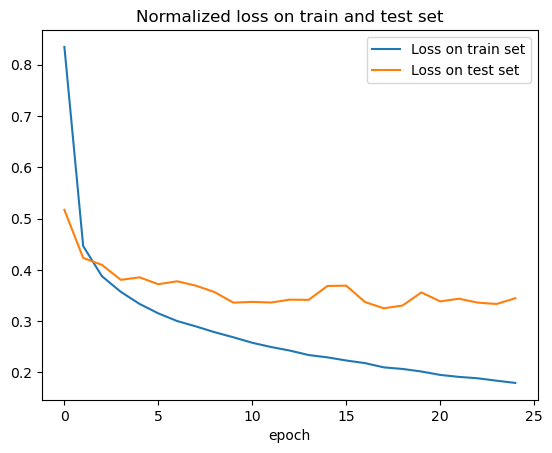

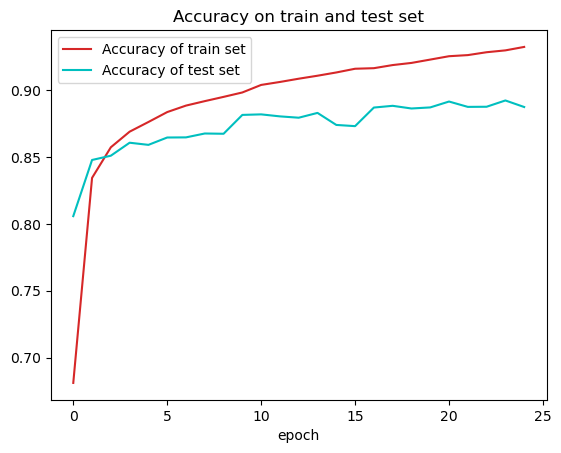

In [16]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.005)

In [17]:
print(f'Final test accuracy: {test_accuracies[-1]}')

Final test accuracy: 0.8874


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

In [ ]:
fig2,axs2=plt.subplots(2,5,figsize=(15,7))
rng=np.random.default_rng()
for i in range(10):
    index = rng.integers(len(train_set))
    image, label = train_set[index]
    while (label!=i):
        index = rng.integers(len(train_set))
        image, label = train_set[index]
    image=image.to(device)
    p = model(image, parameters)    
    y_pred = p.argmax(dim=-1)
    axs2[i//5][i%5].title.set_text("Label %i, Predicted label %i" %(i+1,y_pred+1))
    axs2[i//5][i%5].imshow(image.cpu()[0], cmap="gray")
plt.show()